In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 20
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_firstorder_Range_firstorder_Skewness_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_Run

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 648)
(3944610, 8)
validation
(464344, 648)
(464344, 8)
test
(574820, 648)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 648)]             0         


 dense (Dense)               (None, 1024)              664576    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1354632 (5.17 MB)


Trainable params: 1354632 (5.17 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 11:05 - loss: 2.5307 - STD: 0.1369 - MAE: 0.2152

  4/395 [..............................] - ETA: 7s - loss: 2.2334 - STD: 0.0776 - MAE: 0.2160   

  7/395 [..............................] - ETA: 7s - loss: 2.1755 - STD: 0.0593 - MAE: 0.2168

 10/395 [..............................] - ETA: 7s - loss: 2.1526 - STD: 0.0535 - MAE: 0.2170

 13/395 [..............................] - ETA: 7s - loss: 2.1370 - STD: 0.0522 - MAE: 0.2168

 16/395 [>.............................] - ETA: 7s - loss: 2.1234 - STD: 0.0508 - MAE: 0.2167

 19/395 [>.............................] - ETA: 7s - loss: 2.1128 - STD: 0.0483 - MAE: 0.2167

 22/395 [>.............................] - ETA: 7s - loss: 2.1053 - STD: 0.0458 - MAE: 0.2167

 25/395 [>.............................] - ETA: 7s - loss: 2.0997 - STD: 0.0443 - MAE: 0.2168

 28/395 [=>............................] - ETA: 7s - loss: 2.0950 - STD: 0.0434 - MAE: 0.2167

 31/395 [=>............................] - ETA: 7s - loss: 2.0911 - STD: 0.0426 - MAE: 0.2167

 34/395 [=>............................] - ETA: 7s - loss: 2.0876 - STD: 0.0415 - MAE: 0.2167

 37/395 [=>............................] - ETA: 7s - loss: 2.0845 - STD: 0.0406 - MAE: 0.2167

 40/395 [==>...........................] - ETA: 6s - loss: 2.0821 - STD: 0.0402 - MAE: 0.2167

 43/395 [==>...........................] - ETA: 6s - loss: 2.0799 - STD: 0.0399 - MAE: 0.2167

 46/395 [==>...........................] - ETA: 6s - loss: 2.0777 - STD: 0.0394 - MAE: 0.2167

 49/395 [==>...........................] - ETA: 6s - loss: 2.0758 - STD: 0.0389 - MAE: 0.2167

 52/395 [==>...........................] - ETA: 6s - loss: 2.0741 - STD: 0.0385 - MAE: 0.2167

 55/395 [===>..........................] - ETA: 6s - loss: 2.0724 - STD: 0.0382 - MAE: 0.2166

 58/395 [===>..........................] - ETA: 6s - loss: 2.0707 - STD: 0.0378 - MAE: 0.2166

 61/395 [===>..........................] - ETA: 6s - loss: 2.0689 - STD: 0.0375 - MAE: 0.2166

 64/395 [===>..........................] - ETA: 6s - loss: 2.0668 - STD: 0.0373 - MAE: 0.2166

 67/395 [====>.........................] - ETA: 6s - loss: 2.0644 - STD: 0.0372 - MAE: 0.2165

 70/395 [====>.........................] - ETA: 6s - loss: 2.0617 - STD: 0.0372 - MAE: 0.2164

 73/395 [====>.........................] - ETA: 6s - loss: 2.0584 - STD: 0.0372 - MAE: 0.2163

 76/395 [====>.........................] - ETA: 6s - loss: 2.0546 - STD: 0.0375 - MAE: 0.2162

 79/395 [=====>........................] - ETA: 6s - loss: 2.0503 - STD: 0.0380 - MAE: 0.2160

 82/395 [=====>........................] - ETA: 6s - loss: 2.0455 - STD: 0.0386 - MAE: 0.2158

 85/395 [=====>........................] - ETA: 6s - loss: 2.0401 - STD: 0.0395 - MAE: 0.2155

 88/395 [=====>........................] - ETA: 5s - loss: 2.0344 - STD: 0.0404 - MAE: 0.2152

 91/395 [=====>........................] - ETA: 5s - loss: 2.0285 - STD: 0.0413 - MAE: 0.2150

 94/395 [======>.......................] - ETA: 5s - loss: 2.0223 - STD: 0.0423 - MAE: 0.2146

 97/395 [======>.......................] - ETA: 5s - loss: 2.0158 - STD: 0.0434 - MAE: 0.2143

100/395 [======>.......................] - ETA: 5s - loss: 2.0090 - STD: 0.0445 - MAE: 0.2140

103/395 [======>.......................] - ETA: 5s - loss: 2.0021 - STD: 0.0457 - MAE: 0.2136

106/395 [=======>......................] - ETA: 5s - loss: 1.9949 - STD: 0.0468 - MAE: 0.2132

109/395 [=======>......................] - ETA: 5s - loss: 1.9873 - STD: 0.0480 - MAE: 0.2128

112/395 [=======>......................] - ETA: 5s - loss: 1.9795 - STD: 0.0492 - MAE: 0.2124

115/395 [=======>......................] - ETA: 5s - loss: 1.9711 - STD: 0.0505 - MAE: 0.2120

118/395 [=======>......................] - ETA: 5s - loss: 1.9624 - STD: 0.0518 - MAE: 0.2115

121/395 [========>.....................] - ETA: 5s - loss: 1.9533 - STD: 0.0532 - MAE: 0.2110

124/395 [========>.....................] - ETA: 5s - loss: 1.9440 - STD: 0.0546 - MAE: 0.2105

127/395 [========>.....................] - ETA: 5s - loss: 1.9345 - STD: 0.0560 - MAE: 0.2100

130/395 [========>.....................] - ETA: 5s - loss: 1.9251 - STD: 0.0575 - MAE: 0.2094

133/395 [=========>....................] - ETA: 5s - loss: 1.9158 - STD: 0.0590 - MAE: 0.2088

136/395 [=========>....................] - ETA: 5s - loss: 1.9069 - STD: 0.0605 - MAE: 0.2083

139/395 [=========>....................] - ETA: 4s - loss: 1.8978 - STD: 0.0619 - MAE: 0.2077

142/395 [=========>....................] - ETA: 4s - loss: 1.8890 - STD: 0.0634 - MAE: 0.2072

145/395 [==========>...................] - ETA: 4s - loss: 1.8805 - STD: 0.0648 - MAE: 0.2066

148/395 [==========>...................] - ETA: 4s - loss: 1.8721 - STD: 0.0662 - MAE: 0.2061

151/395 [==========>...................] - ETA: 4s - loss: 1.8639 - STD: 0.0676 - MAE: 0.2056

154/395 [==========>...................] - ETA: 4s - loss: 1.8560 - STD: 0.0688 - MAE: 0.2051

157/395 [==========>...................] - ETA: 4s - loss: 1.8482 - STD: 0.0701 - MAE: 0.2046

160/395 [===========>..................] - ETA: 4s - loss: 1.8406 - STD: 0.0713 - MAE: 0.2041

163/395 [===========>..................] - ETA: 4s - loss: 1.8332 - STD: 0.0726 - MAE: 0.2036

166/395 [===========>..................] - ETA: 4s - loss: 1.8261 - STD: 0.0737 - MAE: 0.2031

169/395 [===========>..................] - ETA: 4s - loss: 1.8189 - STD: 0.0749 - MAE: 0.2026

172/395 [============>.................] - ETA: 4s - loss: 1.8121 - STD: 0.0760 - MAE: 0.2022

175/395 [============>.................] - ETA: 4s - loss: 1.8054 - STD: 0.0771 - MAE: 0.2017

178/395 [============>.................] - ETA: 4s - loss: 1.7987 - STD: 0.0782 - MAE: 0.2013

181/395 [============>.................] - ETA: 4s - loss: 1.7925 - STD: 0.0793 - MAE: 0.2009

184/395 [============>.................] - ETA: 4s - loss: 1.7862 - STD: 0.0803 - MAE: 0.2004

187/395 [=============>................] - ETA: 4s - loss: 1.7800 - STD: 0.0813 - MAE: 0.2000

190/395 [=============>................] - ETA: 4s - loss: 1.7740 - STD: 0.0823 - MAE: 0.1996

193/395 [=============>................] - ETA: 3s - loss: 1.7682 - STD: 0.0833 - MAE: 0.1992

196/395 [=============>................] - ETA: 3s - loss: 1.7623 - STD: 0.0843 - MAE: 0.1988

199/395 [==============>...............] - ETA: 3s - loss: 1.7565 - STD: 0.0852 - MAE: 0.1984

202/395 [==============>...............] - ETA: 3s - loss: 1.7509 - STD: 0.0861 - MAE: 0.1980

205/395 [==============>...............] - ETA: 3s - loss: 1.7454 - STD: 0.0871 - MAE: 0.1976

208/395 [==============>...............] - ETA: 3s - loss: 1.7399 - STD: 0.0880 - MAE: 0.1972

211/395 [===============>..............] - ETA: 3s - loss: 1.7346 - STD: 0.0888 - MAE: 0.1968

214/395 [===============>..............] - ETA: 3s - loss: 1.7292 - STD: 0.0897 - MAE: 0.1964

217/395 [===============>..............] - ETA: 3s - loss: 1.7241 - STD: 0.0906 - MAE: 0.1961

220/395 [===============>..............] - ETA: 3s - loss: 1.7190 - STD: 0.0914 - MAE: 0.1957

223/395 [===============>..............] - ETA: 3s - loss: 1.7140 - STD: 0.0923 - MAE: 0.1953

226/395 [================>.............] - ETA: 3s - loss: 1.7091 - STD: 0.0931 - MAE: 0.1950

229/395 [================>.............] - ETA: 3s - loss: 1.7043 - STD: 0.0939 - MAE: 0.1946

232/395 [================>.............] - ETA: 3s - loss: 1.6995 - STD: 0.0948 - MAE: 0.1942

235/395 [================>.............] - ETA: 3s - loss: 1.6948 - STD: 0.0956 - MAE: 0.1939

238/395 [=================>............] - ETA: 3s - loss: 1.6901 - STD: 0.0964 - MAE: 0.1935

241/395 [=================>............] - ETA: 3s - loss: 1.6854 - STD: 0.0971 - MAE: 0.1932

244/395 [=================>............] - ETA: 2s - loss: 1.6809 - STD: 0.0979 - MAE: 0.1928

247/395 [=================>............] - ETA: 2s - loss: 1.6764 - STD: 0.0987 - MAE: 0.1925

250/395 [=================>............] - ETA: 2s - loss: 1.6720 - STD: 0.0994 - MAE: 0.1921

253/395 [==================>...........] - ETA: 2s - loss: 1.6677 - STD: 0.1002 - MAE: 0.1918

256/395 [==================>...........] - ETA: 2s - loss: 1.6636 - STD: 0.1009 - MAE: 0.1914

259/395 [==================>...........] - ETA: 2s - loss: 1.6595 - STD: 0.1016 - MAE: 0.1911

262/395 [==================>...........] - ETA: 2s - loss: 1.6555 - STD: 0.1024 - MAE: 0.1908

265/395 [===================>..........] - ETA: 2s - loss: 1.6515 - STD: 0.1031 - MAE: 0.1905

268/395 [===================>..........] - ETA: 2s - loss: 1.6475 - STD: 0.1038 - MAE: 0.1901

271/395 [===================>..........] - ETA: 2s - loss: 1.6437 - STD: 0.1044 - MAE: 0.1898

274/395 [===================>..........] - ETA: 2s - loss: 1.6397 - STD: 0.1051 - MAE: 0.1895

277/395 [====================>.........] - ETA: 2s - loss: 1.6359 - STD: 0.1058 - MAE: 0.1892

280/395 [====================>.........] - ETA: 2s - loss: 1.6321 - STD: 0.1064 - MAE: 0.1889

283/395 [====================>.........] - ETA: 2s - loss: 1.6284 - STD: 0.1071 - MAE: 0.1886

286/395 [====================>.........] - ETA: 2s - loss: 1.6248 - STD: 0.1077 - MAE: 0.1883

289/395 [====================>.........] - ETA: 2s - loss: 1.6211 - STD: 0.1083 - MAE: 0.1880

292/395 [=====================>........] - ETA: 2s - loss: 1.6173 - STD: 0.1090 - MAE: 0.1877

295/395 [=====================>........] - ETA: 1s - loss: 1.6137 - STD: 0.1096 - MAE: 0.1874

298/395 [=====================>........] - ETA: 1s - loss: 1.6103 - STD: 0.1102 - MAE: 0.1871

301/395 [=====================>........] - ETA: 1s - loss: 1.6068 - STD: 0.1108 - MAE: 0.1868

304/395 [======================>.......] - ETA: 1s - loss: 1.6035 - STD: 0.1114 - MAE: 0.1865

307/395 [======================>.......] - ETA: 1s - loss: 1.6001 - STD: 0.1120 - MAE: 0.1863

310/395 [======================>.......] - ETA: 1s - loss: 1.5968 - STD: 0.1126 - MAE: 0.1860

313/395 [======================>.......] - ETA: 1s - loss: 1.5935 - STD: 0.1132 - MAE: 0.1857

316/395 [=======================>......] - ETA: 1s - loss: 1.5902 - STD: 0.1137 - MAE: 0.1854

319/395 [=======================>......] - ETA: 1s - loss: 1.5870 - STD: 0.1143 - MAE: 0.1852

322/395 [=======================>......] - ETA: 1s - loss: 1.5838 - STD: 0.1149 - MAE: 0.1849

325/395 [=======================>......] - ETA: 1s - loss: 1.5809 - STD: 0.1154 - MAE: 0.1846

328/395 [=======================>......] - ETA: 1s - loss: 1.5778 - STD: 0.1160 - MAE: 0.1844

331/395 [========================>.....] - ETA: 1s - loss: 1.5747 - STD: 0.1165 - MAE: 0.1841

334/395 [========================>.....] - ETA: 1s - loss: 1.5718 - STD: 0.1170 - MAE: 0.1839

337/395 [========================>.....] - ETA: 1s - loss: 1.5688 - STD: 0.1175 - MAE: 0.1836

340/395 [========================>.....] - ETA: 1s - loss: 1.5658 - STD: 0.1181 - MAE: 0.1834

343/395 [=========================>....] - ETA: 1s - loss: 1.5630 - STD: 0.1186 - MAE: 0.1831

346/395 [=========================>....] - ETA: 0s - loss: 1.5603 - STD: 0.1191 - MAE: 0.1829

349/395 [=========================>....] - ETA: 0s - loss: 1.5575 - STD: 0.1196 - MAE: 0.1826

352/395 [=========================>....] - ETA: 0s - loss: 1.5547 - STD: 0.1201 - MAE: 0.1824

355/395 [=========================>....] - ETA: 0s - loss: 1.5519 - STD: 0.1205 - MAE: 0.1822

358/395 [==========================>...] - ETA: 0s - loss: 1.5492 - STD: 0.1210 - MAE: 0.1819

361/395 [==========================>...] - ETA: 0s - loss: 1.5465 - STD: 0.1215 - MAE: 0.1817

362/395 [==========================>...] - ETA: 0s - loss: 1.5461 - STD: 0.1216 - MAE: 0.1816

365/395 [==========================>...] - ETA: 0s - loss: 1.5434 - STD: 0.1221 - MAE: 0.1814

368/395 [==========================>...] - ETA: 0s - loss: 1.5408 - STD: 0.1226 - MAE: 0.1812

371/395 [===========================>..] - ETA: 0s - loss: 1.5380 - STD: 0.1230 - MAE: 0.1809

374/395 [===========================>..] - ETA: 0s - loss: 1.5355 - STD: 0.1235 - MAE: 0.1807

377/395 [===========================>..] - ETA: 0s - loss: 1.5330 - STD: 0.1239 - MAE: 0.1805

380/395 [===========================>..] - ETA: 0s - loss: 1.5304 - STD: 0.1244 - MAE: 0.1803

383/395 [============================>.] - ETA: 0s - loss: 1.5280 - STD: 0.1248 - MAE: 0.1801

386/395 [============================>.] - ETA: 0s - loss: 1.5257 - STD: 0.1252 - MAE: 0.1799

389/395 [============================>.] - ETA: 0s - loss: 1.5233 - STD: 0.1256 - MAE: 0.1796

392/395 [============================>.] - ETA: 0s - loss: 1.5210 - STD: 0.1261 - MAE: 0.1794

395/395 [==============================] - ETA: 0s - loss: 1.5186 - STD: 0.1265 - MAE: 0.1792

395/395 [==============================] - 12s 25ms/step - loss: 1.5186 - STD: 0.1265 - MAE: 0.1792 - val_loss: 1.2361 - val_STD: 0.1804 - val_MAE: 0.1516


Epoch 2/10000


  1/395 [..............................] - ETA: 17s - loss: 1.2341 - STD: 0.1800 - MAE: 0.1539

  4/395 [..............................] - ETA: 7s - loss: 1.2141 - STD: 0.1801 - MAE: 0.1526 

  7/395 [..............................] - ETA: 7s - loss: 1.2148 - STD: 0.1798 - MAE: 0.1527

 10/395 [..............................] - ETA: 7s - loss: 1.2148 - STD: 0.1802 - MAE: 0.1526

 13/395 [..............................] - ETA: 7s - loss: 1.2123 - STD: 0.1806 - MAE: 0.1524

 16/395 [>.............................] - ETA: 7s - loss: 1.2104 - STD: 0.1810 - MAE: 0.1521

 19/395 [>.............................] - ETA: 7s - loss: 1.2080 - STD: 0.1811 - MAE: 0.1520

 22/395 [>.............................] - ETA: 7s - loss: 1.2091 - STD: 0.1810 - MAE: 0.1520

 25/395 [>.............................] - ETA: 7s - loss: 1.2077 - STD: 0.1811 - MAE: 0.1519

 28/395 [=>............................] - ETA: 7s - loss: 1.2060 - STD: 0.1811 - MAE: 0.1518

 31/395 [=>............................] - ETA: 7s - loss: 1.2050 - STD: 0.1812 - MAE: 0.1517

 34/395 [=>............................] - ETA: 7s - loss: 1.2038 - STD: 0.1814 - MAE: 0.1517

 37/395 [=>............................] - ETA: 7s - loss: 1.2022 - STD: 0.1815 - MAE: 0.1515

 40/395 [==>...........................] - ETA: 6s - loss: 1.2018 - STD: 0.1817 - MAE: 0.1515

 43/395 [==>...........................] - ETA: 6s - loss: 1.2021 - STD: 0.1817 - MAE: 0.1515

 46/395 [==>...........................] - ETA: 6s - loss: 1.2014 - STD: 0.1818 - MAE: 0.1514

 49/395 [==>...........................] - ETA: 6s - loss: 1.2003 - STD: 0.1819 - MAE: 0.1513

 52/395 [==>...........................] - ETA: 6s - loss: 1.2002 - STD: 0.1821 - MAE: 0.1512

 55/395 [===>..........................] - ETA: 6s - loss: 1.2001 - STD: 0.1823 - MAE: 0.1512

 58/395 [===>..........................] - ETA: 6s - loss: 1.1997 - STD: 0.1823 - MAE: 0.1511

 61/395 [===>..........................] - ETA: 6s - loss: 1.1992 - STD: 0.1824 - MAE: 0.1511

 64/395 [===>..........................] - ETA: 6s - loss: 1.1987 - STD: 0.1825 - MAE: 0.1510

 67/395 [====>.........................] - ETA: 6s - loss: 1.1982 - STD: 0.1825 - MAE: 0.1510

 70/395 [====>.........................] - ETA: 6s - loss: 1.1973 - STD: 0.1826 - MAE: 0.1509

 73/395 [====>.........................] - ETA: 6s - loss: 1.1968 - STD: 0.1827 - MAE: 0.1509

 76/395 [====>.........................] - ETA: 6s - loss: 1.1961 - STD: 0.1828 - MAE: 0.1508

 79/395 [=====>........................] - ETA: 6s - loss: 1.1953 - STD: 0.1829 - MAE: 0.1507

 82/395 [=====>........................] - ETA: 6s - loss: 1.1948 - STD: 0.1829 - MAE: 0.1507

 85/395 [=====>........................] - ETA: 6s - loss: 1.1943 - STD: 0.1830 - MAE: 0.1506

 88/395 [=====>........................] - ETA: 6s - loss: 1.1939 - STD: 0.1830 - MAE: 0.1506

 91/395 [=====>........................] - ETA: 5s - loss: 1.1947 - STD: 0.1831 - MAE: 0.1506

 94/395 [======>.......................] - ETA: 5s - loss: 1.1944 - STD: 0.1831 - MAE: 0.1506

 97/395 [======>.......................] - ETA: 5s - loss: 1.1937 - STD: 0.1832 - MAE: 0.1505

100/395 [======>.......................] - ETA: 5s - loss: 1.1931 - STD: 0.1833 - MAE: 0.1505

103/395 [======>.......................] - ETA: 5s - loss: 1.1927 - STD: 0.1834 - MAE: 0.1504

106/395 [=======>......................] - ETA: 5s - loss: 1.1921 - STD: 0.1834 - MAE: 0.1504

109/395 [=======>......................] - ETA: 5s - loss: 1.1915 - STD: 0.1835 - MAE: 0.1503

112/395 [=======>......................] - ETA: 5s - loss: 1.1910 - STD: 0.1835 - MAE: 0.1503

115/395 [=======>......................] - ETA: 5s - loss: 1.1904 - STD: 0.1836 - MAE: 0.1502

118/395 [=======>......................] - ETA: 5s - loss: 1.1897 - STD: 0.1837 - MAE: 0.1502

121/395 [========>.....................] - ETA: 5s - loss: 1.1892 - STD: 0.1838 - MAE: 0.1501

124/395 [========>.....................] - ETA: 5s - loss: 1.1886 - STD: 0.1838 - MAE: 0.1501

127/395 [========>.....................] - ETA: 5s - loss: 1.1879 - STD: 0.1839 - MAE: 0.1500

130/395 [========>.....................] - ETA: 5s - loss: 1.1872 - STD: 0.1840 - MAE: 0.1499

133/395 [=========>....................] - ETA: 5s - loss: 1.1866 - STD: 0.1841 - MAE: 0.1499

136/395 [=========>....................] - ETA: 5s - loss: 1.1864 - STD: 0.1842 - MAE: 0.1498

139/395 [=========>....................] - ETA: 5s - loss: 1.1863 - STD: 0.1843 - MAE: 0.1498

142/395 [=========>....................] - ETA: 4s - loss: 1.1860 - STD: 0.1843 - MAE: 0.1497

145/395 [==========>...................] - ETA: 4s - loss: 1.1861 - STD: 0.1844 - MAE: 0.1497

148/395 [==========>...................] - ETA: 4s - loss: 1.1863 - STD: 0.1845 - MAE: 0.1497

151/395 [==========>...................] - ETA: 4s - loss: 1.1862 - STD: 0.1845 - MAE: 0.1497

154/395 [==========>...................] - ETA: 4s - loss: 1.1859 - STD: 0.1846 - MAE: 0.1496

157/395 [==========>...................] - ETA: 4s - loss: 1.1852 - STD: 0.1847 - MAE: 0.1496

160/395 [===========>..................] - ETA: 4s - loss: 1.1847 - STD: 0.1847 - MAE: 0.1495

163/395 [===========>..................] - ETA: 4s - loss: 1.1840 - STD: 0.1848 - MAE: 0.1495

166/395 [===========>..................] - ETA: 4s - loss: 1.1835 - STD: 0.1849 - MAE: 0.1494

169/395 [===========>..................] - ETA: 4s - loss: 1.1828 - STD: 0.1849 - MAE: 0.1494

172/395 [============>.................] - ETA: 4s - loss: 1.1820 - STD: 0.1850 - MAE: 0.1493

175/395 [============>.................] - ETA: 4s - loss: 1.1814 - STD: 0.1851 - MAE: 0.1492

178/395 [============>.................] - ETA: 4s - loss: 1.1808 - STD: 0.1851 - MAE: 0.1492

181/395 [============>.................] - ETA: 4s - loss: 1.1801 - STD: 0.1852 - MAE: 0.1491

184/395 [============>.................] - ETA: 4s - loss: 1.1795 - STD: 0.1853 - MAE: 0.1491

187/395 [=============>................] - ETA: 4s - loss: 1.1793 - STD: 0.1853 - MAE: 0.1490

190/395 [=============>................] - ETA: 4s - loss: 1.1789 - STD: 0.1854 - MAE: 0.1490

193/395 [=============>................] - ETA: 3s - loss: 1.1786 - STD: 0.1855 - MAE: 0.1490

196/395 [=============>................] - ETA: 3s - loss: 1.1780 - STD: 0.1855 - MAE: 0.1489

199/395 [==============>...............] - ETA: 3s - loss: 1.1776 - STD: 0.1856 - MAE: 0.1489

202/395 [==============>...............] - ETA: 3s - loss: 1.1775 - STD: 0.1857 - MAE: 0.1488

205/395 [==============>...............] - ETA: 3s - loss: 1.1771 - STD: 0.1857 - MAE: 0.1488

208/395 [==============>...............] - ETA: 3s - loss: 1.1767 - STD: 0.1858 - MAE: 0.1487

211/395 [===============>..............] - ETA: 3s - loss: 1.1766 - STD: 0.1858 - MAE: 0.1487

214/395 [===============>..............] - ETA: 3s - loss: 1.1763 - STD: 0.1859 - MAE: 0.1487

217/395 [===============>..............] - ETA: 3s - loss: 1.1759 - STD: 0.1860 - MAE: 0.1486

220/395 [===============>..............] - ETA: 3s - loss: 1.1755 - STD: 0.1860 - MAE: 0.1486

223/395 [===============>..............] - ETA: 3s - loss: 1.1750 - STD: 0.1861 - MAE: 0.1486

226/395 [================>.............] - ETA: 3s - loss: 1.1745 - STD: 0.1861 - MAE: 0.1485

229/395 [================>.............] - ETA: 3s - loss: 1.1740 - STD: 0.1862 - MAE: 0.1485

232/395 [================>.............] - ETA: 3s - loss: 1.1736 - STD: 0.1862 - MAE: 0.1484

236/395 [================>.............] - ETA: 3s - loss: 1.1731 - STD: 0.1863 - MAE: 0.1484

239/395 [=================>............] - ETA: 3s - loss: 1.1726 - STD: 0.1864 - MAE: 0.1483

242/395 [=================>............] - ETA: 2s - loss: 1.1723 - STD: 0.1864 - MAE: 0.1483

245/395 [=================>............] - ETA: 2s - loss: 1.1718 - STD: 0.1865 - MAE: 0.1482

248/395 [=================>............] - ETA: 2s - loss: 1.1712 - STD: 0.1865 - MAE: 0.1482

251/395 [==================>...........] - ETA: 2s - loss: 1.1707 - STD: 0.1866 - MAE: 0.1481

254/395 [==================>...........] - ETA: 2s - loss: 1.1700 - STD: 0.1867 - MAE: 0.1481

257/395 [==================>...........] - ETA: 2s - loss: 1.1695 - STD: 0.1867 - MAE: 0.1480

260/395 [==================>...........] - ETA: 2s - loss: 1.1691 - STD: 0.1868 - MAE: 0.1480

263/395 [==================>...........] - ETA: 2s - loss: 1.1686 - STD: 0.1868 - MAE: 0.1479

266/395 [===================>..........] - ETA: 2s - loss: 1.1683 - STD: 0.1869 - MAE: 0.1479

269/395 [===================>..........] - ETA: 2s - loss: 1.1678 - STD: 0.1870 - MAE: 0.1479

272/395 [===================>..........] - ETA: 2s - loss: 1.1675 - STD: 0.1870 - MAE: 0.1478

275/395 [===================>..........] - ETA: 2s - loss: 1.1670 - STD: 0.1871 - MAE: 0.1478

278/395 [====================>.........] - ETA: 2s - loss: 1.1665 - STD: 0.1872 - MAE: 0.1477

281/395 [====================>.........] - ETA: 2s - loss: 1.1661 - STD: 0.1872 - MAE: 0.1477

284/395 [====================>.........] - ETA: 2s - loss: 1.1656 - STD: 0.1873 - MAE: 0.1476

287/395 [====================>.........] - ETA: 2s - loss: 1.1651 - STD: 0.1873 - MAE: 0.1476

290/395 [=====================>........] - ETA: 2s - loss: 1.1646 - STD: 0.1874 - MAE: 0.1475

293/395 [=====================>........] - ETA: 1s - loss: 1.1641 - STD: 0.1874 - MAE: 0.1475

296/395 [=====================>........] - ETA: 1s - loss: 1.1643 - STD: 0.1875 - MAE: 0.1475

299/395 [=====================>........] - ETA: 1s - loss: 1.1639 - STD: 0.1875 - MAE: 0.1475

302/395 [=====================>........] - ETA: 1s - loss: 1.1637 - STD: 0.1876 - MAE: 0.1474

305/395 [======================>.......] - ETA: 1s - loss: 1.1634 - STD: 0.1877 - MAE: 0.1474

308/395 [======================>.......] - ETA: 1s - loss: 1.1629 - STD: 0.1877 - MAE: 0.1473

311/395 [======================>.......] - ETA: 1s - loss: 1.1625 - STD: 0.1878 - MAE: 0.1473

314/395 [======================>.......] - ETA: 1s - loss: 1.1622 - STD: 0.1878 - MAE: 0.1473

317/395 [=======================>......] - ETA: 1s - loss: 1.1619 - STD: 0.1879 - MAE: 0.1472

320/395 [=======================>......] - ETA: 1s - loss: 1.1614 - STD: 0.1879 - MAE: 0.1472

323/395 [=======================>......] - ETA: 1s - loss: 1.1609 - STD: 0.1880 - MAE: 0.1472

326/395 [=======================>......] - ETA: 1s - loss: 1.1604 - STD: 0.1880 - MAE: 0.1471

329/395 [=======================>......] - ETA: 1s - loss: 1.1600 - STD: 0.1880 - MAE: 0.1471

332/395 [========================>.....] - ETA: 1s - loss: 1.1596 - STD: 0.1881 - MAE: 0.1470

335/395 [========================>.....] - ETA: 1s - loss: 1.1591 - STD: 0.1881 - MAE: 0.1470

338/395 [========================>.....] - ETA: 1s - loss: 1.1586 - STD: 0.1882 - MAE: 0.1469

341/395 [========================>.....] - ETA: 1s - loss: 1.1581 - STD: 0.1882 - MAE: 0.1469

344/395 [=========================>....] - ETA: 0s - loss: 1.1577 - STD: 0.1883 - MAE: 0.1469

347/395 [=========================>....] - ETA: 0s - loss: 1.1573 - STD: 0.1883 - MAE: 0.1468

350/395 [=========================>....] - ETA: 0s - loss: 1.1569 - STD: 0.1884 - MAE: 0.1468

353/395 [=========================>....] - ETA: 0s - loss: 1.1565 - STD: 0.1884 - MAE: 0.1467

356/395 [==========================>...] - ETA: 0s - loss: 1.1562 - STD: 0.1885 - MAE: 0.1467

359/395 [==========================>...] - ETA: 0s - loss: 1.1561 - STD: 0.1885 - MAE: 0.1467

362/395 [==========================>...] - ETA: 0s - loss: 1.1558 - STD: 0.1886 - MAE: 0.1467

365/395 [==========================>...] - ETA: 0s - loss: 1.1556 - STD: 0.1886 - MAE: 0.1466

368/395 [==========================>...] - ETA: 0s - loss: 1.1552 - STD: 0.1887 - MAE: 0.1466

371/395 [===========================>..] - ETA: 0s - loss: 1.1549 - STD: 0.1887 - MAE: 0.1466

374/395 [===========================>..] - ETA: 0s - loss: 1.1546 - STD: 0.1888 - MAE: 0.1465

377/395 [===========================>..] - ETA: 0s - loss: 1.1543 - STD: 0.1888 - MAE: 0.1465

380/395 [===========================>..] - ETA: 0s - loss: 1.1539 - STD: 0.1889 - MAE: 0.1465

383/395 [============================>.] - ETA: 0s - loss: 1.1536 - STD: 0.1889 - MAE: 0.1464

386/395 [============================>.] - ETA: 0s - loss: 1.1533 - STD: 0.1889 - MAE: 0.1464

389/395 [============================>.] - ETA: 0s - loss: 1.1528 - STD: 0.1890 - MAE: 0.1464

392/395 [============================>.] - ETA: 0s - loss: 1.1526 - STD: 0.1891 - MAE: 0.1463

395/395 [==============================] - ETA: 0s - loss: 1.1523 - STD: 0.1891 - MAE: 0.1463

395/395 [==============================] - 8s 21ms/step - loss: 1.1523 - STD: 0.1891 - MAE: 0.1463 - val_loss: 1.1653 - val_STD: 0.1960 - val_MAE: 0.1430


Epoch 3/10000


  1/395 [..............................] - ETA: 17s - loss: 1.0969 - STD: 0.1940 - MAE: 0.1418

  4/395 [..............................] - ETA: 7s - loss: 1.1054 - STD: 0.1943 - MAE: 0.1421 

  7/395 [..............................] - ETA: 7s - loss: 1.1081 - STD: 0.1948 - MAE: 0.1420

 10/395 [..............................] - ETA: 7s - loss: 1.1059 - STD: 0.1946 - MAE: 0.1420

 13/395 [..............................] - ETA: 7s - loss: 1.1043 - STD: 0.1946 - MAE: 0.1419

 16/395 [>.............................] - ETA: 7s - loss: 1.1039 - STD: 0.1947 - MAE: 0.1419

 19/395 [>.............................] - ETA: 7s - loss: 1.1024 - STD: 0.1948 - MAE: 0.1417

 22/395 [>.............................] - ETA: 7s - loss: 1.1004 - STD: 0.1951 - MAE: 0.1415

 25/395 [>.............................] - ETA: 7s - loss: 1.0992 - STD: 0.1951 - MAE: 0.1414

 28/395 [=>............................] - ETA: 7s - loss: 1.0995 - STD: 0.1951 - MAE: 0.1414

 31/395 [=>............................] - ETA: 7s - loss: 1.0994 - STD: 0.1952 - MAE: 0.1414

 34/395 [=>............................] - ETA: 7s - loss: 1.0998 - STD: 0.1954 - MAE: 0.1413

 37/395 [=>............................] - ETA: 7s - loss: 1.0988 - STD: 0.1955 - MAE: 0.1412

 40/395 [==>...........................] - ETA: 6s - loss: 1.0973 - STD: 0.1957 - MAE: 0.1411

 43/395 [==>...........................] - ETA: 6s - loss: 1.0979 - STD: 0.1957 - MAE: 0.1411

 46/395 [==>...........................] - ETA: 6s - loss: 1.0980 - STD: 0.1957 - MAE: 0.1411

 49/395 [==>...........................] - ETA: 6s - loss: 1.0982 - STD: 0.1958 - MAE: 0.1411

 52/395 [==>...........................] - ETA: 6s - loss: 1.0992 - STD: 0.1958 - MAE: 0.1411

 55/395 [===>..........................] - ETA: 6s - loss: 1.1011 - STD: 0.1959 - MAE: 0.1412

 58/395 [===>..........................] - ETA: 6s - loss: 1.1013 - STD: 0.1959 - MAE: 0.1412

 61/395 [===>..........................] - ETA: 6s - loss: 1.1012 - STD: 0.1959 - MAE: 0.1412

 64/395 [===>..........................] - ETA: 6s - loss: 1.1010 - STD: 0.1959 - MAE: 0.1412

 67/395 [====>.........................] - ETA: 6s - loss: 1.1005 - STD: 0.1959 - MAE: 0.1411

 70/395 [====>.........................] - ETA: 6s - loss: 1.1004 - STD: 0.1959 - MAE: 0.1411

 73/395 [====>.........................] - ETA: 6s - loss: 1.1002 - STD: 0.1959 - MAE: 0.1411

 76/395 [====>.........................] - ETA: 6s - loss: 1.1000 - STD: 0.1960 - MAE: 0.1411

 79/395 [=====>........................] - ETA: 6s - loss: 1.0998 - STD: 0.1960 - MAE: 0.1411

 82/395 [=====>........................] - ETA: 6s - loss: 1.0996 - STD: 0.1960 - MAE: 0.1410

 85/395 [=====>........................] - ETA: 6s - loss: 1.0991 - STD: 0.1960 - MAE: 0.1410

 88/395 [=====>........................] - ETA: 5s - loss: 1.0984 - STD: 0.1960 - MAE: 0.1410

 91/395 [=====>........................] - ETA: 5s - loss: 1.0979 - STD: 0.1960 - MAE: 0.1409

 94/395 [======>.......................] - ETA: 5s - loss: 1.0970 - STD: 0.1961 - MAE: 0.1409

 97/395 [======>.......................] - ETA: 5s - loss: 1.0966 - STD: 0.1961 - MAE: 0.1408

100/395 [======>.......................] - ETA: 5s - loss: 1.0959 - STD: 0.1962 - MAE: 0.1408

103/395 [======>.......................] - ETA: 5s - loss: 1.0953 - STD: 0.1962 - MAE: 0.1408

106/395 [=======>......................] - ETA: 5s - loss: 1.0950 - STD: 0.1962 - MAE: 0.1407

109/395 [=======>......................] - ETA: 5s - loss: 1.0946 - STD: 0.1962 - MAE: 0.1407

112/395 [=======>......................] - ETA: 5s - loss: 1.0940 - STD: 0.1963 - MAE: 0.1407

115/395 [=======>......................] - ETA: 5s - loss: 1.0937 - STD: 0.1963 - MAE: 0.1406

118/395 [=======>......................] - ETA: 5s - loss: 1.0934 - STD: 0.1964 - MAE: 0.1406

121/395 [========>.....................] - ETA: 5s - loss: 1.0932 - STD: 0.1964 - MAE: 0.1406

124/395 [========>.....................] - ETA: 5s - loss: 1.0927 - STD: 0.1964 - MAE: 0.1405

127/395 [========>.....................] - ETA: 5s - loss: 1.0923 - STD: 0.1964 - MAE: 0.1405

130/395 [========>.....................] - ETA: 5s - loss: 1.0918 - STD: 0.1964 - MAE: 0.1405

133/395 [=========>....................] - ETA: 5s - loss: 1.0918 - STD: 0.1965 - MAE: 0.1405

136/395 [=========>....................] - ETA: 5s - loss: 1.0913 - STD: 0.1965 - MAE: 0.1404

139/395 [=========>....................] - ETA: 5s - loss: 1.0906 - STD: 0.1966 - MAE: 0.1404

142/395 [=========>....................] - ETA: 4s - loss: 1.0901 - STD: 0.1966 - MAE: 0.1403

145/395 [==========>...................] - ETA: 4s - loss: 1.0897 - STD: 0.1967 - MAE: 0.1403

148/395 [==========>...................] - ETA: 4s - loss: 1.0893 - STD: 0.1967 - MAE: 0.1403

151/395 [==========>...................] - ETA: 4s - loss: 1.0890 - STD: 0.1967 - MAE: 0.1402

154/395 [==========>...................] - ETA: 4s - loss: 1.0887 - STD: 0.1968 - MAE: 0.1402

157/395 [==========>...................] - ETA: 4s - loss: 1.0885 - STD: 0.1968 - MAE: 0.1402

160/395 [===========>..................] - ETA: 4s - loss: 1.0883 - STD: 0.1968 - MAE: 0.1401

163/395 [===========>..................] - ETA: 4s - loss: 1.0881 - STD: 0.1969 - MAE: 0.1401

166/395 [===========>..................] - ETA: 4s - loss: 1.0879 - STD: 0.1969 - MAE: 0.1401

169/395 [===========>..................] - ETA: 4s - loss: 1.0875 - STD: 0.1969 - MAE: 0.1401

172/395 [============>.................] - ETA: 4s - loss: 1.0873 - STD: 0.1970 - MAE: 0.1400

175/395 [============>.................] - ETA: 4s - loss: 1.0866 - STD: 0.1970 - MAE: 0.1400

178/395 [============>.................] - ETA: 4s - loss: 1.0862 - STD: 0.1970 - MAE: 0.1399

181/395 [============>.................] - ETA: 4s - loss: 1.0859 - STD: 0.1971 - MAE: 0.1399

184/395 [============>.................] - ETA: 4s - loss: 1.0857 - STD: 0.1971 - MAE: 0.1399

187/395 [=============>................] - ETA: 4s - loss: 1.0853 - STD: 0.1971 - MAE: 0.1399

190/395 [=============>................] - ETA: 4s - loss: 1.0848 - STD: 0.1972 - MAE: 0.1398

193/395 [=============>................] - ETA: 3s - loss: 1.0842 - STD: 0.1972 - MAE: 0.1398

196/395 [=============>................] - ETA: 3s - loss: 1.0839 - STD: 0.1972 - MAE: 0.1397

199/395 [==============>...............] - ETA: 3s - loss: 1.0834 - STD: 0.1973 - MAE: 0.1397

202/395 [==============>...............] - ETA: 3s - loss: 1.0829 - STD: 0.1973 - MAE: 0.1396

205/395 [==============>...............] - ETA: 3s - loss: 1.0824 - STD: 0.1974 - MAE: 0.1396

208/395 [==============>...............] - ETA: 3s - loss: 1.0821 - STD: 0.1974 - MAE: 0.1396

211/395 [===============>..............] - ETA: 3s - loss: 1.0817 - STD: 0.1975 - MAE: 0.1395

214/395 [===============>..............] - ETA: 3s - loss: 1.0812 - STD: 0.1975 - MAE: 0.1395

217/395 [===============>..............] - ETA: 3s - loss: 1.0811 - STD: 0.1976 - MAE: 0.1395

220/395 [===============>..............] - ETA: 3s - loss: 1.0806 - STD: 0.1976 - MAE: 0.1394

223/395 [===============>..............] - ETA: 3s - loss: 1.0802 - STD: 0.1977 - MAE: 0.1394

226/395 [================>.............] - ETA: 3s - loss: 1.0803 - STD: 0.1977 - MAE: 0.1394

229/395 [================>.............] - ETA: 3s - loss: 1.0800 - STD: 0.1977 - MAE: 0.1393

232/395 [================>.............] - ETA: 3s - loss: 1.0797 - STD: 0.1978 - MAE: 0.1393

235/395 [================>.............] - ETA: 3s - loss: 1.0793 - STD: 0.1978 - MAE: 0.1393

238/395 [=================>............] - ETA: 3s - loss: 1.0788 - STD: 0.1978 - MAE: 0.1392

241/395 [=================>............] - ETA: 3s - loss: 1.0784 - STD: 0.1979 - MAE: 0.1392

244/395 [=================>............] - ETA: 2s - loss: 1.0781 - STD: 0.1979 - MAE: 0.1392

247/395 [=================>............] - ETA: 2s - loss: 1.0776 - STD: 0.1980 - MAE: 0.1391

250/395 [=================>............] - ETA: 2s - loss: 1.0773 - STD: 0.1980 - MAE: 0.1391

253/395 [==================>...........] - ETA: 2s - loss: 1.0770 - STD: 0.1980 - MAE: 0.1391

256/395 [==================>...........] - ETA: 2s - loss: 1.0766 - STD: 0.1981 - MAE: 0.1390

259/395 [==================>...........] - ETA: 2s - loss: 1.0763 - STD: 0.1981 - MAE: 0.1390

262/395 [==================>...........] - ETA: 2s - loss: 1.0758 - STD: 0.1981 - MAE: 0.1390

265/395 [===================>..........] - ETA: 2s - loss: 1.0755 - STD: 0.1982 - MAE: 0.1389

268/395 [===================>..........] - ETA: 2s - loss: 1.0753 - STD: 0.1982 - MAE: 0.1389

271/395 [===================>..........] - ETA: 2s - loss: 1.0751 - STD: 0.1983 - MAE: 0.1389

274/395 [===================>..........] - ETA: 2s - loss: 1.0750 - STD: 0.1983 - MAE: 0.1388

277/395 [====================>.........] - ETA: 2s - loss: 1.0747 - STD: 0.1983 - MAE: 0.1388

280/395 [====================>.........] - ETA: 2s - loss: 1.0747 - STD: 0.1984 - MAE: 0.1388

283/395 [====================>.........] - ETA: 2s - loss: 1.0742 - STD: 0.1984 - MAE: 0.1388

286/395 [====================>.........] - ETA: 2s - loss: 1.0739 - STD: 0.1984 - MAE: 0.1387

289/395 [====================>.........] - ETA: 2s - loss: 1.0737 - STD: 0.1985 - MAE: 0.1387

292/395 [=====================>........] - ETA: 2s - loss: 1.0735 - STD: 0.1985 - MAE: 0.1387

295/395 [=====================>........] - ETA: 1s - loss: 1.0732 - STD: 0.1985 - MAE: 0.1387

298/395 [=====================>........] - ETA: 1s - loss: 1.0732 - STD: 0.1986 - MAE: 0.1386

301/395 [=====================>........] - ETA: 1s - loss: 1.0727 - STD: 0.1986 - MAE: 0.1386

304/395 [======================>.......] - ETA: 1s - loss: 1.0724 - STD: 0.1986 - MAE: 0.1386

307/395 [======================>.......] - ETA: 1s - loss: 1.0719 - STD: 0.1987 - MAE: 0.1385

310/395 [======================>.......] - ETA: 1s - loss: 1.0716 - STD: 0.1987 - MAE: 0.1385

313/395 [======================>.......] - ETA: 1s - loss: 1.0712 - STD: 0.1988 - MAE: 0.1385

316/395 [=======================>......] - ETA: 1s - loss: 1.0709 - STD: 0.1988 - MAE: 0.1384

319/395 [=======================>......] - ETA: 1s - loss: 1.0705 - STD: 0.1988 - MAE: 0.1384

322/395 [=======================>......] - ETA: 1s - loss: 1.0700 - STD: 0.1989 - MAE: 0.1383

325/395 [=======================>......] - ETA: 1s - loss: 1.0697 - STD: 0.1989 - MAE: 0.1383

328/395 [=======================>......] - ETA: 1s - loss: 1.0694 - STD: 0.1989 - MAE: 0.1383

331/395 [========================>.....] - ETA: 1s - loss: 1.0690 - STD: 0.1990 - MAE: 0.1382

334/395 [========================>.....] - ETA: 1s - loss: 1.0687 - STD: 0.1990 - MAE: 0.1382

337/395 [========================>.....] - ETA: 1s - loss: 1.0682 - STD: 0.1991 - MAE: 0.1382

340/395 [========================>.....] - ETA: 1s - loss: 1.0679 - STD: 0.1991 - MAE: 0.1381

343/395 [=========================>....] - ETA: 1s - loss: 1.0677 - STD: 0.1991 - MAE: 0.1381

346/395 [=========================>....] - ETA: 0s - loss: 1.0674 - STD: 0.1992 - MAE: 0.1381

349/395 [=========================>....] - ETA: 0s - loss: 1.0672 - STD: 0.1992 - MAE: 0.1381

352/395 [=========================>....] - ETA: 0s - loss: 1.0669 - STD: 0.1993 - MAE: 0.1380

355/395 [=========================>....] - ETA: 0s - loss: 1.0668 - STD: 0.1993 - MAE: 0.1380

358/395 [==========================>...] - ETA: 0s - loss: 1.0665 - STD: 0.1993 - MAE: 0.1380

361/395 [==========================>...] - ETA: 0s - loss: 1.0663 - STD: 0.1994 - MAE: 0.1379

364/395 [==========================>...] - ETA: 0s - loss: 1.0662 - STD: 0.1994 - MAE: 0.1379

367/395 [==========================>...] - ETA: 0s - loss: 1.0658 - STD: 0.1994 - MAE: 0.1379

370/395 [===========================>..] - ETA: 0s - loss: 1.0655 - STD: 0.1995 - MAE: 0.1379

373/395 [===========================>..] - ETA: 0s - loss: 1.0653 - STD: 0.1995 - MAE: 0.1378

376/395 [===========================>..] - ETA: 0s - loss: 1.0650 - STD: 0.1996 - MAE: 0.1378

379/395 [===========================>..] - ETA: 0s - loss: 1.0646 - STD: 0.1996 - MAE: 0.1378

382/395 [============================>.] - ETA: 0s - loss: 1.0643 - STD: 0.1996 - MAE: 0.1377

385/395 [============================>.] - ETA: 0s - loss: 1.0639 - STD: 0.1997 - MAE: 0.1377

388/395 [============================>.] - ETA: 0s - loss: 1.0636 - STD: 0.1997 - MAE: 0.1377

391/395 [============================>.] - ETA: 0s - loss: 1.0633 - STD: 0.1997 - MAE: 0.1376

394/395 [============================>.] - ETA: 0s - loss: 1.0631 - STD: 0.1998 - MAE: 0.1376

395/395 [==============================] - 8s 21ms/step - loss: 1.0630 - STD: 0.1998 - MAE: 0.1376 - val_loss: 1.1285 - val_STD: 0.2064 - val_MAE: 0.1379


Epoch 4/10000


  1/395 [..............................] - ETA: 17s - loss: 1.0254 - STD: 0.2039 - MAE: 0.1339

  4/395 [..............................] - ETA: 7s - loss: 1.0268 - STD: 0.2046 - MAE: 0.1337 

  7/395 [..............................] - ETA: 7s - loss: 1.0329 - STD: 0.2047 - MAE: 0.1338

 10/395 [..............................] - ETA: 7s - loss: 1.0336 - STD: 0.2046 - MAE: 0.1340

 13/395 [..............................] - ETA: 7s - loss: 1.0330 - STD: 0.2047 - MAE: 0.1339

 16/395 [>.............................] - ETA: 7s - loss: 1.0292 - STD: 0.2048 - MAE: 0.1337

 19/395 [>.............................] - ETA: 7s - loss: 1.0268 - STD: 0.2048 - MAE: 0.1336

 22/395 [>.............................] - ETA: 7s - loss: 1.0267 - STD: 0.2049 - MAE: 0.1335

 25/395 [>.............................] - ETA: 7s - loss: 1.0261 - STD: 0.2049 - MAE: 0.1335

 28/395 [=>............................] - ETA: 7s - loss: 1.0280 - STD: 0.2048 - MAE: 0.1336

 31/395 [=>............................] - ETA: 7s - loss: 1.0295 - STD: 0.2047 - MAE: 0.1338

 34/395 [=>............................] - ETA: 7s - loss: 1.0300 - STD: 0.2047 - MAE: 0.1338

 37/395 [=>............................] - ETA: 7s - loss: 1.0308 - STD: 0.2048 - MAE: 0.1338

 40/395 [==>...........................] - ETA: 7s - loss: 1.0305 - STD: 0.2049 - MAE: 0.1337

 43/395 [==>...........................] - ETA: 7s - loss: 1.0294 - STD: 0.2049 - MAE: 0.1337

 46/395 [==>...........................] - ETA: 6s - loss: 1.0280 - STD: 0.2049 - MAE: 0.1336

 49/395 [==>...........................] - ETA: 6s - loss: 1.0268 - STD: 0.2049 - MAE: 0.1335

 52/395 [==>...........................] - ETA: 6s - loss: 1.0260 - STD: 0.2050 - MAE: 0.1335

 55/395 [===>..........................] - ETA: 6s - loss: 1.0253 - STD: 0.2051 - MAE: 0.1334

 58/395 [===>..........................] - ETA: 6s - loss: 1.0243 - STD: 0.2051 - MAE: 0.1333

 61/395 [===>..........................] - ETA: 6s - loss: 1.0237 - STD: 0.2051 - MAE: 0.1333

 64/395 [===>..........................] - ETA: 6s - loss: 1.0234 - STD: 0.2051 - MAE: 0.1333

 67/395 [====>.........................] - ETA: 6s - loss: 1.0225 - STD: 0.2052 - MAE: 0.1332

 70/395 [====>.........................] - ETA: 6s - loss: 1.0216 - STD: 0.2052 - MAE: 0.1331

 73/395 [====>.........................] - ETA: 6s - loss: 1.0212 - STD: 0.2052 - MAE: 0.1331

 76/395 [====>.........................] - ETA: 6s - loss: 1.0204 - STD: 0.2053 - MAE: 0.1330

 79/395 [=====>........................] - ETA: 6s - loss: 1.0199 - STD: 0.2053 - MAE: 0.1330

 82/395 [=====>........................] - ETA: 6s - loss: 1.0195 - STD: 0.2053 - MAE: 0.1330

 85/395 [=====>........................] - ETA: 6s - loss: 1.0191 - STD: 0.2054 - MAE: 0.1329

 88/395 [=====>........................] - ETA: 6s - loss: 1.0185 - STD: 0.2054 - MAE: 0.1329

 91/395 [=====>........................] - ETA: 6s - loss: 1.0179 - STD: 0.2054 - MAE: 0.1329

 94/395 [======>.......................] - ETA: 6s - loss: 1.0185 - STD: 0.2055 - MAE: 0.1329

 97/395 [======>.......................] - ETA: 5s - loss: 1.0190 - STD: 0.2055 - MAE: 0.1329

100/395 [======>.......................] - ETA: 5s - loss: 1.0193 - STD: 0.2056 - MAE: 0.1328

103/395 [======>.......................] - ETA: 5s - loss: 1.0194 - STD: 0.2056 - MAE: 0.1328

106/395 [=======>......................] - ETA: 5s - loss: 1.0189 - STD: 0.2057 - MAE: 0.1328

109/395 [=======>......................] - ETA: 5s - loss: 1.0185 - STD: 0.2057 - MAE: 0.1327

112/395 [=======>......................] - ETA: 5s - loss: 1.0183 - STD: 0.2057 - MAE: 0.1327

115/395 [=======>......................] - ETA: 5s - loss: 1.0179 - STD: 0.2058 - MAE: 0.1327

118/395 [=======>......................] - ETA: 5s - loss: 1.0179 - STD: 0.2058 - MAE: 0.1327

121/395 [========>.....................] - ETA: 5s - loss: 1.0176 - STD: 0.2058 - MAE: 0.1327

124/395 [========>.....................] - ETA: 5s - loss: 1.0174 - STD: 0.2058 - MAE: 0.1327

127/395 [========>.....................] - ETA: 5s - loss: 1.0174 - STD: 0.2058 - MAE: 0.1326

130/395 [========>.....................] - ETA: 5s - loss: 1.0169 - STD: 0.2059 - MAE: 0.1326

133/395 [=========>....................] - ETA: 5s - loss: 1.0169 - STD: 0.2059 - MAE: 0.1326

136/395 [=========>....................] - ETA: 5s - loss: 1.0164 - STD: 0.2059 - MAE: 0.1326

139/395 [=========>....................] - ETA: 5s - loss: 1.0161 - STD: 0.2059 - MAE: 0.1325

142/395 [=========>....................] - ETA: 5s - loss: 1.0160 - STD: 0.2060 - MAE: 0.1325

145/395 [==========>...................] - ETA: 4s - loss: 1.0166 - STD: 0.2060 - MAE: 0.1325

148/395 [==========>...................] - ETA: 4s - loss: 1.0163 - STD: 0.2060 - MAE: 0.1325

151/395 [==========>...................] - ETA: 4s - loss: 1.0164 - STD: 0.2060 - MAE: 0.1325

154/395 [==========>...................] - ETA: 4s - loss: 1.0163 - STD: 0.2061 - MAE: 0.1325

157/395 [==========>...................] - ETA: 4s - loss: 1.0161 - STD: 0.2061 - MAE: 0.1325

160/395 [===========>..................] - ETA: 4s - loss: 1.0160 - STD: 0.2061 - MAE: 0.1325

163/395 [===========>..................] - ETA: 4s - loss: 1.0159 - STD: 0.2061 - MAE: 0.1324

166/395 [===========>..................] - ETA: 4s - loss: 1.0156 - STD: 0.2062 - MAE: 0.1324

169/395 [===========>..................] - ETA: 4s - loss: 1.0153 - STD: 0.2062 - MAE: 0.1324

172/395 [============>.................] - ETA: 4s - loss: 1.0153 - STD: 0.2062 - MAE: 0.1324

175/395 [============>.................] - ETA: 4s - loss: 1.0149 - STD: 0.2062 - MAE: 0.1324

178/395 [============>.................] - ETA: 4s - loss: 1.0145 - STD: 0.2063 - MAE: 0.1323

181/395 [============>.................] - ETA: 4s - loss: 1.0142 - STD: 0.2063 - MAE: 0.1323

184/395 [============>.................] - ETA: 4s - loss: 1.0137 - STD: 0.2063 - MAE: 0.1323

187/395 [=============>................] - ETA: 4s - loss: 1.0135 - STD: 0.2064 - MAE: 0.1322

190/395 [=============>................] - ETA: 4s - loss: 1.0131 - STD: 0.2064 - MAE: 0.1322

193/395 [=============>................] - ETA: 4s - loss: 1.0127 - STD: 0.2064 - MAE: 0.1322

196/395 [=============>................] - ETA: 3s - loss: 1.0125 - STD: 0.2065 - MAE: 0.1321

199/395 [==============>...............] - ETA: 3s - loss: 1.0122 - STD: 0.2065 - MAE: 0.1321

202/395 [==============>...............] - ETA: 3s - loss: 1.0121 - STD: 0.2065 - MAE: 0.1321

205/395 [==============>...............] - ETA: 3s - loss: 1.0117 - STD: 0.2066 - MAE: 0.1320

208/395 [==============>...............] - ETA: 3s - loss: 1.0113 - STD: 0.2066 - MAE: 0.1320

211/395 [===============>..............] - ETA: 3s - loss: 1.0111 - STD: 0.2067 - MAE: 0.1320

214/395 [===============>..............] - ETA: 3s - loss: 1.0108 - STD: 0.2067 - MAE: 0.1319

217/395 [===============>..............] - ETA: 3s - loss: 1.0105 - STD: 0.2067 - MAE: 0.1319

220/395 [===============>..............] - ETA: 3s - loss: 1.0104 - STD: 0.2067 - MAE: 0.1319

223/395 [===============>..............] - ETA: 3s - loss: 1.0105 - STD: 0.2068 - MAE: 0.1319

226/395 [================>.............] - ETA: 3s - loss: 1.0104 - STD: 0.2068 - MAE: 0.1319

229/395 [================>.............] - ETA: 3s - loss: 1.0105 - STD: 0.2068 - MAE: 0.1319

232/395 [================>.............] - ETA: 3s - loss: 1.0106 - STD: 0.2069 - MAE: 0.1318

235/395 [================>.............] - ETA: 3s - loss: 1.0109 - STD: 0.2069 - MAE: 0.1318

238/395 [=================>............] - ETA: 3s - loss: 1.0109 - STD: 0.2069 - MAE: 0.1318

241/395 [=================>............] - ETA: 3s - loss: 1.0108 - STD: 0.2070 - MAE: 0.1318

244/395 [=================>............] - ETA: 3s - loss: 1.0107 - STD: 0.2070 - MAE: 0.1318

247/395 [=================>............] - ETA: 2s - loss: 1.0105 - STD: 0.2070 - MAE: 0.1318

250/395 [=================>............] - ETA: 2s - loss: 1.0103 - STD: 0.2070 - MAE: 0.1318

253/395 [==================>...........] - ETA: 2s - loss: 1.0101 - STD: 0.2070 - MAE: 0.1317

256/395 [==================>...........] - ETA: 2s - loss: 1.0097 - STD: 0.2071 - MAE: 0.1317

259/395 [==================>...........] - ETA: 2s - loss: 1.0095 - STD: 0.2071 - MAE: 0.1317

262/395 [==================>...........] - ETA: 2s - loss: 1.0093 - STD: 0.2071 - MAE: 0.1317

265/395 [===================>..........] - ETA: 2s - loss: 1.0090 - STD: 0.2071 - MAE: 0.1316

268/395 [===================>..........] - ETA: 2s - loss: 1.0087 - STD: 0.2071 - MAE: 0.1316

271/395 [===================>..........] - ETA: 2s - loss: 1.0085 - STD: 0.2072 - MAE: 0.1316

274/395 [===================>..........] - ETA: 2s - loss: 1.0083 - STD: 0.2072 - MAE: 0.1316

277/395 [====================>.........] - ETA: 2s - loss: 1.0080 - STD: 0.2072 - MAE: 0.1315

280/395 [====================>.........] - ETA: 2s - loss: 1.0077 - STD: 0.2072 - MAE: 0.1315

283/395 [====================>.........] - ETA: 2s - loss: 1.0075 - STD: 0.2073 - MAE: 0.1315

286/395 [====================>.........] - ETA: 2s - loss: 1.0072 - STD: 0.2073 - MAE: 0.1314

289/395 [====================>.........] - ETA: 2s - loss: 1.0069 - STD: 0.2073 - MAE: 0.1314

292/395 [=====================>........] - ETA: 2s - loss: 1.0066 - STD: 0.2074 - MAE: 0.1314

295/395 [=====================>........] - ETA: 1s - loss: 1.0064 - STD: 0.2074 - MAE: 0.1314

297/395 [=====================>........] - ETA: 1s - loss: 1.0062 - STD: 0.2074 - MAE: 0.1314

300/395 [=====================>........] - ETA: 1s - loss: 1.0059 - STD: 0.2075 - MAE: 0.1313

303/395 [======================>.......] - ETA: 1s - loss: 1.0056 - STD: 0.2075 - MAE: 0.1313

305/395 [======================>.......] - ETA: 1s - loss: 1.0054 - STD: 0.2075 - MAE: 0.1313

308/395 [======================>.......] - ETA: 1s - loss: 1.0051 - STD: 0.2075 - MAE: 0.1312

311/395 [======================>.......] - ETA: 1s - loss: 1.0048 - STD: 0.2076 - MAE: 0.1312

314/395 [======================>.......] - ETA: 1s - loss: 1.0047 - STD: 0.2076 - MAE: 0.1312

317/395 [=======================>......] - ETA: 1s - loss: 1.0045 - STD: 0.2076 - MAE: 0.1312

320/395 [=======================>......] - ETA: 1s - loss: 1.0042 - STD: 0.2077 - MAE: 0.1311

323/395 [=======================>......] - ETA: 1s - loss: 1.0040 - STD: 0.2077 - MAE: 0.1311

326/395 [=======================>......] - ETA: 1s - loss: 1.0037 - STD: 0.2077 - MAE: 0.1311

329/395 [=======================>......] - ETA: 1s - loss: 1.0036 - STD: 0.2078 - MAE: 0.1311

332/395 [========================>.....] - ETA: 1s - loss: 1.0034 - STD: 0.2078 - MAE: 0.1310

335/395 [========================>.....] - ETA: 1s - loss: 1.0034 - STD: 0.2078 - MAE: 0.1310

338/395 [========================>.....] - ETA: 1s - loss: 1.0031 - STD: 0.2078 - MAE: 0.1310

341/395 [========================>.....] - ETA: 1s - loss: 1.0030 - STD: 0.2079 - MAE: 0.1310

344/395 [=========================>....] - ETA: 1s - loss: 1.0029 - STD: 0.2079 - MAE: 0.1310

347/395 [=========================>....] - ETA: 0s - loss: 1.0026 - STD: 0.2079 - MAE: 0.1309

350/395 [=========================>....] - ETA: 0s - loss: 1.0025 - STD: 0.2080 - MAE: 0.1309

353/395 [=========================>....] - ETA: 0s - loss: 1.0024 - STD: 0.2080 - MAE: 0.1309

356/395 [==========================>...] - ETA: 0s - loss: 1.0022 - STD: 0.2080 - MAE: 0.1309

359/395 [==========================>...] - ETA: 0s - loss: 1.0020 - STD: 0.2080 - MAE: 0.1309

362/395 [==========================>...] - ETA: 0s - loss: 1.0017 - STD: 0.2080 - MAE: 0.1308

365/395 [==========================>...] - ETA: 0s - loss: 1.0015 - STD: 0.2081 - MAE: 0.1308

368/395 [==========================>...] - ETA: 0s - loss: 1.0013 - STD: 0.2081 - MAE: 0.1308

371/395 [===========================>..] - ETA: 0s - loss: 1.0011 - STD: 0.2081 - MAE: 0.1308

374/395 [===========================>..] - ETA: 0s - loss: 1.0009 - STD: 0.2081 - MAE: 0.1307

377/395 [===========================>..] - ETA: 0s - loss: 1.0007 - STD: 0.2082 - MAE: 0.1307

380/395 [===========================>..] - ETA: 0s - loss: 1.0004 - STD: 0.2082 - MAE: 0.1307

383/395 [============================>.] - ETA: 0s - loss: 1.0003 - STD: 0.2082 - MAE: 0.1307

386/395 [============================>.] - ETA: 0s - loss: 1.0000 - STD: 0.2082 - MAE: 0.1307

389/395 [============================>.] - ETA: 0s - loss: 0.9997 - STD: 0.2083 - MAE: 0.1306

392/395 [============================>.] - ETA: 0s - loss: 0.9994 - STD: 0.2083 - MAE: 0.1306

395/395 [==============================] - ETA: 0s - loss: 0.9993 - STD: 0.2083 - MAE: 0.1306

395/395 [==============================] - 9s 22ms/step - loss: 0.9993 - STD: 0.2083 - MAE: 0.1306 - val_loss: 1.1246 - val_STD: 0.2136 - val_MAE: 0.1348


Epoch 5/10000


  1/395 [..............................] - ETA: 19s - loss: 0.9808 - STD: 0.2129 - MAE: 0.1277

  4/395 [..............................] - ETA: 8s - loss: 0.9734 - STD: 0.2124 - MAE: 0.1274 

  7/395 [..............................] - ETA: 7s - loss: 0.9698 - STD: 0.2124 - MAE: 0.1272

 10/395 [..............................] - ETA: 7s - loss: 0.9763 - STD: 0.2121 - MAE: 0.1276

 13/395 [..............................] - ETA: 7s - loss: 0.9737 - STD: 0.2122 - MAE: 0.1275

 16/395 [>.............................] - ETA: 7s - loss: 0.9747 - STD: 0.2122 - MAE: 0.1275

 19/395 [>.............................] - ETA: 7s - loss: 0.9749 - STD: 0.2122 - MAE: 0.1275

 22/395 [>.............................] - ETA: 7s - loss: 0.9733 - STD: 0.2123 - MAE: 0.1274

 25/395 [>.............................] - ETA: 7s - loss: 0.9731 - STD: 0.2123 - MAE: 0.1274

 28/395 [=>............................] - ETA: 7s - loss: 0.9732 - STD: 0.2122 - MAE: 0.1274

 31/395 [=>............................] - ETA: 7s - loss: 0.9754 - STD: 0.2123 - MAE: 0.1275

 34/395 [=>............................] - ETA: 7s - loss: 0.9747 - STD: 0.2123 - MAE: 0.1275

 37/395 [=>............................] - ETA: 7s - loss: 0.9744 - STD: 0.2122 - MAE: 0.1275

 40/395 [==>...........................] - ETA: 7s - loss: 0.9742 - STD: 0.2122 - MAE: 0.1275

 43/395 [==>...........................] - ETA: 7s - loss: 0.9742 - STD: 0.2122 - MAE: 0.1275

 46/395 [==>...........................] - ETA: 7s - loss: 0.9737 - STD: 0.2123 - MAE: 0.1274

 49/395 [==>...........................] - ETA: 7s - loss: 0.9734 - STD: 0.2123 - MAE: 0.1274

 52/395 [==>...........................] - ETA: 6s - loss: 0.9734 - STD: 0.2123 - MAE: 0.1274

 55/395 [===>..........................] - ETA: 6s - loss: 0.9731 - STD: 0.2123 - MAE: 0.1274

 58/395 [===>..........................] - ETA: 6s - loss: 0.9728 - STD: 0.2123 - MAE: 0.1274

 61/395 [===>..........................] - ETA: 6s - loss: 0.9719 - STD: 0.2123 - MAE: 0.1273

 64/395 [===>..........................] - ETA: 6s - loss: 0.9718 - STD: 0.2123 - MAE: 0.1273

 67/395 [====>.........................] - ETA: 6s - loss: 0.9715 - STD: 0.2123 - MAE: 0.1273

 70/395 [====>.........................] - ETA: 6s - loss: 0.9713 - STD: 0.2123 - MAE: 0.1273

 73/395 [====>.........................] - ETA: 6s - loss: 0.9714 - STD: 0.2123 - MAE: 0.1273

 76/395 [====>.........................] - ETA: 6s - loss: 0.9708 - STD: 0.2124 - MAE: 0.1272

 79/395 [=====>........................] - ETA: 6s - loss: 0.9709 - STD: 0.2124 - MAE: 0.1272

 82/395 [=====>........................] - ETA: 6s - loss: 0.9703 - STD: 0.2124 - MAE: 0.1272

 85/395 [=====>........................] - ETA: 6s - loss: 0.9698 - STD: 0.2124 - MAE: 0.1271

 88/395 [=====>........................] - ETA: 6s - loss: 0.9694 - STD: 0.2124 - MAE: 0.1271

 91/395 [=====>........................] - ETA: 6s - loss: 0.9692 - STD: 0.2125 - MAE: 0.1271

 94/395 [======>.......................] - ETA: 6s - loss: 0.9696 - STD: 0.2124 - MAE: 0.1271

 97/395 [======>.......................] - ETA: 6s - loss: 0.9693 - STD: 0.2124 - MAE: 0.1271

100/395 [======>.......................] - ETA: 6s - loss: 0.9696 - STD: 0.2125 - MAE: 0.1271

103/395 [======>.......................] - ETA: 5s - loss: 0.9700 - STD: 0.2125 - MAE: 0.1271

106/395 [=======>......................] - ETA: 5s - loss: 0.9699 - STD: 0.2125 - MAE: 0.1271

109/395 [=======>......................] - ETA: 5s - loss: 0.9696 - STD: 0.2126 - MAE: 0.1271

112/395 [=======>......................] - ETA: 5s - loss: 0.9697 - STD: 0.2126 - MAE: 0.1271

115/395 [=======>......................] - ETA: 5s - loss: 0.9697 - STD: 0.2126 - MAE: 0.1271

118/395 [=======>......................] - ETA: 5s - loss: 0.9695 - STD: 0.2126 - MAE: 0.1271

121/395 [========>.....................] - ETA: 5s - loss: 0.9700 - STD: 0.2126 - MAE: 0.1271

124/395 [========>.....................] - ETA: 5s - loss: 0.9701 - STD: 0.2126 - MAE: 0.1271

127/395 [========>.....................] - ETA: 5s - loss: 0.9702 - STD: 0.2127 - MAE: 0.1270

130/395 [========>.....................] - ETA: 5s - loss: 0.9701 - STD: 0.2127 - MAE: 0.1270

133/395 [=========>....................] - ETA: 5s - loss: 0.9706 - STD: 0.2127 - MAE: 0.1271

136/395 [=========>....................] - ETA: 5s - loss: 0.9704 - STD: 0.2127 - MAE: 0.1271

139/395 [=========>....................] - ETA: 5s - loss: 0.9701 - STD: 0.2127 - MAE: 0.1270

142/395 [=========>....................] - ETA: 5s - loss: 0.9702 - STD: 0.2127 - MAE: 0.1270

145/395 [==========>...................] - ETA: 5s - loss: 0.9701 - STD: 0.2127 - MAE: 0.1270

148/395 [==========>...................] - ETA: 5s - loss: 0.9702 - STD: 0.2128 - MAE: 0.1270

151/395 [==========>...................] - ETA: 4s - loss: 0.9700 - STD: 0.2128 - MAE: 0.1270

154/395 [==========>...................] - ETA: 4s - loss: 0.9700 - STD: 0.2128 - MAE: 0.1270

157/395 [==========>...................] - ETA: 4s - loss: 0.9698 - STD: 0.2128 - MAE: 0.1270

160/395 [===========>..................] - ETA: 4s - loss: 0.9696 - STD: 0.2128 - MAE: 0.1269

163/395 [===========>..................] - ETA: 4s - loss: 0.9694 - STD: 0.2128 - MAE: 0.1269

166/395 [===========>..................] - ETA: 4s - loss: 0.9689 - STD: 0.2128 - MAE: 0.1269

169/395 [===========>..................] - ETA: 4s - loss: 0.9687 - STD: 0.2128 - MAE: 0.1269

172/395 [============>.................] - ETA: 4s - loss: 0.9684 - STD: 0.2128 - MAE: 0.1269

175/395 [============>.................] - ETA: 4s - loss: 0.9681 - STD: 0.2128 - MAE: 0.1268

178/395 [============>.................] - ETA: 4s - loss: 0.9683 - STD: 0.2128 - MAE: 0.1269

181/395 [============>.................] - ETA: 4s - loss: 0.9684 - STD: 0.2129 - MAE: 0.1268

184/395 [============>.................] - ETA: 4s - loss: 0.9684 - STD: 0.2129 - MAE: 0.1268

187/395 [=============>................] - ETA: 4s - loss: 0.9682 - STD: 0.2129 - MAE: 0.1268

190/395 [=============>................] - ETA: 4s - loss: 0.9681 - STD: 0.2129 - MAE: 0.1268

193/395 [=============>................] - ETA: 4s - loss: 0.9679 - STD: 0.2130 - MAE: 0.1268

196/395 [=============>................] - ETA: 4s - loss: 0.9678 - STD: 0.2130 - MAE: 0.1268

199/395 [==============>...............] - ETA: 3s - loss: 0.9676 - STD: 0.2130 - MAE: 0.1267

202/395 [==============>...............] - ETA: 3s - loss: 0.9676 - STD: 0.2130 - MAE: 0.1267

205/395 [==============>...............] - ETA: 3s - loss: 0.9675 - STD: 0.2130 - MAE: 0.1267

208/395 [==============>...............] - ETA: 3s - loss: 0.9672 - STD: 0.2131 - MAE: 0.1267

211/395 [===============>..............] - ETA: 3s - loss: 0.9668 - STD: 0.2131 - MAE: 0.1267

214/395 [===============>..............] - ETA: 3s - loss: 0.9667 - STD: 0.2131 - MAE: 0.1266

217/395 [===============>..............] - ETA: 3s - loss: 0.9663 - STD: 0.2131 - MAE: 0.1266

220/395 [===============>..............] - ETA: 3s - loss: 0.9661 - STD: 0.2131 - MAE: 0.1266

223/395 [===============>..............] - ETA: 3s - loss: 0.9656 - STD: 0.2131 - MAE: 0.1266

226/395 [================>.............] - ETA: 3s - loss: 0.9654 - STD: 0.2132 - MAE: 0.1265

229/395 [================>.............] - ETA: 3s - loss: 0.9650 - STD: 0.2132 - MAE: 0.1265

232/395 [================>.............] - ETA: 3s - loss: 0.9646 - STD: 0.2132 - MAE: 0.1265

235/395 [================>.............] - ETA: 3s - loss: 0.9642 - STD: 0.2133 - MAE: 0.1264

238/395 [=================>............] - ETA: 3s - loss: 0.9640 - STD: 0.2133 - MAE: 0.1264

241/395 [=================>............] - ETA: 3s - loss: 0.9639 - STD: 0.2133 - MAE: 0.1264

244/395 [=================>............] - ETA: 3s - loss: 0.9637 - STD: 0.2134 - MAE: 0.1264

247/395 [=================>............] - ETA: 3s - loss: 0.9635 - STD: 0.2134 - MAE: 0.1263

250/395 [=================>............] - ETA: 2s - loss: 0.9631 - STD: 0.2134 - MAE: 0.1263

253/395 [==================>...........] - ETA: 2s - loss: 0.9630 - STD: 0.2134 - MAE: 0.1263

256/395 [==================>...........] - ETA: 2s - loss: 0.9628 - STD: 0.2135 - MAE: 0.1263

259/395 [==================>...........] - ETA: 2s - loss: 0.9627 - STD: 0.2135 - MAE: 0.1263

262/395 [==================>...........] - ETA: 2s - loss: 0.9626 - STD: 0.2135 - MAE: 0.1262

265/395 [===================>..........] - ETA: 2s - loss: 0.9623 - STD: 0.2136 - MAE: 0.1262

268/395 [===================>..........] - ETA: 2s - loss: 0.9621 - STD: 0.2136 - MAE: 0.1262

271/395 [===================>..........] - ETA: 2s - loss: 0.9619 - STD: 0.2136 - MAE: 0.1262

274/395 [===================>..........] - ETA: 2s - loss: 0.9617 - STD: 0.2136 - MAE: 0.1261

277/395 [====================>.........] - ETA: 2s - loss: 0.9615 - STD: 0.2136 - MAE: 0.1261

280/395 [====================>.........] - ETA: 2s - loss: 0.9613 - STD: 0.2137 - MAE: 0.1261

283/395 [====================>.........] - ETA: 2s - loss: 0.9612 - STD: 0.2137 - MAE: 0.1261

286/395 [====================>.........] - ETA: 2s - loss: 0.9615 - STD: 0.2137 - MAE: 0.1261

289/395 [====================>.........] - ETA: 2s - loss: 0.9615 - STD: 0.2137 - MAE: 0.1261

292/395 [=====================>........] - ETA: 2s - loss: 0.9617 - STD: 0.2138 - MAE: 0.1261

295/395 [=====================>........] - ETA: 2s - loss: 0.9618 - STD: 0.2138 - MAE: 0.1261

298/395 [=====================>........] - ETA: 1s - loss: 0.9617 - STD: 0.2138 - MAE: 0.1260

301/395 [=====================>........] - ETA: 1s - loss: 0.9616 - STD: 0.2138 - MAE: 0.1260

304/395 [======================>.......] - ETA: 1s - loss: 0.9616 - STD: 0.2139 - MAE: 0.1260

307/395 [======================>.......] - ETA: 1s - loss: 0.9616 - STD: 0.2139 - MAE: 0.1260

310/395 [======================>.......] - ETA: 1s - loss: 0.9615 - STD: 0.2139 - MAE: 0.1260

313/395 [======================>.......] - ETA: 1s - loss: 0.9613 - STD: 0.2139 - MAE: 0.1260

316/395 [=======================>......] - ETA: 1s - loss: 0.9612 - STD: 0.2139 - MAE: 0.1260

319/395 [=======================>......] - ETA: 1s - loss: 0.9611 - STD: 0.2139 - MAE: 0.1260

322/395 [=======================>......] - ETA: 1s - loss: 0.9612 - STD: 0.2139 - MAE: 0.1259

325/395 [=======================>......] - ETA: 1s - loss: 0.9611 - STD: 0.2139 - MAE: 0.1259

328/395 [=======================>......] - ETA: 1s - loss: 0.9610 - STD: 0.2139 - MAE: 0.1259

331/395 [========================>.....] - ETA: 1s - loss: 0.9608 - STD: 0.2140 - MAE: 0.1259

334/395 [========================>.....] - ETA: 1s - loss: 0.9606 - STD: 0.2140 - MAE: 0.1259

337/395 [========================>.....] - ETA: 1s - loss: 0.9604 - STD: 0.2140 - MAE: 0.1259

340/395 [========================>.....] - ETA: 1s - loss: 0.9601 - STD: 0.2140 - MAE: 0.1259

343/395 [=========================>....] - ETA: 1s - loss: 0.9599 - STD: 0.2140 - MAE: 0.1258

346/395 [=========================>....] - ETA: 0s - loss: 0.9596 - STD: 0.2140 - MAE: 0.1258

349/395 [=========================>....] - ETA: 0s - loss: 0.9594 - STD: 0.2141 - MAE: 0.1258

352/395 [=========================>....] - ETA: 0s - loss: 0.9591 - STD: 0.2141 - MAE: 0.1258

355/395 [=========================>....] - ETA: 0s - loss: 0.9588 - STD: 0.2141 - MAE: 0.1257

358/395 [==========================>...] - ETA: 0s - loss: 0.9586 - STD: 0.2141 - MAE: 0.1257

361/395 [==========================>...] - ETA: 0s - loss: 0.9585 - STD: 0.2141 - MAE: 0.1257

364/395 [==========================>...] - ETA: 0s - loss: 0.9583 - STD: 0.2142 - MAE: 0.1257

367/395 [==========================>...] - ETA: 0s - loss: 0.9580 - STD: 0.2142 - MAE: 0.1256

370/395 [===========================>..] - ETA: 0s - loss: 0.9578 - STD: 0.2142 - MAE: 0.1256

373/395 [===========================>..] - ETA: 0s - loss: 0.9577 - STD: 0.2142 - MAE: 0.1256

376/395 [===========================>..] - ETA: 0s - loss: 0.9579 - STD: 0.2143 - MAE: 0.1256

379/395 [===========================>..] - ETA: 0s - loss: 0.9577 - STD: 0.2143 - MAE: 0.1256

382/395 [============================>.] - ETA: 0s - loss: 0.9575 - STD: 0.2143 - MAE: 0.1256

385/395 [============================>.] - ETA: 0s - loss: 0.9574 - STD: 0.2143 - MAE: 0.1255

388/395 [============================>.] - ETA: 0s - loss: 0.9572 - STD: 0.2143 - MAE: 0.1255

391/395 [============================>.] - ETA: 0s - loss: 0.9571 - STD: 0.2144 - MAE: 0.1255

394/395 [============================>.] - ETA: 0s - loss: 0.9569 - STD: 0.2144 - MAE: 0.1255

395/395 [==============================] - 9s 22ms/step - loss: 0.9568 - STD: 0.2144 - MAE: 0.1255 - val_loss: 1.1384 - val_STD: 0.2164 - val_MAE: 0.1344


Epoch 6/10000


  1/395 [..............................] - ETA: 17s - loss: 0.9262 - STD: 0.2180 - MAE: 0.1219

  4/395 [..............................] - ETA: 8s - loss: 0.9316 - STD: 0.2171 - MAE: 0.1229 

  7/395 [..............................] - ETA: 7s - loss: 0.9320 - STD: 0.2173 - MAE: 0.1228

 10/395 [..............................] - ETA: 7s - loss: 0.9284 - STD: 0.2172 - MAE: 0.1225

 13/395 [..............................] - ETA: 7s - loss: 0.9287 - STD: 0.2174 - MAE: 0.1226

 16/395 [>.............................] - ETA: 7s - loss: 0.9329 - STD: 0.2171 - MAE: 0.1229

 19/395 [>.............................] - ETA: 7s - loss: 0.9359 - STD: 0.2173 - MAE: 0.1230

 22/395 [>.............................] - ETA: 7s - loss: 0.9381 - STD: 0.2173 - MAE: 0.1231

 25/395 [>.............................] - ETA: 7s - loss: 0.9379 - STD: 0.2174 - MAE: 0.1230

 28/395 [=>............................] - ETA: 7s - loss: 0.9378 - STD: 0.2174 - MAE: 0.1230

 31/395 [=>............................] - ETA: 7s - loss: 0.9372 - STD: 0.2174 - MAE: 0.1230

 34/395 [=>............................] - ETA: 7s - loss: 0.9357 - STD: 0.2175 - MAE: 0.1229

 37/395 [=>............................] - ETA: 7s - loss: 0.9346 - STD: 0.2175 - MAE: 0.1228

 40/395 [==>...........................] - ETA: 7s - loss: 0.9342 - STD: 0.2174 - MAE: 0.1228

 43/395 [==>...........................] - ETA: 7s - loss: 0.9335 - STD: 0.2173 - MAE: 0.1228

 46/395 [==>...........................] - ETA: 6s - loss: 0.9330 - STD: 0.2173 - MAE: 0.1228

 49/395 [==>...........................] - ETA: 6s - loss: 0.9322 - STD: 0.2173 - MAE: 0.1227

 52/395 [==>...........................] - ETA: 6s - loss: 0.9313 - STD: 0.2173 - MAE: 0.1227

 55/395 [===>..........................] - ETA: 6s - loss: 0.9310 - STD: 0.2173 - MAE: 0.1227

 58/395 [===>..........................] - ETA: 6s - loss: 0.9303 - STD: 0.2173 - MAE: 0.1226

 61/395 [===>..........................] - ETA: 6s - loss: 0.9301 - STD: 0.2173 - MAE: 0.1226

 64/395 [===>..........................] - ETA: 6s - loss: 0.9298 - STD: 0.2174 - MAE: 0.1226

 67/395 [====>.........................] - ETA: 6s - loss: 0.9298 - STD: 0.2174 - MAE: 0.1225

 70/395 [====>.........................] - ETA: 6s - loss: 0.9303 - STD: 0.2174 - MAE: 0.1226

 73/395 [====>.........................] - ETA: 6s - loss: 0.9305 - STD: 0.2175 - MAE: 0.1225

 76/395 [====>.........................] - ETA: 6s - loss: 0.9299 - STD: 0.2176 - MAE: 0.1225

 79/395 [=====>........................] - ETA: 6s - loss: 0.9294 - STD: 0.2176 - MAE: 0.1224

 82/395 [=====>........................] - ETA: 6s - loss: 0.9298 - STD: 0.2176 - MAE: 0.1225

 85/395 [=====>........................] - ETA: 6s - loss: 0.9303 - STD: 0.2176 - MAE: 0.1225

 88/395 [=====>........................] - ETA: 6s - loss: 0.9301 - STD: 0.2177 - MAE: 0.1224

 91/395 [=====>........................] - ETA: 6s - loss: 0.9302 - STD: 0.2177 - MAE: 0.1224

 94/395 [======>.......................] - ETA: 5s - loss: 0.9303 - STD: 0.2177 - MAE: 0.1224

 97/395 [======>.......................] - ETA: 5s - loss: 0.9305 - STD: 0.2177 - MAE: 0.1224

100/395 [======>.......................] - ETA: 5s - loss: 0.9305 - STD: 0.2177 - MAE: 0.1224

103/395 [======>.......................] - ETA: 5s - loss: 0.9307 - STD: 0.2177 - MAE: 0.1224

106/395 [=======>......................] - ETA: 5s - loss: 0.9304 - STD: 0.2177 - MAE: 0.1224

109/395 [=======>......................] - ETA: 5s - loss: 0.9304 - STD: 0.2177 - MAE: 0.1224

112/395 [=======>......................] - ETA: 5s - loss: 0.9300 - STD: 0.2178 - MAE: 0.1224

115/395 [=======>......................] - ETA: 5s - loss: 0.9300 - STD: 0.2178 - MAE: 0.1224

118/395 [=======>......................] - ETA: 5s - loss: 0.9301 - STD: 0.2178 - MAE: 0.1224

121/395 [========>.....................] - ETA: 5s - loss: 0.9299 - STD: 0.2178 - MAE: 0.1224

124/395 [========>.....................] - ETA: 5s - loss: 0.9296 - STD: 0.2178 - MAE: 0.1224

127/395 [========>.....................] - ETA: 5s - loss: 0.9293 - STD: 0.2178 - MAE: 0.1223

130/395 [========>.....................] - ETA: 5s - loss: 0.9290 - STD: 0.2178 - MAE: 0.1223

133/395 [=========>....................] - ETA: 5s - loss: 0.9283 - STD: 0.2179 - MAE: 0.1222

136/395 [=========>....................] - ETA: 5s - loss: 0.9283 - STD: 0.2179 - MAE: 0.1222

139/395 [=========>....................] - ETA: 5s - loss: 0.9281 - STD: 0.2179 - MAE: 0.1222

142/395 [=========>....................] - ETA: 5s - loss: 0.9279 - STD: 0.2179 - MAE: 0.1222

145/395 [==========>...................] - ETA: 4s - loss: 0.9278 - STD: 0.2179 - MAE: 0.1222

148/395 [==========>...................] - ETA: 4s - loss: 0.9275 - STD: 0.2180 - MAE: 0.1222

151/395 [==========>...................] - ETA: 4s - loss: 0.9272 - STD: 0.2180 - MAE: 0.1221

154/395 [==========>...................] - ETA: 4s - loss: 0.9271 - STD: 0.2180 - MAE: 0.1221

157/395 [==========>...................] - ETA: 4s - loss: 0.9271 - STD: 0.2180 - MAE: 0.1221

160/395 [===========>..................] - ETA: 4s - loss: 0.9275 - STD: 0.2180 - MAE: 0.1221

163/395 [===========>..................] - ETA: 4s - loss: 0.9275 - STD: 0.2180 - MAE: 0.1221

166/395 [===========>..................] - ETA: 4s - loss: 0.9279 - STD: 0.2181 - MAE: 0.1221

169/395 [===========>..................] - ETA: 4s - loss: 0.9277 - STD: 0.2181 - MAE: 0.1221

172/395 [============>.................] - ETA: 4s - loss: 0.9279 - STD: 0.2181 - MAE: 0.1221

175/395 [============>.................] - ETA: 4s - loss: 0.9277 - STD: 0.2181 - MAE: 0.1221

178/395 [============>.................] - ETA: 4s - loss: 0.9277 - STD: 0.2181 - MAE: 0.1221

181/395 [============>.................] - ETA: 4s - loss: 0.9277 - STD: 0.2181 - MAE: 0.1221

184/395 [============>.................] - ETA: 4s - loss: 0.9275 - STD: 0.2181 - MAE: 0.1221

187/395 [=============>................] - ETA: 4s - loss: 0.9274 - STD: 0.2181 - MAE: 0.1221

190/395 [=============>................] - ETA: 4s - loss: 0.9270 - STD: 0.2181 - MAE: 0.1221

193/395 [=============>................] - ETA: 4s - loss: 0.9269 - STD: 0.2181 - MAE: 0.1221

196/395 [=============>................] - ETA: 4s - loss: 0.9267 - STD: 0.2181 - MAE: 0.1221

199/395 [==============>...............] - ETA: 3s - loss: 0.9267 - STD: 0.2181 - MAE: 0.1220

202/395 [==============>...............] - ETA: 3s - loss: 0.9269 - STD: 0.2181 - MAE: 0.1221

205/395 [==============>...............] - ETA: 3s - loss: 0.9270 - STD: 0.2182 - MAE: 0.1221

208/395 [==============>...............] - ETA: 3s - loss: 0.9270 - STD: 0.2182 - MAE: 0.1220

211/395 [===============>..............] - ETA: 3s - loss: 0.9273 - STD: 0.2182 - MAE: 0.1220

214/395 [===============>..............] - ETA: 3s - loss: 0.9273 - STD: 0.2182 - MAE: 0.1220

217/395 [===============>..............] - ETA: 3s - loss: 0.9272 - STD: 0.2182 - MAE: 0.1220

220/395 [===============>..............] - ETA: 3s - loss: 0.9269 - STD: 0.2182 - MAE: 0.1220

223/395 [===============>..............] - ETA: 3s - loss: 0.9270 - STD: 0.2182 - MAE: 0.1220

226/395 [================>.............] - ETA: 3s - loss: 0.9269 - STD: 0.2183 - MAE: 0.1220

229/395 [================>.............] - ETA: 3s - loss: 0.9268 - STD: 0.2183 - MAE: 0.1220

232/395 [================>.............] - ETA: 3s - loss: 0.9266 - STD: 0.2183 - MAE: 0.1220

235/395 [================>.............] - ETA: 3s - loss: 0.9264 - STD: 0.2183 - MAE: 0.1220

238/395 [=================>............] - ETA: 3s - loss: 0.9262 - STD: 0.2183 - MAE: 0.1219

241/395 [=================>............] - ETA: 3s - loss: 0.9258 - STD: 0.2183 - MAE: 0.1219

244/395 [=================>............] - ETA: 3s - loss: 0.9258 - STD: 0.2183 - MAE: 0.1219

247/395 [=================>............] - ETA: 3s - loss: 0.9256 - STD: 0.2184 - MAE: 0.1219

250/395 [=================>............] - ETA: 2s - loss: 0.9254 - STD: 0.2184 - MAE: 0.1219

253/395 [==================>...........] - ETA: 2s - loss: 0.9253 - STD: 0.2184 - MAE: 0.1218

256/395 [==================>...........] - ETA: 2s - loss: 0.9251 - STD: 0.2184 - MAE: 0.1218

259/395 [==================>...........] - ETA: 2s - loss: 0.9250 - STD: 0.2184 - MAE: 0.1218

262/395 [==================>...........] - ETA: 2s - loss: 0.9248 - STD: 0.2185 - MAE: 0.1218

265/395 [===================>..........] - ETA: 2s - loss: 0.9246 - STD: 0.2185 - MAE: 0.1218

268/395 [===================>..........] - ETA: 2s - loss: 0.9244 - STD: 0.2185 - MAE: 0.1217

271/395 [===================>..........] - ETA: 2s - loss: 0.9241 - STD: 0.2185 - MAE: 0.1217

274/395 [===================>..........] - ETA: 2s - loss: 0.9241 - STD: 0.2185 - MAE: 0.1217

277/395 [====================>.........] - ETA: 2s - loss: 0.9240 - STD: 0.2185 - MAE: 0.1217

280/395 [====================>.........] - ETA: 2s - loss: 0.9242 - STD: 0.2186 - MAE: 0.1217

283/395 [====================>.........] - ETA: 2s - loss: 0.9240 - STD: 0.2186 - MAE: 0.1217

286/395 [====================>.........] - ETA: 2s - loss: 0.9238 - STD: 0.2186 - MAE: 0.1217

289/395 [====================>.........] - ETA: 2s - loss: 0.9237 - STD: 0.2186 - MAE: 0.1216

292/395 [=====================>........] - ETA: 2s - loss: 0.9236 - STD: 0.2186 - MAE: 0.1216

295/395 [=====================>........] - ETA: 2s - loss: 0.9234 - STD: 0.2187 - MAE: 0.1216

298/395 [=====================>........] - ETA: 1s - loss: 0.9232 - STD: 0.2187 - MAE: 0.1216

301/395 [=====================>........] - ETA: 1s - loss: 0.9231 - STD: 0.2187 - MAE: 0.1216

304/395 [======================>.......] - ETA: 1s - loss: 0.9229 - STD: 0.2187 - MAE: 0.1216

307/395 [======================>.......] - ETA: 1s - loss: 0.9227 - STD: 0.2187 - MAE: 0.1216

310/395 [======================>.......] - ETA: 1s - loss: 0.9228 - STD: 0.2187 - MAE: 0.1216

313/395 [======================>.......] - ETA: 1s - loss: 0.9227 - STD: 0.2187 - MAE: 0.1215

316/395 [=======================>......] - ETA: 1s - loss: 0.9228 - STD: 0.2187 - MAE: 0.1215

319/395 [=======================>......] - ETA: 1s - loss: 0.9226 - STD: 0.2187 - MAE: 0.1215

322/395 [=======================>......] - ETA: 1s - loss: 0.9225 - STD: 0.2188 - MAE: 0.1215

325/395 [=======================>......] - ETA: 1s - loss: 0.9224 - STD: 0.2188 - MAE: 0.1215

328/395 [=======================>......] - ETA: 1s - loss: 0.9224 - STD: 0.2188 - MAE: 0.1215

331/395 [========================>.....] - ETA: 1s - loss: 0.9223 - STD: 0.2188 - MAE: 0.1215

334/395 [========================>.....] - ETA: 1s - loss: 0.9221 - STD: 0.2188 - MAE: 0.1215

337/395 [========================>.....] - ETA: 1s - loss: 0.9219 - STD: 0.2188 - MAE: 0.1214

340/395 [========================>.....] - ETA: 1s - loss: 0.9218 - STD: 0.2189 - MAE: 0.1214

343/395 [=========================>....] - ETA: 1s - loss: 0.9217 - STD: 0.2189 - MAE: 0.1214

346/395 [=========================>....] - ETA: 1s - loss: 0.9216 - STD: 0.2189 - MAE: 0.1214

349/395 [=========================>....] - ETA: 0s - loss: 0.9216 - STD: 0.2189 - MAE: 0.1214

352/395 [=========================>....] - ETA: 0s - loss: 0.9215 - STD: 0.2189 - MAE: 0.1214

355/395 [=========================>....] - ETA: 0s - loss: 0.9213 - STD: 0.2189 - MAE: 0.1214

358/395 [==========================>...] - ETA: 0s - loss: 0.9211 - STD: 0.2189 - MAE: 0.1214

361/395 [==========================>...] - ETA: 0s - loss: 0.9209 - STD: 0.2190 - MAE: 0.1213

364/395 [==========================>...] - ETA: 0s - loss: 0.9207 - STD: 0.2190 - MAE: 0.1213

367/395 [==========================>...] - ETA: 0s - loss: 0.9204 - STD: 0.2190 - MAE: 0.1213

370/395 [===========================>..] - ETA: 0s - loss: 0.9203 - STD: 0.2190 - MAE: 0.1213

373/395 [===========================>..] - ETA: 0s - loss: 0.9201 - STD: 0.2190 - MAE: 0.1213

376/395 [===========================>..] - ETA: 0s - loss: 0.9200 - STD: 0.2190 - MAE: 0.1212

379/395 [===========================>..] - ETA: 0s - loss: 0.9199 - STD: 0.2191 - MAE: 0.1212

382/395 [============================>.] - ETA: 0s - loss: 0.9197 - STD: 0.2191 - MAE: 0.1212

385/395 [============================>.] - ETA: 0s - loss: 0.9196 - STD: 0.2191 - MAE: 0.1212

388/395 [============================>.] - ETA: 0s - loss: 0.9195 - STD: 0.2191 - MAE: 0.1212

391/395 [============================>.] - ETA: 0s - loss: 0.9193 - STD: 0.2191 - MAE: 0.1212

394/395 [============================>.] - ETA: 0s - loss: 0.9191 - STD: 0.2192 - MAE: 0.1211

395/395 [==============================] - 9s 23ms/step - loss: 0.9190 - STD: 0.2192 - MAE: 0.1211 - val_loss: 1.1281 - val_STD: 0.2192 - val_MAE: 0.1334


Epoch 7/10000


  1/395 [..............................] - ETA: 18s - loss: 0.8954 - STD: 0.2214 - MAE: 0.1187

  4/395 [..............................] - ETA: 8s - loss: 0.8956 - STD: 0.2217 - MAE: 0.1186 

  7/395 [..............................] - ETA: 8s - loss: 0.8932 - STD: 0.2218 - MAE: 0.1183

 10/395 [..............................] - ETA: 8s - loss: 0.8940 - STD: 0.2215 - MAE: 0.1185

 13/395 [..............................] - ETA: 8s - loss: 0.8962 - STD: 0.2215 - MAE: 0.1187

 16/395 [>.............................] - ETA: 8s - loss: 0.8972 - STD: 0.2214 - MAE: 0.1188

 19/395 [>.............................] - ETA: 8s - loss: 0.8971 - STD: 0.2214 - MAE: 0.1188

 22/395 [>.............................] - ETA: 8s - loss: 0.8979 - STD: 0.2215 - MAE: 0.1188

 25/395 [>.............................] - ETA: 8s - loss: 0.8972 - STD: 0.2214 - MAE: 0.1188

 28/395 [=>............................] - ETA: 8s - loss: 0.8974 - STD: 0.2214 - MAE: 0.1188

 31/395 [=>............................] - ETA: 7s - loss: 0.8965 - STD: 0.2215 - MAE: 0.1188

 34/395 [=>............................] - ETA: 7s - loss: 0.8960 - STD: 0.2216 - MAE: 0.1187

 37/395 [=>............................] - ETA: 7s - loss: 0.8957 - STD: 0.2216 - MAE: 0.1187

 40/395 [==>...........................] - ETA: 7s - loss: 0.8954 - STD: 0.2216 - MAE: 0.1187

 43/395 [==>...........................] - ETA: 7s - loss: 0.8953 - STD: 0.2216 - MAE: 0.1186

 46/395 [==>...........................] - ETA: 7s - loss: 0.8952 - STD: 0.2217 - MAE: 0.1186

 49/395 [==>...........................] - ETA: 7s - loss: 0.8958 - STD: 0.2217 - MAE: 0.1186

 52/395 [==>...........................] - ETA: 7s - loss: 0.8960 - STD: 0.2217 - MAE: 0.1186

 55/395 [===>..........................] - ETA: 7s - loss: 0.8965 - STD: 0.2218 - MAE: 0.1186

 58/395 [===>..........................] - ETA: 7s - loss: 0.8958 - STD: 0.2218 - MAE: 0.1186

 61/395 [===>..........................] - ETA: 7s - loss: 0.8956 - STD: 0.2218 - MAE: 0.1186

 64/395 [===>..........................] - ETA: 7s - loss: 0.8953 - STD: 0.2218 - MAE: 0.1186

 67/395 [====>.........................] - ETA: 6s - loss: 0.8947 - STD: 0.2218 - MAE: 0.1185

 70/395 [====>.........................] - ETA: 6s - loss: 0.8938 - STD: 0.2218 - MAE: 0.1185

 73/395 [====>.........................] - ETA: 6s - loss: 0.8936 - STD: 0.2219 - MAE: 0.1184

 76/395 [====>.........................] - ETA: 6s - loss: 0.8929 - STD: 0.2219 - MAE: 0.1184

 79/395 [=====>........................] - ETA: 6s - loss: 0.8928 - STD: 0.2219 - MAE: 0.1184

 82/395 [=====>........................] - ETA: 6s - loss: 0.8928 - STD: 0.2219 - MAE: 0.1183

 85/395 [=====>........................] - ETA: 6s - loss: 0.8929 - STD: 0.2220 - MAE: 0.1183

 88/395 [=====>........................] - ETA: 6s - loss: 0.8938 - STD: 0.2220 - MAE: 0.1184

 91/395 [=====>........................] - ETA: 6s - loss: 0.8944 - STD: 0.2220 - MAE: 0.1184

 94/395 [======>.......................] - ETA: 6s - loss: 0.8943 - STD: 0.2220 - MAE: 0.1184

 97/395 [======>.......................] - ETA: 6s - loss: 0.8940 - STD: 0.2220 - MAE: 0.1184

100/395 [======>.......................] - ETA: 6s - loss: 0.8939 - STD: 0.2220 - MAE: 0.1184

103/395 [======>.......................] - ETA: 6s - loss: 0.8935 - STD: 0.2220 - MAE: 0.1184

106/395 [=======>......................] - ETA: 6s - loss: 0.8931 - STD: 0.2221 - MAE: 0.1183

109/395 [=======>......................] - ETA: 6s - loss: 0.8927 - STD: 0.2221 - MAE: 0.1183

112/395 [=======>......................] - ETA: 6s - loss: 0.8926 - STD: 0.2221 - MAE: 0.1183

115/395 [=======>......................] - ETA: 5s - loss: 0.8930 - STD: 0.2221 - MAE: 0.1183

118/395 [=======>......................] - ETA: 5s - loss: 0.8933 - STD: 0.2221 - MAE: 0.1183

121/395 [========>.....................] - ETA: 5s - loss: 0.8930 - STD: 0.2221 - MAE: 0.1183

124/395 [========>.....................] - ETA: 5s - loss: 0.8926 - STD: 0.2221 - MAE: 0.1183

127/395 [========>.....................] - ETA: 5s - loss: 0.8924 - STD: 0.2222 - MAE: 0.1182

130/395 [========>.....................] - ETA: 5s - loss: 0.8923 - STD: 0.2222 - MAE: 0.1182

133/395 [=========>....................] - ETA: 5s - loss: 0.8924 - STD: 0.2222 - MAE: 0.1182

136/395 [=========>....................] - ETA: 5s - loss: 0.8922 - STD: 0.2222 - MAE: 0.1182

139/395 [=========>....................] - ETA: 5s - loss: 0.8920 - STD: 0.2222 - MAE: 0.1182

142/395 [=========>....................] - ETA: 5s - loss: 0.8928 - STD: 0.2222 - MAE: 0.1182

145/395 [==========>...................] - ETA: 5s - loss: 0.8928 - STD: 0.2222 - MAE: 0.1182

148/395 [==========>...................] - ETA: 5s - loss: 0.8931 - STD: 0.2223 - MAE: 0.1182

151/395 [==========>...................] - ETA: 5s - loss: 0.8929 - STD: 0.2223 - MAE: 0.1182

154/395 [==========>...................] - ETA: 5s - loss: 0.8930 - STD: 0.2223 - MAE: 0.1182

157/395 [==========>...................] - ETA: 5s - loss: 0.8935 - STD: 0.2223 - MAE: 0.1182

160/395 [===========>..................] - ETA: 5s - loss: 0.8933 - STD: 0.2223 - MAE: 0.1182

163/395 [===========>..................] - ETA: 4s - loss: 0.8930 - STD: 0.2223 - MAE: 0.1182

166/395 [===========>..................] - ETA: 4s - loss: 0.8928 - STD: 0.2224 - MAE: 0.1182

169/395 [===========>..................] - ETA: 4s - loss: 0.8929 - STD: 0.2224 - MAE: 0.1182

172/395 [============>.................] - ETA: 4s - loss: 0.8925 - STD: 0.2223 - MAE: 0.1182

175/395 [============>.................] - ETA: 4s - loss: 0.8924 - STD: 0.2224 - MAE: 0.1181

178/395 [============>.................] - ETA: 4s - loss: 0.8922 - STD: 0.2224 - MAE: 0.1181

181/395 [============>.................] - ETA: 4s - loss: 0.8921 - STD: 0.2224 - MAE: 0.1181

184/395 [============>.................] - ETA: 4s - loss: 0.8919 - STD: 0.2224 - MAE: 0.1181

187/395 [=============>................] - ETA: 4s - loss: 0.8915 - STD: 0.2224 - MAE: 0.1181

190/395 [=============>................] - ETA: 4s - loss: 0.8913 - STD: 0.2224 - MAE: 0.1180

193/395 [=============>................] - ETA: 4s - loss: 0.8913 - STD: 0.2224 - MAE: 0.1180

196/395 [=============>................] - ETA: 4s - loss: 0.8912 - STD: 0.2225 - MAE: 0.1180

199/395 [==============>...............] - ETA: 4s - loss: 0.8912 - STD: 0.2225 - MAE: 0.1180

202/395 [==============>...............] - ETA: 4s - loss: 0.8911 - STD: 0.2225 - MAE: 0.1180

205/395 [==============>...............] - ETA: 4s - loss: 0.8907 - STD: 0.2225 - MAE: 0.1180

208/395 [==============>...............] - ETA: 3s - loss: 0.8906 - STD: 0.2225 - MAE: 0.1179

211/395 [===============>..............] - ETA: 3s - loss: 0.8906 - STD: 0.2226 - MAE: 0.1179

214/395 [===============>..............] - ETA: 3s - loss: 0.8903 - STD: 0.2226 - MAE: 0.1179

217/395 [===============>..............] - ETA: 3s - loss: 0.8901 - STD: 0.2226 - MAE: 0.1179

220/395 [===============>..............] - ETA: 3s - loss: 0.8900 - STD: 0.2226 - MAE: 0.1179

223/395 [===============>..............] - ETA: 3s - loss: 0.8900 - STD: 0.2227 - MAE: 0.1179

226/395 [================>.............] - ETA: 3s - loss: 0.8900 - STD: 0.2227 - MAE: 0.1179

229/395 [================>.............] - ETA: 3s - loss: 0.8903 - STD: 0.2227 - MAE: 0.1179

232/395 [================>.............] - ETA: 3s - loss: 0.8905 - STD: 0.2227 - MAE: 0.1179

235/395 [================>.............] - ETA: 3s - loss: 0.8903 - STD: 0.2227 - MAE: 0.1178

238/395 [=================>............] - ETA: 3s - loss: 0.8903 - STD: 0.2227 - MAE: 0.1178

241/395 [=================>............] - ETA: 3s - loss: 0.8903 - STD: 0.2227 - MAE: 0.1178

244/395 [=================>............] - ETA: 3s - loss: 0.8901 - STD: 0.2228 - MAE: 0.1178

247/395 [=================>............] - ETA: 3s - loss: 0.8901 - STD: 0.2228 - MAE: 0.1178

250/395 [=================>............] - ETA: 3s - loss: 0.8899 - STD: 0.2228 - MAE: 0.1178

253/395 [==================>...........] - ETA: 3s - loss: 0.8897 - STD: 0.2228 - MAE: 0.1178

256/395 [==================>...........] - ETA: 2s - loss: 0.8896 - STD: 0.2228 - MAE: 0.1178

259/395 [==================>...........] - ETA: 2s - loss: 0.8895 - STD: 0.2228 - MAE: 0.1178

262/395 [==================>...........] - ETA: 2s - loss: 0.8895 - STD: 0.2228 - MAE: 0.1178

265/395 [===================>..........] - ETA: 2s - loss: 0.8893 - STD: 0.2228 - MAE: 0.1177

268/395 [===================>..........] - ETA: 2s - loss: 0.8891 - STD: 0.2228 - MAE: 0.1177

271/395 [===================>..........] - ETA: 2s - loss: 0.8889 - STD: 0.2228 - MAE: 0.1177

274/395 [===================>..........] - ETA: 2s - loss: 0.8887 - STD: 0.2228 - MAE: 0.1177

277/395 [====================>.........] - ETA: 2s - loss: 0.8886 - STD: 0.2228 - MAE: 0.1177

280/395 [====================>.........] - ETA: 2s - loss: 0.8885 - STD: 0.2229 - MAE: 0.1177

283/395 [====================>.........] - ETA: 2s - loss: 0.8884 - STD: 0.2229 - MAE: 0.1177

286/395 [====================>.........] - ETA: 2s - loss: 0.8883 - STD: 0.2229 - MAE: 0.1176

289/395 [====================>.........] - ETA: 2s - loss: 0.8883 - STD: 0.2229 - MAE: 0.1176

292/395 [=====================>........] - ETA: 2s - loss: 0.8882 - STD: 0.2229 - MAE: 0.1176

295/395 [=====================>........] - ETA: 2s - loss: 0.8881 - STD: 0.2229 - MAE: 0.1176

298/395 [=====================>........] - ETA: 2s - loss: 0.8880 - STD: 0.2230 - MAE: 0.1176

301/395 [=====================>........] - ETA: 2s - loss: 0.8878 - STD: 0.2230 - MAE: 0.1176

304/395 [======================>.......] - ETA: 1s - loss: 0.8878 - STD: 0.2230 - MAE: 0.1176

307/395 [======================>.......] - ETA: 1s - loss: 0.8876 - STD: 0.2230 - MAE: 0.1175

310/395 [======================>.......] - ETA: 1s - loss: 0.8874 - STD: 0.2230 - MAE: 0.1175

313/395 [======================>.......] - ETA: 1s - loss: 0.8872 - STD: 0.2230 - MAE: 0.1175

316/395 [=======================>......] - ETA: 1s - loss: 0.8870 - STD: 0.2230 - MAE: 0.1175

319/395 [=======================>......] - ETA: 1s - loss: 0.8868 - STD: 0.2231 - MAE: 0.1175

322/395 [=======================>......] - ETA: 1s - loss: 0.8866 - STD: 0.2231 - MAE: 0.1175

325/395 [=======================>......] - ETA: 1s - loss: 0.8865 - STD: 0.2231 - MAE: 0.1174

328/395 [=======================>......] - ETA: 1s - loss: 0.8862 - STD: 0.2231 - MAE: 0.1174

331/395 [========================>.....] - ETA: 1s - loss: 0.8861 - STD: 0.2231 - MAE: 0.1174

334/395 [========================>.....] - ETA: 1s - loss: 0.8861 - STD: 0.2231 - MAE: 0.1174

337/395 [========================>.....] - ETA: 1s - loss: 0.8862 - STD: 0.2231 - MAE: 0.1174

340/395 [========================>.....] - ETA: 1s - loss: 0.8861 - STD: 0.2231 - MAE: 0.1174

343/395 [=========================>....] - ETA: 1s - loss: 0.8860 - STD: 0.2232 - MAE: 0.1174

346/395 [=========================>....] - ETA: 1s - loss: 0.8860 - STD: 0.2232 - MAE: 0.1174

349/395 [=========================>....] - ETA: 0s - loss: 0.8858 - STD: 0.2232 - MAE: 0.1173

352/395 [=========================>....] - ETA: 0s - loss: 0.8858 - STD: 0.2232 - MAE: 0.1173

355/395 [=========================>....] - ETA: 0s - loss: 0.8856 - STD: 0.2232 - MAE: 0.1173

358/395 [==========================>...] - ETA: 0s - loss: 0.8854 - STD: 0.2232 - MAE: 0.1173

361/395 [==========================>...] - ETA: 0s - loss: 0.8852 - STD: 0.2233 - MAE: 0.1173

364/395 [==========================>...] - ETA: 0s - loss: 0.8851 - STD: 0.2233 - MAE: 0.1173

367/395 [==========================>...] - ETA: 0s - loss: 0.8848 - STD: 0.2233 - MAE: 0.1172

370/395 [===========================>..] - ETA: 0s - loss: 0.8846 - STD: 0.2233 - MAE: 0.1172

373/395 [===========================>..] - ETA: 0s - loss: 0.8844 - STD: 0.2233 - MAE: 0.1172

376/395 [===========================>..] - ETA: 0s - loss: 0.8842 - STD: 0.2233 - MAE: 0.1172

379/395 [===========================>..] - ETA: 0s - loss: 0.8840 - STD: 0.2233 - MAE: 0.1172

382/395 [============================>.] - ETA: 0s - loss: 0.8841 - STD: 0.2234 - MAE: 0.1172

385/395 [============================>.] - ETA: 0s - loss: 0.8841 - STD: 0.2234 - MAE: 0.1172

388/395 [============================>.] - ETA: 0s - loss: 0.8840 - STD: 0.2234 - MAE: 0.1171

391/395 [============================>.] - ETA: 0s - loss: 0.8839 - STD: 0.2234 - MAE: 0.1171

394/395 [============================>.] - ETA: 0s - loss: 0.8837 - STD: 0.2234 - MAE: 0.1171

395/395 [==============================] - 9s 23ms/step - loss: 0.8836 - STD: 0.2234 - MAE: 0.1171 - val_loss: 1.1321 - val_STD: 0.2227 - val_MAE: 0.1318


Epoch 8/10000


  1/395 [..............................] - ETA: 19s - loss: 0.8569 - STD: 0.2263 - MAE: 0.1143

  4/395 [..............................] - ETA: 8s - loss: 0.8564 - STD: 0.2258 - MAE: 0.1145 

  7/395 [..............................] - ETA: 8s - loss: 0.8560 - STD: 0.2256 - MAE: 0.1145

 10/395 [..............................] - ETA: 7s - loss: 0.8607 - STD: 0.2252 - MAE: 0.1150

 13/395 [..............................] - ETA: 7s - loss: 0.8636 - STD: 0.2254 - MAE: 0.1151

 16/395 [>.............................] - ETA: 7s - loss: 0.8674 - STD: 0.2255 - MAE: 0.1152

 19/395 [>.............................] - ETA: 7s - loss: 0.8724 - STD: 0.2254 - MAE: 0.1155

 22/395 [>.............................] - ETA: 7s - loss: 0.8724 - STD: 0.2255 - MAE: 0.1155

 25/395 [>.............................] - ETA: 7s - loss: 0.8744 - STD: 0.2256 - MAE: 0.1156

 28/395 [=>............................] - ETA: 7s - loss: 0.8751 - STD: 0.2255 - MAE: 0.1157

 31/395 [=>............................] - ETA: 7s - loss: 0.8757 - STD: 0.2255 - MAE: 0.1157

 34/395 [=>............................] - ETA: 7s - loss: 0.8770 - STD: 0.2257 - MAE: 0.1158

 37/395 [=>............................] - ETA: 7s - loss: 0.8786 - STD: 0.2256 - MAE: 0.1159

 40/395 [==>...........................] - ETA: 7s - loss: 0.8775 - STD: 0.2256 - MAE: 0.1158

 43/395 [==>...........................] - ETA: 7s - loss: 0.8769 - STD: 0.2256 - MAE: 0.1158

 46/395 [==>...........................] - ETA: 7s - loss: 0.8767 - STD: 0.2256 - MAE: 0.1158

 49/395 [==>...........................] - ETA: 7s - loss: 0.8758 - STD: 0.2257 - MAE: 0.1157

 52/395 [==>...........................] - ETA: 7s - loss: 0.8754 - STD: 0.2257 - MAE: 0.1157

 55/395 [===>..........................] - ETA: 7s - loss: 0.8746 - STD: 0.2256 - MAE: 0.1156

 58/395 [===>..........................] - ETA: 7s - loss: 0.8738 - STD: 0.2256 - MAE: 0.1156

 61/395 [===>..........................] - ETA: 7s - loss: 0.8732 - STD: 0.2256 - MAE: 0.1156

 64/395 [===>..........................] - ETA: 7s - loss: 0.8726 - STD: 0.2256 - MAE: 0.1155

 67/395 [====>.........................] - ETA: 6s - loss: 0.8721 - STD: 0.2256 - MAE: 0.1155

 70/395 [====>.........................] - ETA: 6s - loss: 0.8714 - STD: 0.2256 - MAE: 0.1154

 73/395 [====>.........................] - ETA: 6s - loss: 0.8709 - STD: 0.2256 - MAE: 0.1154

 76/395 [====>.........................] - ETA: 6s - loss: 0.8704 - STD: 0.2256 - MAE: 0.1154

 79/395 [=====>........................] - ETA: 6s - loss: 0.8707 - STD: 0.2256 - MAE: 0.1154

 82/395 [=====>........................] - ETA: 6s - loss: 0.8704 - STD: 0.2256 - MAE: 0.1154

 85/395 [=====>........................] - ETA: 6s - loss: 0.8702 - STD: 0.2256 - MAE: 0.1153

 88/395 [=====>........................] - ETA: 6s - loss: 0.8701 - STD: 0.2256 - MAE: 0.1153

 91/395 [=====>........................] - ETA: 6s - loss: 0.8694 - STD: 0.2256 - MAE: 0.1153

 94/395 [======>.......................] - ETA: 6s - loss: 0.8689 - STD: 0.2257 - MAE: 0.1152

 97/395 [======>.......................] - ETA: 6s - loss: 0.8684 - STD: 0.2256 - MAE: 0.1152

100/395 [======>.......................] - ETA: 6s - loss: 0.8679 - STD: 0.2256 - MAE: 0.1152

103/395 [======>.......................] - ETA: 6s - loss: 0.8677 - STD: 0.2256 - MAE: 0.1152

106/395 [=======>......................] - ETA: 6s - loss: 0.8672 - STD: 0.2256 - MAE: 0.1152

109/395 [=======>......................] - ETA: 6s - loss: 0.8669 - STD: 0.2257 - MAE: 0.1151

112/395 [=======>......................] - ETA: 6s - loss: 0.8672 - STD: 0.2257 - MAE: 0.1151

115/395 [=======>......................] - ETA: 5s - loss: 0.8668 - STD: 0.2257 - MAE: 0.1151

118/395 [=======>......................] - ETA: 5s - loss: 0.8669 - STD: 0.2257 - MAE: 0.1151

121/395 [========>.....................] - ETA: 5s - loss: 0.8673 - STD: 0.2257 - MAE: 0.1151

124/395 [========>.....................] - ETA: 5s - loss: 0.8675 - STD: 0.2257 - MAE: 0.1151

127/395 [========>.....................] - ETA: 5s - loss: 0.8680 - STD: 0.2258 - MAE: 0.1151

130/395 [========>.....................] - ETA: 5s - loss: 0.8686 - STD: 0.2258 - MAE: 0.1152

133/395 [=========>....................] - ETA: 5s - loss: 0.8694 - STD: 0.2258 - MAE: 0.1152

136/395 [=========>....................] - ETA: 5s - loss: 0.8697 - STD: 0.2258 - MAE: 0.1152

139/395 [=========>....................] - ETA: 5s - loss: 0.8698 - STD: 0.2258 - MAE: 0.1152

142/395 [=========>....................] - ETA: 5s - loss: 0.8697 - STD: 0.2258 - MAE: 0.1152

145/395 [==========>...................] - ETA: 5s - loss: 0.8696 - STD: 0.2258 - MAE: 0.1152

148/395 [==========>...................] - ETA: 5s - loss: 0.8694 - STD: 0.2258 - MAE: 0.1152

151/395 [==========>...................] - ETA: 5s - loss: 0.8693 - STD: 0.2258 - MAE: 0.1152

154/395 [==========>...................] - ETA: 5s - loss: 0.8690 - STD: 0.2258 - MAE: 0.1152

157/395 [==========>...................] - ETA: 5s - loss: 0.8687 - STD: 0.2258 - MAE: 0.1151

160/395 [===========>..................] - ETA: 5s - loss: 0.8686 - STD: 0.2258 - MAE: 0.1151

163/395 [===========>..................] - ETA: 4s - loss: 0.8685 - STD: 0.2259 - MAE: 0.1151

166/395 [===========>..................] - ETA: 4s - loss: 0.8683 - STD: 0.2259 - MAE: 0.1151

169/395 [===========>..................] - ETA: 4s - loss: 0.8680 - STD: 0.2259 - MAE: 0.1151

172/395 [============>.................] - ETA: 4s - loss: 0.8679 - STD: 0.2259 - MAE: 0.1151

175/395 [============>.................] - ETA: 4s - loss: 0.8677 - STD: 0.2259 - MAE: 0.1151

178/395 [============>.................] - ETA: 4s - loss: 0.8672 - STD: 0.2259 - MAE: 0.1150

181/395 [============>.................] - ETA: 4s - loss: 0.8669 - STD: 0.2259 - MAE: 0.1150

184/395 [============>.................] - ETA: 4s - loss: 0.8667 - STD: 0.2259 - MAE: 0.1150

187/395 [=============>................] - ETA: 4s - loss: 0.8664 - STD: 0.2260 - MAE: 0.1150

190/395 [=============>................] - ETA: 4s - loss: 0.8662 - STD: 0.2260 - MAE: 0.1149

193/395 [=============>................] - ETA: 4s - loss: 0.8660 - STD: 0.2260 - MAE: 0.1149

196/395 [=============>................] - ETA: 4s - loss: 0.8660 - STD: 0.2260 - MAE: 0.1149

199/395 [==============>...............] - ETA: 4s - loss: 0.8656 - STD: 0.2260 - MAE: 0.1149

202/395 [==============>...............] - ETA: 4s - loss: 0.8653 - STD: 0.2260 - MAE: 0.1149

205/395 [==============>...............] - ETA: 4s - loss: 0.8654 - STD: 0.2260 - MAE: 0.1149

208/395 [==============>...............] - ETA: 4s - loss: 0.8655 - STD: 0.2260 - MAE: 0.1149

211/395 [===============>..............] - ETA: 3s - loss: 0.8655 - STD: 0.2261 - MAE: 0.1148

214/395 [===============>..............] - ETA: 3s - loss: 0.8652 - STD: 0.2261 - MAE: 0.1148

217/395 [===============>..............] - ETA: 3s - loss: 0.8649 - STD: 0.2261 - MAE: 0.1148

220/395 [===============>..............] - ETA: 3s - loss: 0.8647 - STD: 0.2261 - MAE: 0.1148

223/395 [===============>..............] - ETA: 3s - loss: 0.8645 - STD: 0.2261 - MAE: 0.1148

226/395 [================>.............] - ETA: 3s - loss: 0.8641 - STD: 0.2261 - MAE: 0.1147

229/395 [================>.............] - ETA: 3s - loss: 0.8638 - STD: 0.2261 - MAE: 0.1147

232/395 [================>.............] - ETA: 3s - loss: 0.8635 - STD: 0.2261 - MAE: 0.1147

235/395 [================>.............] - ETA: 3s - loss: 0.8633 - STD: 0.2261 - MAE: 0.1147

238/395 [=================>............] - ETA: 3s - loss: 0.8631 - STD: 0.2262 - MAE: 0.1147

241/395 [=================>............] - ETA: 3s - loss: 0.8628 - STD: 0.2262 - MAE: 0.1146

244/395 [=================>............] - ETA: 3s - loss: 0.8625 - STD: 0.2262 - MAE: 0.1146

247/395 [=================>............] - ETA: 3s - loss: 0.8624 - STD: 0.2262 - MAE: 0.1146

250/395 [=================>............] - ETA: 3s - loss: 0.8622 - STD: 0.2262 - MAE: 0.1146

253/395 [==================>...........] - ETA: 3s - loss: 0.8620 - STD: 0.2262 - MAE: 0.1146

256/395 [==================>...........] - ETA: 2s - loss: 0.8619 - STD: 0.2263 - MAE: 0.1145

259/395 [==================>...........] - ETA: 2s - loss: 0.8615 - STD: 0.2263 - MAE: 0.1145

262/395 [==================>...........] - ETA: 2s - loss: 0.8613 - STD: 0.2263 - MAE: 0.1145

265/395 [===================>..........] - ETA: 2s - loss: 0.8611 - STD: 0.2263 - MAE: 0.1145

268/395 [===================>..........] - ETA: 2s - loss: 0.8611 - STD: 0.2263 - MAE: 0.1145

271/395 [===================>..........] - ETA: 2s - loss: 0.8609 - STD: 0.2263 - MAE: 0.1144

274/395 [===================>..........] - ETA: 2s - loss: 0.8607 - STD: 0.2263 - MAE: 0.1144

277/395 [====================>.........] - ETA: 2s - loss: 0.8608 - STD: 0.2263 - MAE: 0.1144

280/395 [====================>.........] - ETA: 2s - loss: 0.8607 - STD: 0.2264 - MAE: 0.1144

283/395 [====================>.........] - ETA: 2s - loss: 0.8608 - STD: 0.2264 - MAE: 0.1144

286/395 [====================>.........] - ETA: 2s - loss: 0.8607 - STD: 0.2264 - MAE: 0.1144

289/395 [====================>.........] - ETA: 2s - loss: 0.8605 - STD: 0.2264 - MAE: 0.1144

292/395 [=====================>........] - ETA: 2s - loss: 0.8604 - STD: 0.2264 - MAE: 0.1144

295/395 [=====================>........] - ETA: 2s - loss: 0.8602 - STD: 0.2264 - MAE: 0.1144

298/395 [=====================>........] - ETA: 2s - loss: 0.8601 - STD: 0.2265 - MAE: 0.1143

301/395 [=====================>........] - ETA: 2s - loss: 0.8599 - STD: 0.2265 - MAE: 0.1143

304/395 [======================>.......] - ETA: 1s - loss: 0.8598 - STD: 0.2265 - MAE: 0.1143

307/395 [======================>.......] - ETA: 1s - loss: 0.8596 - STD: 0.2265 - MAE: 0.1143

310/395 [======================>.......] - ETA: 1s - loss: 0.8593 - STD: 0.2265 - MAE: 0.1143

313/395 [======================>.......] - ETA: 1s - loss: 0.8591 - STD: 0.2265 - MAE: 0.1143

316/395 [=======================>......] - ETA: 1s - loss: 0.8589 - STD: 0.2265 - MAE: 0.1142

319/395 [=======================>......] - ETA: 1s - loss: 0.8587 - STD: 0.2266 - MAE: 0.1142

322/395 [=======================>......] - ETA: 1s - loss: 0.8585 - STD: 0.2266 - MAE: 0.1142

325/395 [=======================>......] - ETA: 1s - loss: 0.8583 - STD: 0.2266 - MAE: 0.1142

328/395 [=======================>......] - ETA: 1s - loss: 0.8580 - STD: 0.2266 - MAE: 0.1142

331/395 [========================>.....] - ETA: 1s - loss: 0.8579 - STD: 0.2266 - MAE: 0.1141

334/395 [========================>.....] - ETA: 1s - loss: 0.8577 - STD: 0.2266 - MAE: 0.1141

337/395 [========================>.....] - ETA: 1s - loss: 0.8577 - STD: 0.2266 - MAE: 0.1141

340/395 [========================>.....] - ETA: 1s - loss: 0.8577 - STD: 0.2267 - MAE: 0.1141

343/395 [=========================>....] - ETA: 1s - loss: 0.8576 - STD: 0.2267 - MAE: 0.1141

346/395 [=========================>....] - ETA: 1s - loss: 0.8575 - STD: 0.2267 - MAE: 0.1141

349/395 [=========================>....] - ETA: 0s - loss: 0.8573 - STD: 0.2267 - MAE: 0.1141

352/395 [=========================>....] - ETA: 0s - loss: 0.8571 - STD: 0.2267 - MAE: 0.1140

355/395 [=========================>....] - ETA: 0s - loss: 0.8569 - STD: 0.2267 - MAE: 0.1140

358/395 [==========================>...] - ETA: 0s - loss: 0.8567 - STD: 0.2268 - MAE: 0.1140

361/395 [==========================>...] - ETA: 0s - loss: 0.8565 - STD: 0.2268 - MAE: 0.1140

364/395 [==========================>...] - ETA: 0s - loss: 0.8563 - STD: 0.2268 - MAE: 0.1140

367/395 [==========================>...] - ETA: 0s - loss: 0.8561 - STD: 0.2268 - MAE: 0.1139

370/395 [===========================>..] - ETA: 0s - loss: 0.8558 - STD: 0.2268 - MAE: 0.1139

373/395 [===========================>..] - ETA: 0s - loss: 0.8558 - STD: 0.2268 - MAE: 0.1139

376/395 [===========================>..] - ETA: 0s - loss: 0.8555 - STD: 0.2268 - MAE: 0.1139

379/395 [===========================>..] - ETA: 0s - loss: 0.8554 - STD: 0.2269 - MAE: 0.1139

382/395 [============================>.] - ETA: 0s - loss: 0.8552 - STD: 0.2269 - MAE: 0.1139

385/395 [============================>.] - ETA: 0s - loss: 0.8550 - STD: 0.2269 - MAE: 0.1138

388/395 [============================>.] - ETA: 0s - loss: 0.8554 - STD: 0.2269 - MAE: 0.1138

391/395 [============================>.] - ETA: 0s - loss: 0.8553 - STD: 0.2269 - MAE: 0.1138

394/395 [============================>.] - ETA: 0s - loss: 0.8553 - STD: 0.2269 - MAE: 0.1138

395/395 [==============================] - 9s 23ms/step - loss: 0.8552 - STD: 0.2269 - MAE: 0.1138 - val_loss: 1.1051 - val_STD: 0.2232 - val_MAE: 0.1295


Epoch 9/10000


  1/395 [..............................] - ETA: 16s - loss: 0.8413 - STD: 0.2303 - MAE: 0.1116

  4/395 [..............................] - ETA: 8s - loss: 0.8376 - STD: 0.2289 - MAE: 0.1120 

  7/395 [..............................] - ETA: 8s - loss: 0.8383 - STD: 0.2291 - MAE: 0.1118

 10/395 [..............................] - ETA: 8s - loss: 0.8380 - STD: 0.2289 - MAE: 0.1120

 13/395 [..............................] - ETA: 8s - loss: 0.8375 - STD: 0.2287 - MAE: 0.1120

 16/395 [>.............................] - ETA: 8s - loss: 0.8358 - STD: 0.2288 - MAE: 0.1118

 19/395 [>.............................] - ETA: 8s - loss: 0.8341 - STD: 0.2290 - MAE: 0.1116

 22/395 [>.............................] - ETA: 8s - loss: 0.8337 - STD: 0.2290 - MAE: 0.1116

 25/395 [>.............................] - ETA: 8s - loss: 0.8334 - STD: 0.2289 - MAE: 0.1116

 28/395 [=>............................] - ETA: 7s - loss: 0.8344 - STD: 0.2289 - MAE: 0.1116

 31/395 [=>............................] - ETA: 7s - loss: 0.8347 - STD: 0.2290 - MAE: 0.1116

 34/395 [=>............................] - ETA: 7s - loss: 0.8351 - STD: 0.2291 - MAE: 0.1116

 37/395 [=>............................] - ETA: 7s - loss: 0.8343 - STD: 0.2290 - MAE: 0.1116

 40/395 [==>...........................] - ETA: 7s - loss: 0.8336 - STD: 0.2290 - MAE: 0.1115

 43/395 [==>...........................] - ETA: 7s - loss: 0.8333 - STD: 0.2290 - MAE: 0.1115

 46/395 [==>...........................] - ETA: 7s - loss: 0.8341 - STD: 0.2290 - MAE: 0.1116

 49/395 [==>...........................] - ETA: 7s - loss: 0.8346 - STD: 0.2290 - MAE: 0.1116

 52/395 [==>...........................] - ETA: 7s - loss: 0.8343 - STD: 0.2291 - MAE: 0.1116

 55/395 [===>..........................] - ETA: 7s - loss: 0.8340 - STD: 0.2290 - MAE: 0.1116

 58/395 [===>..........................] - ETA: 7s - loss: 0.8338 - STD: 0.2290 - MAE: 0.1116

 61/395 [===>..........................] - ETA: 7s - loss: 0.8335 - STD: 0.2290 - MAE: 0.1115

 64/395 [===>..........................] - ETA: 7s - loss: 0.8330 - STD: 0.2291 - MAE: 0.1115

 67/395 [====>.........................] - ETA: 7s - loss: 0.8336 - STD: 0.2291 - MAE: 0.1115

 70/395 [====>.........................] - ETA: 6s - loss: 0.8340 - STD: 0.2291 - MAE: 0.1115

 73/395 [====>.........................] - ETA: 6s - loss: 0.8341 - STD: 0.2292 - MAE: 0.1115

 76/395 [====>.........................] - ETA: 6s - loss: 0.8351 - STD: 0.2292 - MAE: 0.1116

 79/395 [=====>........................] - ETA: 6s - loss: 0.8351 - STD: 0.2292 - MAE: 0.1116

 82/395 [=====>........................] - ETA: 6s - loss: 0.8348 - STD: 0.2292 - MAE: 0.1115

 85/395 [=====>........................] - ETA: 6s - loss: 0.8354 - STD: 0.2292 - MAE: 0.1116

 88/395 [=====>........................] - ETA: 6s - loss: 0.8358 - STD: 0.2292 - MAE: 0.1116

 91/395 [=====>........................] - ETA: 6s - loss: 0.8362 - STD: 0.2293 - MAE: 0.1116

 94/395 [======>.......................] - ETA: 6s - loss: 0.8362 - STD: 0.2293 - MAE: 0.1116

 97/395 [======>.......................] - ETA: 6s - loss: 0.8361 - STD: 0.2292 - MAE: 0.1116

100/395 [======>.......................] - ETA: 6s - loss: 0.8353 - STD: 0.2293 - MAE: 0.1116

103/395 [======>.......................] - ETA: 6s - loss: 0.8350 - STD: 0.2293 - MAE: 0.1115

106/395 [=======>......................] - ETA: 6s - loss: 0.8350 - STD: 0.2293 - MAE: 0.1115

109/395 [=======>......................] - ETA: 6s - loss: 0.8353 - STD: 0.2293 - MAE: 0.1116

112/395 [=======>......................] - ETA: 6s - loss: 0.8359 - STD: 0.2293 - MAE: 0.1116

115/395 [=======>......................] - ETA: 6s - loss: 0.8358 - STD: 0.2293 - MAE: 0.1116

118/395 [=======>......................] - ETA: 5s - loss: 0.8356 - STD: 0.2293 - MAE: 0.1116

121/395 [========>.....................] - ETA: 5s - loss: 0.8353 - STD: 0.2293 - MAE: 0.1116

124/395 [========>.....................] - ETA: 5s - loss: 0.8348 - STD: 0.2293 - MAE: 0.1115

127/395 [========>.....................] - ETA: 5s - loss: 0.8342 - STD: 0.2293 - MAE: 0.1115

130/395 [========>.....................] - ETA: 5s - loss: 0.8339 - STD: 0.2293 - MAE: 0.1114

133/395 [=========>....................] - ETA: 5s - loss: 0.8343 - STD: 0.2293 - MAE: 0.1115

136/395 [=========>....................] - ETA: 5s - loss: 0.8341 - STD: 0.2294 - MAE: 0.1114

139/395 [=========>....................] - ETA: 5s - loss: 0.8341 - STD: 0.2294 - MAE: 0.1114

142/395 [=========>....................] - ETA: 5s - loss: 0.8338 - STD: 0.2294 - MAE: 0.1114

145/395 [==========>...................] - ETA: 5s - loss: 0.8335 - STD: 0.2294 - MAE: 0.1114

148/395 [==========>...................] - ETA: 5s - loss: 0.8334 - STD: 0.2294 - MAE: 0.1114

151/395 [==========>...................] - ETA: 5s - loss: 0.8331 - STD: 0.2294 - MAE: 0.1114

154/395 [==========>...................] - ETA: 5s - loss: 0.8332 - STD: 0.2294 - MAE: 0.1114

157/395 [==========>...................] - ETA: 5s - loss: 0.8330 - STD: 0.2294 - MAE: 0.1114

160/395 [===========>..................] - ETA: 5s - loss: 0.8337 - STD: 0.2294 - MAE: 0.1114

163/395 [===========>..................] - ETA: 5s - loss: 0.8337 - STD: 0.2294 - MAE: 0.1114

166/395 [===========>..................] - ETA: 4s - loss: 0.8336 - STD: 0.2295 - MAE: 0.1114

169/395 [===========>..................] - ETA: 4s - loss: 0.8336 - STD: 0.2295 - MAE: 0.1114

172/395 [============>.................] - ETA: 4s - loss: 0.8333 - STD: 0.2295 - MAE: 0.1113

175/395 [============>.................] - ETA: 4s - loss: 0.8330 - STD: 0.2295 - MAE: 0.1113

178/395 [============>.................] - ETA: 4s - loss: 0.8327 - STD: 0.2295 - MAE: 0.1113

181/395 [============>.................] - ETA: 4s - loss: 0.8324 - STD: 0.2295 - MAE: 0.1113

184/395 [============>.................] - ETA: 4s - loss: 0.8322 - STD: 0.2295 - MAE: 0.1113

187/395 [=============>................] - ETA: 4s - loss: 0.8321 - STD: 0.2295 - MAE: 0.1112

190/395 [=============>................] - ETA: 4s - loss: 0.8320 - STD: 0.2295 - MAE: 0.1112

193/395 [=============>................] - ETA: 4s - loss: 0.8318 - STD: 0.2296 - MAE: 0.1112

196/395 [=============>................] - ETA: 4s - loss: 0.8318 - STD: 0.2296 - MAE: 0.1112

199/395 [==============>...............] - ETA: 4s - loss: 0.8318 - STD: 0.2296 - MAE: 0.1112

202/395 [==============>...............] - ETA: 4s - loss: 0.8320 - STD: 0.2296 - MAE: 0.1112

205/395 [==============>...............] - ETA: 4s - loss: 0.8320 - STD: 0.2296 - MAE: 0.1112

208/395 [==============>...............] - ETA: 4s - loss: 0.8319 - STD: 0.2296 - MAE: 0.1112

211/395 [===============>..............] - ETA: 3s - loss: 0.8318 - STD: 0.2296 - MAE: 0.1112

214/395 [===============>..............] - ETA: 3s - loss: 0.8320 - STD: 0.2297 - MAE: 0.1112

217/395 [===============>..............] - ETA: 3s - loss: 0.8322 - STD: 0.2297 - MAE: 0.1112

220/395 [===============>..............] - ETA: 3s - loss: 0.8321 - STD: 0.2297 - MAE: 0.1112

223/395 [===============>..............] - ETA: 3s - loss: 0.8322 - STD: 0.2297 - MAE: 0.1112

226/395 [================>.............] - ETA: 3s - loss: 0.8320 - STD: 0.2297 - MAE: 0.1112

229/395 [================>.............] - ETA: 3s - loss: 0.8320 - STD: 0.2297 - MAE: 0.1112

232/395 [================>.............] - ETA: 3s - loss: 0.8320 - STD: 0.2297 - MAE: 0.1112

235/395 [================>.............] - ETA: 3s - loss: 0.8321 - STD: 0.2297 - MAE: 0.1112

238/395 [=================>............] - ETA: 3s - loss: 0.8319 - STD: 0.2297 - MAE: 0.1112

241/395 [=================>............] - ETA: 3s - loss: 0.8317 - STD: 0.2297 - MAE: 0.1111

244/395 [=================>............] - ETA: 3s - loss: 0.8315 - STD: 0.2298 - MAE: 0.1111

247/395 [=================>............] - ETA: 3s - loss: 0.8314 - STD: 0.2298 - MAE: 0.1111

250/395 [=================>............] - ETA: 3s - loss: 0.8311 - STD: 0.2298 - MAE: 0.1111

253/395 [==================>...........] - ETA: 3s - loss: 0.8310 - STD: 0.2298 - MAE: 0.1111

256/395 [==================>...........] - ETA: 2s - loss: 0.8307 - STD: 0.2298 - MAE: 0.1110

259/395 [==================>...........] - ETA: 2s - loss: 0.8304 - STD: 0.2298 - MAE: 0.1110

262/395 [==================>...........] - ETA: 2s - loss: 0.8300 - STD: 0.2298 - MAE: 0.1110

265/395 [===================>..........] - ETA: 2s - loss: 0.8298 - STD: 0.2299 - MAE: 0.1110

268/395 [===================>..........] - ETA: 2s - loss: 0.8297 - STD: 0.2299 - MAE: 0.1109

271/395 [===================>..........] - ETA: 2s - loss: 0.8296 - STD: 0.2299 - MAE: 0.1109

274/395 [===================>..........] - ETA: 2s - loss: 0.8296 - STD: 0.2299 - MAE: 0.1109

277/395 [====================>.........] - ETA: 2s - loss: 0.8295 - STD: 0.2299 - MAE: 0.1109

280/395 [====================>.........] - ETA: 2s - loss: 0.8295 - STD: 0.2299 - MAE: 0.1109

283/395 [====================>.........] - ETA: 2s - loss: 0.8293 - STD: 0.2299 - MAE: 0.1109

286/395 [====================>.........] - ETA: 2s - loss: 0.8292 - STD: 0.2299 - MAE: 0.1109

289/395 [====================>.........] - ETA: 2s - loss: 0.8291 - STD: 0.2300 - MAE: 0.1109

292/395 [=====================>........] - ETA: 2s - loss: 0.8290 - STD: 0.2300 - MAE: 0.1108

295/395 [=====================>........] - ETA: 2s - loss: 0.8287 - STD: 0.2300 - MAE: 0.1108

298/395 [=====================>........] - ETA: 2s - loss: 0.8286 - STD: 0.2300 - MAE: 0.1108

301/395 [=====================>........] - ETA: 2s - loss: 0.8284 - STD: 0.2300 - MAE: 0.1108

304/395 [======================>.......] - ETA: 1s - loss: 0.8282 - STD: 0.2300 - MAE: 0.1108

307/395 [======================>.......] - ETA: 1s - loss: 0.8282 - STD: 0.2300 - MAE: 0.1108

310/395 [======================>.......] - ETA: 1s - loss: 0.8281 - STD: 0.2300 - MAE: 0.1108

313/395 [======================>.......] - ETA: 1s - loss: 0.8279 - STD: 0.2301 - MAE: 0.1107

316/395 [=======================>......] - ETA: 1s - loss: 0.8278 - STD: 0.2301 - MAE: 0.1107

319/395 [=======================>......] - ETA: 1s - loss: 0.8277 - STD: 0.2301 - MAE: 0.1107

322/395 [=======================>......] - ETA: 1s - loss: 0.8274 - STD: 0.2301 - MAE: 0.1107

325/395 [=======================>......] - ETA: 1s - loss: 0.8273 - STD: 0.2301 - MAE: 0.1107

328/395 [=======================>......] - ETA: 1s - loss: 0.8271 - STD: 0.2301 - MAE: 0.1107

331/395 [========================>.....] - ETA: 1s - loss: 0.8269 - STD: 0.2302 - MAE: 0.1106

334/395 [========================>.....] - ETA: 1s - loss: 0.8267 - STD: 0.2302 - MAE: 0.1106

337/395 [========================>.....] - ETA: 1s - loss: 0.8265 - STD: 0.2302 - MAE: 0.1106

340/395 [========================>.....] - ETA: 1s - loss: 0.8262 - STD: 0.2302 - MAE: 0.1106

343/395 [=========================>....] - ETA: 1s - loss: 0.8261 - STD: 0.2302 - MAE: 0.1106

346/395 [=========================>....] - ETA: 1s - loss: 0.8260 - STD: 0.2303 - MAE: 0.1105

349/395 [=========================>....] - ETA: 0s - loss: 0.8258 - STD: 0.2303 - MAE: 0.1105

352/395 [=========================>....] - ETA: 0s - loss: 0.8257 - STD: 0.2303 - MAE: 0.1105

355/395 [=========================>....] - ETA: 0s - loss: 0.8256 - STD: 0.2303 - MAE: 0.1105

358/395 [==========================>...] - ETA: 0s - loss: 0.8254 - STD: 0.2303 - MAE: 0.1105

361/395 [==========================>...] - ETA: 0s - loss: 0.8255 - STD: 0.2303 - MAE: 0.1105

364/395 [==========================>...] - ETA: 0s - loss: 0.8255 - STD: 0.2303 - MAE: 0.1105

367/395 [==========================>...] - ETA: 0s - loss: 0.8256 - STD: 0.2304 - MAE: 0.1105

370/395 [===========================>..] - ETA: 0s - loss: 0.8258 - STD: 0.2304 - MAE: 0.1105

373/395 [===========================>..] - ETA: 0s - loss: 0.8258 - STD: 0.2304 - MAE: 0.1105

376/395 [===========================>..] - ETA: 0s - loss: 0.8258 - STD: 0.2304 - MAE: 0.1105

379/395 [===========================>..] - ETA: 0s - loss: 0.8259 - STD: 0.2304 - MAE: 0.1105

382/395 [============================>.] - ETA: 0s - loss: 0.8260 - STD: 0.2304 - MAE: 0.1105

385/395 [============================>.] - ETA: 0s - loss: 0.8261 - STD: 0.2304 - MAE: 0.1105

388/395 [============================>.] - ETA: 0s - loss: 0.8260 - STD: 0.2304 - MAE: 0.1105

391/395 [============================>.] - ETA: 0s - loss: 0.8259 - STD: 0.2304 - MAE: 0.1105

394/395 [============================>.] - ETA: 0s - loss: 0.8258 - STD: 0.2304 - MAE: 0.1104

395/395 [==============================] - 9s 23ms/step - loss: 0.8258 - STD: 0.2304 - MAE: 0.1104 - val_loss: 1.1457 - val_STD: 0.2234 - val_MAE: 0.1321


Epoch 10/10000


  1/395 [..............................] - ETA: 19s - loss: 0.8110 - STD: 0.2304 - MAE: 0.1094

  4/395 [..............................] - ETA: 8s - loss: 0.8059 - STD: 0.2314 - MAE: 0.1088 

  7/395 [..............................] - ETA: 8s - loss: 0.7990 - STD: 0.2317 - MAE: 0.1082

 10/395 [..............................] - ETA: 8s - loss: 0.7999 - STD: 0.2317 - MAE: 0.1082

 13/395 [..............................] - ETA: 8s - loss: 0.8024 - STD: 0.2316 - MAE: 0.1084

 16/395 [>.............................] - ETA: 8s - loss: 0.8035 - STD: 0.2317 - MAE: 0.1084

 19/395 [>.............................] - ETA: 8s - loss: 0.8030 - STD: 0.2317 - MAE: 0.1084

 22/395 [>.............................] - ETA: 8s - loss: 0.8035 - STD: 0.2317 - MAE: 0.1084

 25/395 [>.............................] - ETA: 8s - loss: 0.8040 - STD: 0.2318 - MAE: 0.1084

 28/395 [=>............................] - ETA: 7s - loss: 0.8038 - STD: 0.2318 - MAE: 0.1084

 31/395 [=>............................] - ETA: 7s - loss: 0.8041 - STD: 0.2319 - MAE: 0.1084

 34/395 [=>............................] - ETA: 7s - loss: 0.8060 - STD: 0.2320 - MAE: 0.1085

 37/395 [=>............................] - ETA: 7s - loss: 0.8078 - STD: 0.2320 - MAE: 0.1086

 40/395 [==>...........................] - ETA: 7s - loss: 0.8088 - STD: 0.2320 - MAE: 0.1086

 43/395 [==>...........................] - ETA: 7s - loss: 0.8096 - STD: 0.2320 - MAE: 0.1087

 46/395 [==>...........................] - ETA: 7s - loss: 0.8087 - STD: 0.2320 - MAE: 0.1087

 49/395 [==>...........................] - ETA: 7s - loss: 0.8089 - STD: 0.2321 - MAE: 0.1086

 52/395 [==>...........................] - ETA: 7s - loss: 0.8087 - STD: 0.2321 - MAE: 0.1086

 55/395 [===>..........................] - ETA: 7s - loss: 0.8077 - STD: 0.2321 - MAE: 0.1086

 58/395 [===>..........................] - ETA: 7s - loss: 0.8070 - STD: 0.2321 - MAE: 0.1085

 61/395 [===>..........................] - ETA: 7s - loss: 0.8067 - STD: 0.2321 - MAE: 0.1085

 64/395 [===>..........................] - ETA: 7s - loss: 0.8060 - STD: 0.2321 - MAE: 0.1085

 67/395 [====>.........................] - ETA: 7s - loss: 0.8058 - STD: 0.2322 - MAE: 0.1084

 70/395 [====>.........................] - ETA: 7s - loss: 0.8060 - STD: 0.2322 - MAE: 0.1084

 73/395 [====>.........................] - ETA: 6s - loss: 0.8064 - STD: 0.2322 - MAE: 0.1084

 76/395 [====>.........................] - ETA: 6s - loss: 0.8062 - STD: 0.2322 - MAE: 0.1084

 79/395 [=====>........................] - ETA: 6s - loss: 0.8063 - STD: 0.2323 - MAE: 0.1084

 82/395 [=====>........................] - ETA: 6s - loss: 0.8065 - STD: 0.2323 - MAE: 0.1084

 85/395 [=====>........................] - ETA: 6s - loss: 0.8070 - STD: 0.2322 - MAE: 0.1085

 88/395 [=====>........................] - ETA: 6s - loss: 0.8070 - STD: 0.2323 - MAE: 0.1084

 91/395 [=====>........................] - ETA: 6s - loss: 0.8068 - STD: 0.2323 - MAE: 0.1084

 94/395 [======>.......................] - ETA: 6s - loss: 0.8069 - STD: 0.2323 - MAE: 0.1084

 97/395 [======>.......................] - ETA: 6s - loss: 0.8068 - STD: 0.2324 - MAE: 0.1084

100/395 [======>.......................] - ETA: 6s - loss: 0.8069 - STD: 0.2324 - MAE: 0.1084

103/395 [======>.......................] - ETA: 6s - loss: 0.8068 - STD: 0.2324 - MAE: 0.1084

106/395 [=======>......................] - ETA: 6s - loss: 0.8067 - STD: 0.2325 - MAE: 0.1083

109/395 [=======>......................] - ETA: 6s - loss: 0.8067 - STD: 0.2325 - MAE: 0.1083

112/395 [=======>......................] - ETA: 6s - loss: 0.8067 - STD: 0.2324 - MAE: 0.1083

115/395 [=======>......................] - ETA: 6s - loss: 0.8064 - STD: 0.2325 - MAE: 0.1083

118/395 [=======>......................] - ETA: 5s - loss: 0.8065 - STD: 0.2325 - MAE: 0.1083

121/395 [========>.....................] - ETA: 5s - loss: 0.8067 - STD: 0.2325 - MAE: 0.1083

124/395 [========>.....................] - ETA: 5s - loss: 0.8064 - STD: 0.2325 - MAE: 0.1083

127/395 [========>.....................] - ETA: 5s - loss: 0.8063 - STD: 0.2325 - MAE: 0.1083

130/395 [========>.....................] - ETA: 5s - loss: 0.8061 - STD: 0.2325 - MAE: 0.1083

133/395 [=========>....................] - ETA: 5s - loss: 0.8058 - STD: 0.2325 - MAE: 0.1083

136/395 [=========>....................] - ETA: 5s - loss: 0.8056 - STD: 0.2325 - MAE: 0.1083

139/395 [=========>....................] - ETA: 5s - loss: 0.8054 - STD: 0.2325 - MAE: 0.1082

142/395 [=========>....................] - ETA: 5s - loss: 0.8050 - STD: 0.2326 - MAE: 0.1082

145/395 [==========>...................] - ETA: 5s - loss: 0.8045 - STD: 0.2326 - MAE: 0.1082

148/395 [==========>...................] - ETA: 5s - loss: 0.8043 - STD: 0.2326 - MAE: 0.1081

151/395 [==========>...................] - ETA: 5s - loss: 0.8041 - STD: 0.2326 - MAE: 0.1081

154/395 [==========>...................] - ETA: 5s - loss: 0.8037 - STD: 0.2326 - MAE: 0.1081

157/395 [==========>...................] - ETA: 5s - loss: 0.8035 - STD: 0.2326 - MAE: 0.1081

160/395 [===========>..................] - ETA: 5s - loss: 0.8034 - STD: 0.2326 - MAE: 0.1081

163/395 [===========>..................] - ETA: 5s - loss: 0.8036 - STD: 0.2327 - MAE: 0.1081

166/395 [===========>..................] - ETA: 4s - loss: 0.8038 - STD: 0.2327 - MAE: 0.1081

169/395 [===========>..................] - ETA: 4s - loss: 0.8039 - STD: 0.2327 - MAE: 0.1081

172/395 [============>.................] - ETA: 4s - loss: 0.8040 - STD: 0.2327 - MAE: 0.1080

175/395 [============>.................] - ETA: 4s - loss: 0.8037 - STD: 0.2327 - MAE: 0.1080

178/395 [============>.................] - ETA: 4s - loss: 0.8033 - STD: 0.2327 - MAE: 0.1080

181/395 [============>.................] - ETA: 4s - loss: 0.8031 - STD: 0.2328 - MAE: 0.1080

184/395 [============>.................] - ETA: 4s - loss: 0.8030 - STD: 0.2328 - MAE: 0.1080

187/395 [=============>................] - ETA: 4s - loss: 0.8028 - STD: 0.2328 - MAE: 0.1080

190/395 [=============>................] - ETA: 4s - loss: 0.8026 - STD: 0.2328 - MAE: 0.1079

193/395 [=============>................] - ETA: 4s - loss: 0.8025 - STD: 0.2328 - MAE: 0.1079

196/395 [=============>................] - ETA: 4s - loss: 0.8025 - STD: 0.2329 - MAE: 0.1079

199/395 [==============>...............] - ETA: 4s - loss: 0.8026 - STD: 0.2329 - MAE: 0.1079

202/395 [==============>...............] - ETA: 4s - loss: 0.8025 - STD: 0.2329 - MAE: 0.1079

205/395 [==============>...............] - ETA: 4s - loss: 0.8024 - STD: 0.2329 - MAE: 0.1079

208/395 [==============>...............] - ETA: 4s - loss: 0.8024 - STD: 0.2330 - MAE: 0.1078

211/395 [===============>..............] - ETA: 3s - loss: 0.8022 - STD: 0.2330 - MAE: 0.1078

214/395 [===============>..............] - ETA: 3s - loss: 0.8021 - STD: 0.2330 - MAE: 0.1078

217/395 [===============>..............] - ETA: 3s - loss: 0.8021 - STD: 0.2330 - MAE: 0.1078

220/395 [===============>..............] - ETA: 3s - loss: 0.8021 - STD: 0.2330 - MAE: 0.1078

223/395 [===============>..............] - ETA: 3s - loss: 0.8023 - STD: 0.2330 - MAE: 0.1078

226/395 [================>.............] - ETA: 3s - loss: 0.8025 - STD: 0.2331 - MAE: 0.1078

229/395 [================>.............] - ETA: 3s - loss: 0.8023 - STD: 0.2331 - MAE: 0.1078

232/395 [================>.............] - ETA: 3s - loss: 0.8022 - STD: 0.2331 - MAE: 0.1078

235/395 [================>.............] - ETA: 3s - loss: 0.8021 - STD: 0.2331 - MAE: 0.1078

238/395 [=================>............] - ETA: 3s - loss: 0.8020 - STD: 0.2331 - MAE: 0.1078

241/395 [=================>............] - ETA: 3s - loss: 0.8019 - STD: 0.2331 - MAE: 0.1078

244/395 [=================>............] - ETA: 3s - loss: 0.8016 - STD: 0.2331 - MAE: 0.1077

247/395 [=================>............] - ETA: 3s - loss: 0.8015 - STD: 0.2331 - MAE: 0.1077

250/395 [=================>............] - ETA: 3s - loss: 0.8014 - STD: 0.2331 - MAE: 0.1077

253/395 [==================>...........] - ETA: 3s - loss: 0.8015 - STD: 0.2331 - MAE: 0.1077

256/395 [==================>...........] - ETA: 3s - loss: 0.8014 - STD: 0.2332 - MAE: 0.1077

259/395 [==================>...........] - ETA: 2s - loss: 0.8016 - STD: 0.2332 - MAE: 0.1077

262/395 [==================>...........] - ETA: 2s - loss: 0.8015 - STD: 0.2332 - MAE: 0.1077

265/395 [===================>..........] - ETA: 2s - loss: 0.8015 - STD: 0.2332 - MAE: 0.1077

268/395 [===================>..........] - ETA: 2s - loss: 0.8014 - STD: 0.2332 - MAE: 0.1077

271/395 [===================>..........] - ETA: 2s - loss: 0.8012 - STD: 0.2332 - MAE: 0.1077

274/395 [===================>..........] - ETA: 2s - loss: 0.8012 - STD: 0.2332 - MAE: 0.1077

277/395 [====================>.........] - ETA: 2s - loss: 0.8012 - STD: 0.2332 - MAE: 0.1077

280/395 [====================>.........] - ETA: 2s - loss: 0.8011 - STD: 0.2332 - MAE: 0.1077

283/395 [====================>.........] - ETA: 2s - loss: 0.8011 - STD: 0.2332 - MAE: 0.1077

286/395 [====================>.........] - ETA: 2s - loss: 0.8011 - STD: 0.2332 - MAE: 0.1077

289/395 [====================>.........] - ETA: 2s - loss: 0.8010 - STD: 0.2332 - MAE: 0.1076

292/395 [=====================>........] - ETA: 2s - loss: 0.8008 - STD: 0.2332 - MAE: 0.1076

295/395 [=====================>........] - ETA: 2s - loss: 0.8007 - STD: 0.2333 - MAE: 0.1076

298/395 [=====================>........] - ETA: 2s - loss: 0.8006 - STD: 0.2333 - MAE: 0.1076

301/395 [=====================>........] - ETA: 2s - loss: 0.8005 - STD: 0.2333 - MAE: 0.1076

304/395 [======================>.......] - ETA: 1s - loss: 0.8003 - STD: 0.2333 - MAE: 0.1076

307/395 [======================>.......] - ETA: 1s - loss: 0.8000 - STD: 0.2333 - MAE: 0.1075

310/395 [======================>.......] - ETA: 1s - loss: 0.7997 - STD: 0.2333 - MAE: 0.1075

313/395 [======================>.......] - ETA: 1s - loss: 0.7995 - STD: 0.2333 - MAE: 0.1075

316/395 [=======================>......] - ETA: 1s - loss: 0.7994 - STD: 0.2334 - MAE: 0.1075

319/395 [=======================>......] - ETA: 1s - loss: 0.7993 - STD: 0.2334 - MAE: 0.1075

322/395 [=======================>......] - ETA: 1s - loss: 0.7992 - STD: 0.2334 - MAE: 0.1075

325/395 [=======================>......] - ETA: 1s - loss: 0.7991 - STD: 0.2334 - MAE: 0.1075

328/395 [=======================>......] - ETA: 1s - loss: 0.7989 - STD: 0.2334 - MAE: 0.1074

331/395 [========================>.....] - ETA: 1s - loss: 0.7987 - STD: 0.2334 - MAE: 0.1074

334/395 [========================>.....] - ETA: 1s - loss: 0.7986 - STD: 0.2334 - MAE: 0.1074

337/395 [========================>.....] - ETA: 1s - loss: 0.7984 - STD: 0.2334 - MAE: 0.1074

340/395 [========================>.....] - ETA: 1s - loss: 0.7982 - STD: 0.2335 - MAE: 0.1074

343/395 [=========================>....] - ETA: 1s - loss: 0.7980 - STD: 0.2335 - MAE: 0.1073

346/395 [=========================>....] - ETA: 1s - loss: 0.7979 - STD: 0.2335 - MAE: 0.1073

349/395 [=========================>....] - ETA: 0s - loss: 0.7978 - STD: 0.2335 - MAE: 0.1073

352/395 [=========================>....] - ETA: 0s - loss: 0.7977 - STD: 0.2335 - MAE: 0.1073

355/395 [=========================>....] - ETA: 0s - loss: 0.7976 - STD: 0.2335 - MAE: 0.1073

358/395 [==========================>...] - ETA: 0s - loss: 0.7975 - STD: 0.2335 - MAE: 0.1073

361/395 [==========================>...] - ETA: 0s - loss: 0.7973 - STD: 0.2336 - MAE: 0.1073

364/395 [==========================>...] - ETA: 0s - loss: 0.7973 - STD: 0.2336 - MAE: 0.1072

367/395 [==========================>...] - ETA: 0s - loss: 0.7973 - STD: 0.2336 - MAE: 0.1072

370/395 [===========================>..] - ETA: 0s - loss: 0.7972 - STD: 0.2336 - MAE: 0.1072

373/395 [===========================>..] - ETA: 0s - loss: 0.7973 - STD: 0.2336 - MAE: 0.1072

376/395 [===========================>..] - ETA: 0s - loss: 0.7972 - STD: 0.2337 - MAE: 0.1072

379/395 [===========================>..] - ETA: 0s - loss: 0.7975 - STD: 0.2337 - MAE: 0.1072

382/395 [============================>.] - ETA: 0s - loss: 0.7975 - STD: 0.2337 - MAE: 0.1072

385/395 [============================>.] - ETA: 0s - loss: 0.7979 - STD: 0.2337 - MAE: 0.1072

388/395 [============================>.] - ETA: 0s - loss: 0.7981 - STD: 0.2337 - MAE: 0.1072

391/395 [============================>.] - ETA: 0s - loss: 0.7981 - STD: 0.2337 - MAE: 0.1072

394/395 [============================>.] - ETA: 0s - loss: 0.7980 - STD: 0.2338 - MAE: 0.1072

395/395 [==============================] - 9s 23ms/step - loss: 0.7980 - STD: 0.2337 - MAE: 0.1072 - val_loss: 1.2169 - val_STD: 0.2310 - val_MAE: 0.1317


Epoch 11/10000


  1/395 [..............................] - ETA: 21s - loss: 0.8245 - STD: 0.2354 - MAE: 0.1082

  4/395 [..............................] - ETA: 8s - loss: 0.7953 - STD: 0.2349 - MAE: 0.1065 

  7/395 [..............................] - ETA: 8s - loss: 0.7871 - STD: 0.2347 - MAE: 0.1061

 10/395 [..............................] - ETA: 8s - loss: 0.7837 - STD: 0.2347 - MAE: 0.1059

 13/395 [..............................] - ETA: 8s - loss: 0.7851 - STD: 0.2350 - MAE: 0.1058

 16/395 [>.............................] - ETA: 8s - loss: 0.7852 - STD: 0.2350 - MAE: 0.1059

 19/395 [>.............................] - ETA: 8s - loss: 0.7865 - STD: 0.2348 - MAE: 0.1060

 22/395 [>.............................] - ETA: 7s - loss: 0.7877 - STD: 0.2347 - MAE: 0.1062

 25/395 [>.............................] - ETA: 7s - loss: 0.7869 - STD: 0.2347 - MAE: 0.1061

 28/395 [=>............................] - ETA: 7s - loss: 0.7869 - STD: 0.2347 - MAE: 0.1061

 31/395 [=>............................] - ETA: 7s - loss: 0.7862 - STD: 0.2347 - MAE: 0.1061

 34/395 [=>............................] - ETA: 7s - loss: 0.7843 - STD: 0.2347 - MAE: 0.1059

 37/395 [=>............................] - ETA: 7s - loss: 0.7835 - STD: 0.2348 - MAE: 0.1058

 40/395 [==>...........................] - ETA: 7s - loss: 0.7822 - STD: 0.2350 - MAE: 0.1057

 43/395 [==>...........................] - ETA: 7s - loss: 0.7809 - STD: 0.2350 - MAE: 0.1056

 46/395 [==>...........................] - ETA: 7s - loss: 0.7814 - STD: 0.2350 - MAE: 0.1056

 49/395 [==>...........................] - ETA: 7s - loss: 0.7823 - STD: 0.2351 - MAE: 0.1056

 52/395 [==>...........................] - ETA: 7s - loss: 0.7819 - STD: 0.2352 - MAE: 0.1056

 55/395 [===>..........................] - ETA: 7s - loss: 0.7811 - STD: 0.2352 - MAE: 0.1055

 58/395 [===>..........................] - ETA: 7s - loss: 0.7805 - STD: 0.2352 - MAE: 0.1054

 61/395 [===>..........................] - ETA: 7s - loss: 0.7802 - STD: 0.2352 - MAE: 0.1054

 64/395 [===>..........................] - ETA: 7s - loss: 0.7800 - STD: 0.2353 - MAE: 0.1054

 67/395 [====>.........................] - ETA: 7s - loss: 0.7801 - STD: 0.2354 - MAE: 0.1053

 70/395 [====>.........................] - ETA: 7s - loss: 0.7802 - STD: 0.2354 - MAE: 0.1053

 73/395 [====>.........................] - ETA: 6s - loss: 0.7798 - STD: 0.2354 - MAE: 0.1053

 76/395 [====>.........................] - ETA: 6s - loss: 0.7798 - STD: 0.2354 - MAE: 0.1053

 79/395 [=====>........................] - ETA: 6s - loss: 0.7798 - STD: 0.2355 - MAE: 0.1053

 82/395 [=====>........................] - ETA: 6s - loss: 0.7802 - STD: 0.2355 - MAE: 0.1053

 85/395 [=====>........................] - ETA: 6s - loss: 0.7810 - STD: 0.2355 - MAE: 0.1053

 88/395 [=====>........................] - ETA: 6s - loss: 0.7820 - STD: 0.2355 - MAE: 0.1054

 91/395 [=====>........................] - ETA: 6s - loss: 0.7821 - STD: 0.2355 - MAE: 0.1054

 94/395 [======>.......................] - ETA: 6s - loss: 0.7821 - STD: 0.2355 - MAE: 0.1054

 97/395 [======>.......................] - ETA: 6s - loss: 0.7825 - STD: 0.2355 - MAE: 0.1054

100/395 [======>.......................] - ETA: 6s - loss: 0.7827 - STD: 0.2355 - MAE: 0.1054

103/395 [======>.......................] - ETA: 6s - loss: 0.7828 - STD: 0.2355 - MAE: 0.1055

106/395 [=======>......................] - ETA: 6s - loss: 0.7835 - STD: 0.2355 - MAE: 0.1055

109/395 [=======>......................] - ETA: 6s - loss: 0.7843 - STD: 0.2355 - MAE: 0.1055

112/395 [=======>......................] - ETA: 6s - loss: 0.7849 - STD: 0.2355 - MAE: 0.1056

115/395 [=======>......................] - ETA: 6s - loss: 0.7847 - STD: 0.2355 - MAE: 0.1056

118/395 [=======>......................] - ETA: 5s - loss: 0.7846 - STD: 0.2355 - MAE: 0.1056

121/395 [========>.....................] - ETA: 5s - loss: 0.7848 - STD: 0.2355 - MAE: 0.1056

124/395 [========>.....................] - ETA: 5s - loss: 0.7849 - STD: 0.2356 - MAE: 0.1056

127/395 [========>.....................] - ETA: 5s - loss: 0.7847 - STD: 0.2356 - MAE: 0.1056

130/395 [========>.....................] - ETA: 5s - loss: 0.7844 - STD: 0.2356 - MAE: 0.1055

133/395 [=========>....................] - ETA: 5s - loss: 0.7842 - STD: 0.2356 - MAE: 0.1055

136/395 [=========>....................] - ETA: 5s - loss: 0.7837 - STD: 0.2356 - MAE: 0.1055

139/395 [=========>....................] - ETA: 5s - loss: 0.7835 - STD: 0.2356 - MAE: 0.1054

142/395 [=========>....................] - ETA: 5s - loss: 0.7832 - STD: 0.2356 - MAE: 0.1054

145/395 [==========>...................] - ETA: 5s - loss: 0.7828 - STD: 0.2357 - MAE: 0.1054

148/395 [==========>...................] - ETA: 5s - loss: 0.7829 - STD: 0.2356 - MAE: 0.1054

151/395 [==========>...................] - ETA: 5s - loss: 0.7826 - STD: 0.2356 - MAE: 0.1054

154/395 [==========>...................] - ETA: 5s - loss: 0.7828 - STD: 0.2357 - MAE: 0.1054

157/395 [==========>...................] - ETA: 5s - loss: 0.7826 - STD: 0.2357 - MAE: 0.1054

160/395 [===========>..................] - ETA: 5s - loss: 0.7826 - STD: 0.2357 - MAE: 0.1054

163/395 [===========>..................] - ETA: 4s - loss: 0.7824 - STD: 0.2357 - MAE: 0.1053

166/395 [===========>..................] - ETA: 4s - loss: 0.7824 - STD: 0.2357 - MAE: 0.1053

169/395 [===========>..................] - ETA: 4s - loss: 0.7822 - STD: 0.2357 - MAE: 0.1053

172/395 [============>.................] - ETA: 4s - loss: 0.7821 - STD: 0.2357 - MAE: 0.1053

175/395 [============>.................] - ETA: 4s - loss: 0.7818 - STD: 0.2357 - MAE: 0.1053

178/395 [============>.................] - ETA: 4s - loss: 0.7817 - STD: 0.2357 - MAE: 0.1053

181/395 [============>.................] - ETA: 4s - loss: 0.7814 - STD: 0.2357 - MAE: 0.1053

184/395 [============>.................] - ETA: 4s - loss: 0.7812 - STD: 0.2357 - MAE: 0.1053

187/395 [=============>................] - ETA: 4s - loss: 0.7809 - STD: 0.2357 - MAE: 0.1052

190/395 [=============>................] - ETA: 4s - loss: 0.7804 - STD: 0.2358 - MAE: 0.1052

193/395 [=============>................] - ETA: 4s - loss: 0.7801 - STD: 0.2358 - MAE: 0.1052

196/395 [=============>................] - ETA: 4s - loss: 0.7800 - STD: 0.2358 - MAE: 0.1052

199/395 [==============>...............] - ETA: 4s - loss: 0.7796 - STD: 0.2358 - MAE: 0.1051

202/395 [==============>...............] - ETA: 4s - loss: 0.7793 - STD: 0.2358 - MAE: 0.1051

205/395 [==============>...............] - ETA: 4s - loss: 0.7791 - STD: 0.2358 - MAE: 0.1051

208/395 [==============>...............] - ETA: 4s - loss: 0.7789 - STD: 0.2359 - MAE: 0.1051

211/395 [===============>..............] - ETA: 3s - loss: 0.7787 - STD: 0.2359 - MAE: 0.1050

214/395 [===============>..............] - ETA: 3s - loss: 0.7786 - STD: 0.2359 - MAE: 0.1050

217/395 [===============>..............] - ETA: 3s - loss: 0.7783 - STD: 0.2359 - MAE: 0.1050

220/395 [===============>..............] - ETA: 3s - loss: 0.7781 - STD: 0.2359 - MAE: 0.1050

223/395 [===============>..............] - ETA: 3s - loss: 0.7778 - STD: 0.2359 - MAE: 0.1049

226/395 [================>.............] - ETA: 3s - loss: 0.7775 - STD: 0.2359 - MAE: 0.1049

229/395 [================>.............] - ETA: 3s - loss: 0.7773 - STD: 0.2360 - MAE: 0.1049

232/395 [================>.............] - ETA: 3s - loss: 0.7770 - STD: 0.2360 - MAE: 0.1049

235/395 [================>.............] - ETA: 3s - loss: 0.7770 - STD: 0.2360 - MAE: 0.1048

238/395 [=================>............] - ETA: 3s - loss: 0.7768 - STD: 0.2360 - MAE: 0.1048

241/395 [=================>............] - ETA: 3s - loss: 0.7765 - STD: 0.2361 - MAE: 0.1048

244/395 [=================>............] - ETA: 3s - loss: 0.7765 - STD: 0.2361 - MAE: 0.1048

247/395 [=================>............] - ETA: 3s - loss: 0.7766 - STD: 0.2361 - MAE: 0.1048

250/395 [=================>............] - ETA: 3s - loss: 0.7772 - STD: 0.2361 - MAE: 0.1048

253/395 [==================>...........] - ETA: 3s - loss: 0.7775 - STD: 0.2361 - MAE: 0.1048

256/395 [==================>...........] - ETA: 2s - loss: 0.7782 - STD: 0.2362 - MAE: 0.1049

259/395 [==================>...........] - ETA: 2s - loss: 0.7786 - STD: 0.2362 - MAE: 0.1049

262/395 [==================>...........] - ETA: 2s - loss: 0.7786 - STD: 0.2362 - MAE: 0.1049

265/395 [===================>..........] - ETA: 2s - loss: 0.7789 - STD: 0.2363 - MAE: 0.1049

268/395 [===================>..........] - ETA: 2s - loss: 0.7788 - STD: 0.2363 - MAE: 0.1048

271/395 [===================>..........] - ETA: 2s - loss: 0.7787 - STD: 0.2363 - MAE: 0.1048

274/395 [===================>..........] - ETA: 2s - loss: 0.7786 - STD: 0.2363 - MAE: 0.1048

277/395 [====================>.........] - ETA: 2s - loss: 0.7785 - STD: 0.2363 - MAE: 0.1048

280/395 [====================>.........] - ETA: 2s - loss: 0.7785 - STD: 0.2363 - MAE: 0.1048

283/395 [====================>.........] - ETA: 2s - loss: 0.7785 - STD: 0.2363 - MAE: 0.1048

286/395 [====================>.........] - ETA: 2s - loss: 0.7787 - STD: 0.2363 - MAE: 0.1048

289/395 [====================>.........] - ETA: 2s - loss: 0.7790 - STD: 0.2363 - MAE: 0.1048

292/395 [=====================>........] - ETA: 2s - loss: 0.7790 - STD: 0.2363 - MAE: 0.1048

295/395 [=====================>........] - ETA: 2s - loss: 0.7790 - STD: 0.2363 - MAE: 0.1048

298/395 [=====================>........] - ETA: 2s - loss: 0.7789 - STD: 0.2363 - MAE: 0.1048

301/395 [=====================>........] - ETA: 2s - loss: 0.7788 - STD: 0.2363 - MAE: 0.1048

304/395 [======================>.......] - ETA: 1s - loss: 0.7787 - STD: 0.2363 - MAE: 0.1048

307/395 [======================>.......] - ETA: 1s - loss: 0.7787 - STD: 0.2363 - MAE: 0.1048

310/395 [======================>.......] - ETA: 1s - loss: 0.7786 - STD: 0.2363 - MAE: 0.1048

313/395 [======================>.......] - ETA: 1s - loss: 0.7785 - STD: 0.2363 - MAE: 0.1048

316/395 [=======================>......] - ETA: 1s - loss: 0.7784 - STD: 0.2363 - MAE: 0.1048

319/395 [=======================>......] - ETA: 1s - loss: 0.7783 - STD: 0.2363 - MAE: 0.1048

322/395 [=======================>......] - ETA: 1s - loss: 0.7782 - STD: 0.2363 - MAE: 0.1048

325/395 [=======================>......] - ETA: 1s - loss: 0.7780 - STD: 0.2364 - MAE: 0.1047

328/395 [=======================>......] - ETA: 1s - loss: 0.7778 - STD: 0.2364 - MAE: 0.1047

331/395 [========================>.....] - ETA: 1s - loss: 0.7776 - STD: 0.2364 - MAE: 0.1047

334/395 [========================>.....] - ETA: 1s - loss: 0.7776 - STD: 0.2364 - MAE: 0.1047

337/395 [========================>.....] - ETA: 1s - loss: 0.7774 - STD: 0.2364 - MAE: 0.1047

340/395 [========================>.....] - ETA: 1s - loss: 0.7773 - STD: 0.2364 - MAE: 0.1047

343/395 [=========================>....] - ETA: 1s - loss: 0.7772 - STD: 0.2364 - MAE: 0.1047

346/395 [=========================>....] - ETA: 1s - loss: 0.7770 - STD: 0.2365 - MAE: 0.1046

349/395 [=========================>....] - ETA: 0s - loss: 0.7768 - STD: 0.2365 - MAE: 0.1046

352/395 [=========================>....] - ETA: 0s - loss: 0.7768 - STD: 0.2365 - MAE: 0.1046

355/395 [=========================>....] - ETA: 0s - loss: 0.7767 - STD: 0.2365 - MAE: 0.1046

358/395 [==========================>...] - ETA: 0s - loss: 0.7766 - STD: 0.2365 - MAE: 0.1046

361/395 [==========================>...] - ETA: 0s - loss: 0.7764 - STD: 0.2365 - MAE: 0.1046

364/395 [==========================>...] - ETA: 0s - loss: 0.7762 - STD: 0.2365 - MAE: 0.1046

367/395 [==========================>...] - ETA: 0s - loss: 0.7762 - STD: 0.2365 - MAE: 0.1046

370/395 [===========================>..] - ETA: 0s - loss: 0.7761 - STD: 0.2365 - MAE: 0.1046

373/395 [===========================>..] - ETA: 0s - loss: 0.7759 - STD: 0.2365 - MAE: 0.1045

376/395 [===========================>..] - ETA: 0s - loss: 0.7757 - STD: 0.2365 - MAE: 0.1045

379/395 [===========================>..] - ETA: 0s - loss: 0.7755 - STD: 0.2365 - MAE: 0.1045

382/395 [============================>.] - ETA: 0s - loss: 0.7753 - STD: 0.2366 - MAE: 0.1045

385/395 [============================>.] - ETA: 0s - loss: 0.7751 - STD: 0.2366 - MAE: 0.1045

388/395 [============================>.] - ETA: 0s - loss: 0.7750 - STD: 0.2366 - MAE: 0.1045

391/395 [============================>.] - ETA: 0s - loss: 0.7748 - STD: 0.2366 - MAE: 0.1045

394/395 [============================>.] - ETA: 0s - loss: 0.7747 - STD: 0.2366 - MAE: 0.1044

395/395 [==============================] - 9s 23ms/step - loss: 0.7747 - STD: 0.2366 - MAE: 0.1044 - val_loss: 1.1659 - val_STD: 0.2296 - val_MAE: 0.1287


Epoch 12/10000


  1/395 [..............................] - ETA: 21s - loss: 0.7470 - STD: 0.2374 - MAE: 0.1022

  4/395 [..............................] - ETA: 8s - loss: 0.7554 - STD: 0.2386 - MAE: 0.1021 

  7/395 [..............................] - ETA: 8s - loss: 0.7553 - STD: 0.2388 - MAE: 0.1021

 10/395 [..............................] - ETA: 8s - loss: 0.7528 - STD: 0.2386 - MAE: 0.1021

 13/395 [..............................] - ETA: 8s - loss: 0.7536 - STD: 0.2386 - MAE: 0.1021

 16/395 [>.............................] - ETA: 8s - loss: 0.7531 - STD: 0.2386 - MAE: 0.1021

 19/395 [>.............................] - ETA: 8s - loss: 0.7525 - STD: 0.2386 - MAE: 0.1021

 22/395 [>.............................] - ETA: 8s - loss: 0.7525 - STD: 0.2385 - MAE: 0.1021

 25/395 [>.............................] - ETA: 7s - loss: 0.7522 - STD: 0.2385 - MAE: 0.1021

 28/395 [=>............................] - ETA: 7s - loss: 0.7514 - STD: 0.2386 - MAE: 0.1020

 31/395 [=>............................] - ETA: 7s - loss: 0.7510 - STD: 0.2386 - MAE: 0.1020

 34/395 [=>............................] - ETA: 7s - loss: 0.7498 - STD: 0.2387 - MAE: 0.1018

 37/395 [=>............................] - ETA: 7s - loss: 0.7508 - STD: 0.2386 - MAE: 0.1020

 40/395 [==>...........................] - ETA: 7s - loss: 0.7510 - STD: 0.2386 - MAE: 0.1020

 43/395 [==>...........................] - ETA: 7s - loss: 0.7507 - STD: 0.2387 - MAE: 0.1019

 46/395 [==>...........................] - ETA: 7s - loss: 0.7528 - STD: 0.2388 - MAE: 0.1020

 49/395 [==>...........................] - ETA: 7s - loss: 0.7536 - STD: 0.2388 - MAE: 0.1020

 52/395 [==>...........................] - ETA: 7s - loss: 0.7538 - STD: 0.2387 - MAE: 0.1021

 55/395 [===>..........................] - ETA: 7s - loss: 0.7545 - STD: 0.2386 - MAE: 0.1022

 58/395 [===>..........................] - ETA: 7s - loss: 0.7547 - STD: 0.2386 - MAE: 0.1022

 61/395 [===>..........................] - ETA: 7s - loss: 0.7550 - STD: 0.2386 - MAE: 0.1022

 64/395 [===>..........................] - ETA: 7s - loss: 0.7562 - STD: 0.2386 - MAE: 0.1023

 67/395 [====>.........................] - ETA: 7s - loss: 0.7564 - STD: 0.2386 - MAE: 0.1023

 70/395 [====>.........................] - ETA: 6s - loss: 0.7560 - STD: 0.2386 - MAE: 0.1023

 73/395 [====>.........................] - ETA: 6s - loss: 0.7561 - STD: 0.2386 - MAE: 0.1023

 76/395 [====>.........................] - ETA: 6s - loss: 0.7558 - STD: 0.2386 - MAE: 0.1023

 79/395 [=====>........................] - ETA: 6s - loss: 0.7556 - STD: 0.2385 - MAE: 0.1023

 82/395 [=====>........................] - ETA: 6s - loss: 0.7552 - STD: 0.2385 - MAE: 0.1023

 85/395 [=====>........................] - ETA: 6s - loss: 0.7548 - STD: 0.2385 - MAE: 0.1022

 88/395 [=====>........................] - ETA: 6s - loss: 0.7548 - STD: 0.2385 - MAE: 0.1022

 91/395 [=====>........................] - ETA: 6s - loss: 0.7553 - STD: 0.2386 - MAE: 0.1022

 94/395 [======>.......................] - ETA: 6s - loss: 0.7558 - STD: 0.2386 - MAE: 0.1023

 97/395 [======>.......................] - ETA: 6s - loss: 0.7562 - STD: 0.2386 - MAE: 0.1023

100/395 [======>.......................] - ETA: 6s - loss: 0.7565 - STD: 0.2386 - MAE: 0.1023

103/395 [======>.......................] - ETA: 6s - loss: 0.7565 - STD: 0.2386 - MAE: 0.1023

106/395 [=======>......................] - ETA: 6s - loss: 0.7562 - STD: 0.2386 - MAE: 0.1023

109/395 [=======>......................] - ETA: 6s - loss: 0.7561 - STD: 0.2386 - MAE: 0.1023

112/395 [=======>......................] - ETA: 6s - loss: 0.7561 - STD: 0.2386 - MAE: 0.1023

115/395 [=======>......................] - ETA: 5s - loss: 0.7560 - STD: 0.2386 - MAE: 0.1023

118/395 [=======>......................] - ETA: 5s - loss: 0.7565 - STD: 0.2386 - MAE: 0.1023

121/395 [========>.....................] - ETA: 5s - loss: 0.7566 - STD: 0.2385 - MAE: 0.1024

124/395 [========>.....................] - ETA: 5s - loss: 0.7570 - STD: 0.2386 - MAE: 0.1024

127/395 [========>.....................] - ETA: 5s - loss: 0.7572 - STD: 0.2386 - MAE: 0.1024

130/395 [========>.....................] - ETA: 5s - loss: 0.7574 - STD: 0.2386 - MAE: 0.1024

133/395 [=========>....................] - ETA: 5s - loss: 0.7577 - STD: 0.2386 - MAE: 0.1024

136/395 [=========>....................] - ETA: 5s - loss: 0.7578 - STD: 0.2386 - MAE: 0.1024

139/395 [=========>....................] - ETA: 5s - loss: 0.7577 - STD: 0.2386 - MAE: 0.1024

142/395 [=========>....................] - ETA: 5s - loss: 0.7574 - STD: 0.2386 - MAE: 0.1024

145/395 [==========>...................] - ETA: 5s - loss: 0.7573 - STD: 0.2386 - MAE: 0.1024

148/395 [==========>...................] - ETA: 5s - loss: 0.7572 - STD: 0.2386 - MAE: 0.1023

151/395 [==========>...................] - ETA: 5s - loss: 0.7571 - STD: 0.2386 - MAE: 0.1023

154/395 [==========>...................] - ETA: 5s - loss: 0.7570 - STD: 0.2386 - MAE: 0.1023

157/395 [==========>...................] - ETA: 5s - loss: 0.7566 - STD: 0.2386 - MAE: 0.1023

160/395 [===========>..................] - ETA: 5s - loss: 0.7563 - STD: 0.2386 - MAE: 0.1023

163/395 [===========>..................] - ETA: 4s - loss: 0.7561 - STD: 0.2387 - MAE: 0.1023

166/395 [===========>..................] - ETA: 4s - loss: 0.7562 - STD: 0.2387 - MAE: 0.1023

169/395 [===========>..................] - ETA: 4s - loss: 0.7561 - STD: 0.2387 - MAE: 0.1023

172/395 [============>.................] - ETA: 4s - loss: 0.7559 - STD: 0.2387 - MAE: 0.1023

175/395 [============>.................] - ETA: 4s - loss: 0.7556 - STD: 0.2387 - MAE: 0.1022

178/395 [============>.................] - ETA: 4s - loss: 0.7553 - STD: 0.2387 - MAE: 0.1022

181/395 [============>.................] - ETA: 4s - loss: 0.7550 - STD: 0.2387 - MAE: 0.1022

184/395 [============>.................] - ETA: 4s - loss: 0.7549 - STD: 0.2387 - MAE: 0.1022

187/395 [=============>................] - ETA: 4s - loss: 0.7547 - STD: 0.2388 - MAE: 0.1021

190/395 [=============>................] - ETA: 4s - loss: 0.7545 - STD: 0.2388 - MAE: 0.1021

193/395 [=============>................] - ETA: 4s - loss: 0.7544 - STD: 0.2388 - MAE: 0.1021

196/395 [=============>................] - ETA: 4s - loss: 0.7543 - STD: 0.2388 - MAE: 0.1021

199/395 [==============>...............] - ETA: 4s - loss: 0.7542 - STD: 0.2389 - MAE: 0.1021

202/395 [==============>...............] - ETA: 4s - loss: 0.7543 - STD: 0.2389 - MAE: 0.1021

205/395 [==============>...............] - ETA: 4s - loss: 0.7540 - STD: 0.2389 - MAE: 0.1020

208/395 [==============>...............] - ETA: 4s - loss: 0.7537 - STD: 0.2389 - MAE: 0.1020

211/395 [===============>..............] - ETA: 3s - loss: 0.7535 - STD: 0.2389 - MAE: 0.1020

214/395 [===============>..............] - ETA: 3s - loss: 0.7534 - STD: 0.2390 - MAE: 0.1020

217/395 [===============>..............] - ETA: 3s - loss: 0.7535 - STD: 0.2390 - MAE: 0.1020

220/395 [===============>..............] - ETA: 3s - loss: 0.7534 - STD: 0.2390 - MAE: 0.1020

223/395 [===============>..............] - ETA: 3s - loss: 0.7534 - STD: 0.2390 - MAE: 0.1020

226/395 [================>.............] - ETA: 3s - loss: 0.7534 - STD: 0.2390 - MAE: 0.1020

229/395 [================>.............] - ETA: 3s - loss: 0.7532 - STD: 0.2390 - MAE: 0.1020

232/395 [================>.............] - ETA: 3s - loss: 0.7530 - STD: 0.2390 - MAE: 0.1019

235/395 [================>.............] - ETA: 3s - loss: 0.7529 - STD: 0.2390 - MAE: 0.1019

238/395 [=================>............] - ETA: 3s - loss: 0.7527 - STD: 0.2390 - MAE: 0.1019

241/395 [=================>............] - ETA: 3s - loss: 0.7525 - STD: 0.2390 - MAE: 0.1019

244/395 [=================>............] - ETA: 3s - loss: 0.7525 - STD: 0.2391 - MAE: 0.1019

247/395 [=================>............] - ETA: 3s - loss: 0.7523 - STD: 0.2391 - MAE: 0.1019

250/395 [=================>............] - ETA: 3s - loss: 0.7521 - STD: 0.2391 - MAE: 0.1018

253/395 [==================>...........] - ETA: 3s - loss: 0.7521 - STD: 0.2391 - MAE: 0.1018

256/395 [==================>...........] - ETA: 2s - loss: 0.7518 - STD: 0.2391 - MAE: 0.1018

259/395 [==================>...........] - ETA: 2s - loss: 0.7517 - STD: 0.2391 - MAE: 0.1018

262/395 [==================>...........] - ETA: 2s - loss: 0.7516 - STD: 0.2391 - MAE: 0.1018

265/395 [===================>..........] - ETA: 2s - loss: 0.7513 - STD: 0.2392 - MAE: 0.1017

268/395 [===================>..........] - ETA: 2s - loss: 0.7511 - STD: 0.2392 - MAE: 0.1017

271/395 [===================>..........] - ETA: 2s - loss: 0.7510 - STD: 0.2392 - MAE: 0.1017

274/395 [===================>..........] - ETA: 2s - loss: 0.7512 - STD: 0.2392 - MAE: 0.1017

277/395 [====================>.........] - ETA: 2s - loss: 0.7510 - STD: 0.2392 - MAE: 0.1017

280/395 [====================>.........] - ETA: 2s - loss: 0.7509 - STD: 0.2392 - MAE: 0.1017

283/395 [====================>.........] - ETA: 2s - loss: 0.7506 - STD: 0.2392 - MAE: 0.1017

286/395 [====================>.........] - ETA: 2s - loss: 0.7505 - STD: 0.2393 - MAE: 0.1016

289/395 [====================>.........] - ETA: 2s - loss: 0.7502 - STD: 0.2393 - MAE: 0.1016

292/395 [=====================>........] - ETA: 2s - loss: 0.7501 - STD: 0.2393 - MAE: 0.1016

295/395 [=====================>........] - ETA: 2s - loss: 0.7499 - STD: 0.2393 - MAE: 0.1016

298/395 [=====================>........] - ETA: 2s - loss: 0.7499 - STD: 0.2393 - MAE: 0.1016

301/395 [=====================>........] - ETA: 2s - loss: 0.7498 - STD: 0.2393 - MAE: 0.1016

304/395 [======================>.......] - ETA: 1s - loss: 0.7497 - STD: 0.2393 - MAE: 0.1016

307/395 [======================>.......] - ETA: 1s - loss: 0.7496 - STD: 0.2393 - MAE: 0.1015

310/395 [======================>.......] - ETA: 1s - loss: 0.7494 - STD: 0.2394 - MAE: 0.1015

313/395 [======================>.......] - ETA: 1s - loss: 0.7493 - STD: 0.2394 - MAE: 0.1015

316/395 [=======================>......] - ETA: 1s - loss: 0.7491 - STD: 0.2394 - MAE: 0.1015

319/395 [=======================>......] - ETA: 1s - loss: 0.7490 - STD: 0.2394 - MAE: 0.1015

322/395 [=======================>......] - ETA: 1s - loss: 0.7488 - STD: 0.2394 - MAE: 0.1015

325/395 [=======================>......] - ETA: 1s - loss: 0.7486 - STD: 0.2394 - MAE: 0.1015

328/395 [=======================>......] - ETA: 1s - loss: 0.7485 - STD: 0.2394 - MAE: 0.1014

331/395 [========================>.....] - ETA: 1s - loss: 0.7485 - STD: 0.2394 - MAE: 0.1014

334/395 [========================>.....] - ETA: 1s - loss: 0.7484 - STD: 0.2394 - MAE: 0.1014

337/395 [========================>.....] - ETA: 1s - loss: 0.7482 - STD: 0.2394 - MAE: 0.1014

340/395 [========================>.....] - ETA: 1s - loss: 0.7480 - STD: 0.2395 - MAE: 0.1014

343/395 [=========================>....] - ETA: 1s - loss: 0.7477 - STD: 0.2395 - MAE: 0.1014

346/395 [=========================>....] - ETA: 1s - loss: 0.7476 - STD: 0.2395 - MAE: 0.1014

349/395 [=========================>....] - ETA: 0s - loss: 0.7476 - STD: 0.2395 - MAE: 0.1013

352/395 [=========================>....] - ETA: 0s - loss: 0.7476 - STD: 0.2395 - MAE: 0.1013

355/395 [=========================>....] - ETA: 0s - loss: 0.7475 - STD: 0.2395 - MAE: 0.1013

358/395 [==========================>...] - ETA: 0s - loss: 0.7474 - STD: 0.2395 - MAE: 0.1013

361/395 [==========================>...] - ETA: 0s - loss: 0.7475 - STD: 0.2395 - MAE: 0.1013

364/395 [==========================>...] - ETA: 0s - loss: 0.7474 - STD: 0.2395 - MAE: 0.1013

367/395 [==========================>...] - ETA: 0s - loss: 0.7475 - STD: 0.2396 - MAE: 0.1013

370/395 [===========================>..] - ETA: 0s - loss: 0.7474 - STD: 0.2396 - MAE: 0.1013

373/395 [===========================>..] - ETA: 0s - loss: 0.7474 - STD: 0.2396 - MAE: 0.1013

376/395 [===========================>..] - ETA: 0s - loss: 0.7473 - STD: 0.2396 - MAE: 0.1013

379/395 [===========================>..] - ETA: 0s - loss: 0.7474 - STD: 0.2396 - MAE: 0.1013

382/395 [============================>.] - ETA: 0s - loss: 0.7475 - STD: 0.2396 - MAE: 0.1013

385/395 [============================>.] - ETA: 0s - loss: 0.7473 - STD: 0.2396 - MAE: 0.1013

388/395 [============================>.] - ETA: 0s - loss: 0.7472 - STD: 0.2396 - MAE: 0.1012

391/395 [============================>.] - ETA: 0s - loss: 0.7472 - STD: 0.2396 - MAE: 0.1012

394/395 [============================>.] - ETA: 0s - loss: 0.7471 - STD: 0.2397 - MAE: 0.1012

395/395 [==============================] - 9s 23ms/step - loss: 0.7472 - STD: 0.2397 - MAE: 0.1012 - val_loss: 1.2837 - val_STD: 0.2339 - val_MAE: 0.1318


Epoch 13/10000


  1/395 [..............................] - ETA: 18s - loss: 0.7429 - STD: 0.2393 - MAE: 0.1010

  4/395 [..............................] - ETA: 8s - loss: 0.7411 - STD: 0.2408 - MAE: 0.1005 

  7/395 [..............................] - ETA: 8s - loss: 0.7411 - STD: 0.2407 - MAE: 0.1005

 10/395 [..............................] - ETA: 8s - loss: 0.7405 - STD: 0.2407 - MAE: 0.1004

 13/395 [..............................] - ETA: 8s - loss: 0.7368 - STD: 0.2406 - MAE: 0.1002

 16/395 [>.............................] - ETA: 8s - loss: 0.7382 - STD: 0.2404 - MAE: 0.1003

 19/395 [>.............................] - ETA: 8s - loss: 0.7368 - STD: 0.2407 - MAE: 0.1001

 22/395 [>.............................] - ETA: 8s - loss: 0.7357 - STD: 0.2407 - MAE: 0.1000

 25/395 [>.............................] - ETA: 7s - loss: 0.7341 - STD: 0.2408 - MAE: 0.0998

 28/395 [=>............................] - ETA: 7s - loss: 0.7360 - STD: 0.2408 - MAE: 0.0999

 31/395 [=>............................] - ETA: 7s - loss: 0.7357 - STD: 0.2408 - MAE: 0.0999

 34/395 [=>............................] - ETA: 7s - loss: 0.7370 - STD: 0.2408 - MAE: 0.1000

 37/395 [=>............................] - ETA: 7s - loss: 0.7370 - STD: 0.2409 - MAE: 0.1000

 40/395 [==>...........................] - ETA: 7s - loss: 0.7363 - STD: 0.2409 - MAE: 0.0999

 43/395 [==>...........................] - ETA: 7s - loss: 0.7354 - STD: 0.2410 - MAE: 0.0998

 46/395 [==>...........................] - ETA: 7s - loss: 0.7348 - STD: 0.2410 - MAE: 0.0998

 49/395 [==>...........................] - ETA: 7s - loss: 0.7342 - STD: 0.2411 - MAE: 0.0997

 52/395 [==>...........................] - ETA: 7s - loss: 0.7340 - STD: 0.2410 - MAE: 0.0997

 55/395 [===>..........................] - ETA: 7s - loss: 0.7348 - STD: 0.2411 - MAE: 0.0998

 58/395 [===>..........................] - ETA: 7s - loss: 0.7345 - STD: 0.2411 - MAE: 0.0997

 61/395 [===>..........................] - ETA: 7s - loss: 0.7340 - STD: 0.2411 - MAE: 0.0997

 64/395 [===>..........................] - ETA: 7s - loss: 0.7359 - STD: 0.2411 - MAE: 0.0998

 67/395 [====>.........................] - ETA: 6s - loss: 0.7355 - STD: 0.2411 - MAE: 0.0998

 70/395 [====>.........................] - ETA: 6s - loss: 0.7352 - STD: 0.2411 - MAE: 0.0998

 73/395 [====>.........................] - ETA: 6s - loss: 0.7358 - STD: 0.2411 - MAE: 0.0998

 76/395 [====>.........................] - ETA: 6s - loss: 0.7369 - STD: 0.2412 - MAE: 0.0998

 79/395 [=====>........................] - ETA: 6s - loss: 0.7366 - STD: 0.2412 - MAE: 0.0998

 82/395 [=====>........................] - ETA: 6s - loss: 0.7360 - STD: 0.2412 - MAE: 0.0998

 85/395 [=====>........................] - ETA: 6s - loss: 0.7351 - STD: 0.2412 - MAE: 0.0997

 88/395 [=====>........................] - ETA: 6s - loss: 0.7347 - STD: 0.2412 - MAE: 0.0997

 91/395 [=====>........................] - ETA: 6s - loss: 0.7341 - STD: 0.2412 - MAE: 0.0996

 94/395 [======>.......................] - ETA: 6s - loss: 0.7339 - STD: 0.2412 - MAE: 0.0996

 97/395 [======>.......................] - ETA: 6s - loss: 0.7336 - STD: 0.2413 - MAE: 0.0996

100/395 [======>.......................] - ETA: 6s - loss: 0.7334 - STD: 0.2413 - MAE: 0.0996

103/395 [======>.......................] - ETA: 6s - loss: 0.7328 - STD: 0.2413 - MAE: 0.0995

106/395 [=======>......................] - ETA: 6s - loss: 0.7327 - STD: 0.2413 - MAE: 0.0995

109/395 [=======>......................] - ETA: 6s - loss: 0.7325 - STD: 0.2414 - MAE: 0.0995

112/395 [=======>......................] - ETA: 6s - loss: 0.7323 - STD: 0.2413 - MAE: 0.0995

115/395 [=======>......................] - ETA: 5s - loss: 0.7317 - STD: 0.2414 - MAE: 0.0994

118/395 [=======>......................] - ETA: 5s - loss: 0.7314 - STD: 0.2414 - MAE: 0.0994

121/395 [========>.....................] - ETA: 5s - loss: 0.7309 - STD: 0.2414 - MAE: 0.0993

124/395 [========>.....................] - ETA: 5s - loss: 0.7309 - STD: 0.2415 - MAE: 0.0993

127/395 [========>.....................] - ETA: 5s - loss: 0.7308 - STD: 0.2415 - MAE: 0.0993

130/395 [========>.....................] - ETA: 5s - loss: 0.7307 - STD: 0.2415 - MAE: 0.0993

133/395 [=========>....................] - ETA: 5s - loss: 0.7306 - STD: 0.2415 - MAE: 0.0993

136/395 [=========>....................] - ETA: 5s - loss: 0.7309 - STD: 0.2415 - MAE: 0.0993

139/395 [=========>....................] - ETA: 5s - loss: 0.7313 - STD: 0.2416 - MAE: 0.0993

142/395 [=========>....................] - ETA: 5s - loss: 0.7322 - STD: 0.2416 - MAE: 0.0994

145/395 [==========>...................] - ETA: 5s - loss: 0.7325 - STD: 0.2416 - MAE: 0.0994

148/395 [==========>...................] - ETA: 5s - loss: 0.7327 - STD: 0.2416 - MAE: 0.0994

151/395 [==========>...................] - ETA: 5s - loss: 0.7328 - STD: 0.2416 - MAE: 0.0994

154/395 [==========>...................] - ETA: 5s - loss: 0.7326 - STD: 0.2416 - MAE: 0.0994

157/395 [==========>...................] - ETA: 5s - loss: 0.7327 - STD: 0.2416 - MAE: 0.0994

160/395 [===========>..................] - ETA: 5s - loss: 0.7328 - STD: 0.2416 - MAE: 0.0994

163/395 [===========>..................] - ETA: 4s - loss: 0.7331 - STD: 0.2416 - MAE: 0.0994

166/395 [===========>..................] - ETA: 4s - loss: 0.7331 - STD: 0.2416 - MAE: 0.0994

169/395 [===========>..................] - ETA: 4s - loss: 0.7329 - STD: 0.2417 - MAE: 0.0994

172/395 [============>.................] - ETA: 4s - loss: 0.7329 - STD: 0.2416 - MAE: 0.0994

175/395 [============>.................] - ETA: 4s - loss: 0.7329 - STD: 0.2417 - MAE: 0.0994

178/395 [============>.................] - ETA: 4s - loss: 0.7330 - STD: 0.2417 - MAE: 0.0994

181/395 [============>.................] - ETA: 4s - loss: 0.7330 - STD: 0.2417 - MAE: 0.0994

184/395 [============>.................] - ETA: 4s - loss: 0.7329 - STD: 0.2417 - MAE: 0.0994

187/395 [=============>................] - ETA: 4s - loss: 0.7328 - STD: 0.2417 - MAE: 0.0994

190/395 [=============>................] - ETA: 4s - loss: 0.7326 - STD: 0.2417 - MAE: 0.0993

193/395 [=============>................] - ETA: 4s - loss: 0.7324 - STD: 0.2417 - MAE: 0.0993

196/395 [=============>................] - ETA: 4s - loss: 0.7323 - STD: 0.2417 - MAE: 0.0993

199/395 [==============>...............] - ETA: 4s - loss: 0.7321 - STD: 0.2417 - MAE: 0.0993

202/395 [==============>...............] - ETA: 4s - loss: 0.7320 - STD: 0.2417 - MAE: 0.0993

205/395 [==============>...............] - ETA: 4s - loss: 0.7318 - STD: 0.2417 - MAE: 0.0993

208/395 [==============>...............] - ETA: 4s - loss: 0.7314 - STD: 0.2417 - MAE: 0.0993

211/395 [===============>..............] - ETA: 3s - loss: 0.7310 - STD: 0.2417 - MAE: 0.0992

214/395 [===============>..............] - ETA: 3s - loss: 0.7307 - STD: 0.2417 - MAE: 0.0992

217/395 [===============>..............] - ETA: 3s - loss: 0.7305 - STD: 0.2417 - MAE: 0.0992

220/395 [===============>..............] - ETA: 3s - loss: 0.7302 - STD: 0.2417 - MAE: 0.0992

223/395 [===============>..............] - ETA: 3s - loss: 0.7301 - STD: 0.2417 - MAE: 0.0991

226/395 [================>.............] - ETA: 3s - loss: 0.7300 - STD: 0.2417 - MAE: 0.0991

229/395 [================>.............] - ETA: 3s - loss: 0.7301 - STD: 0.2417 - MAE: 0.0991

232/395 [================>.............] - ETA: 3s - loss: 0.7299 - STD: 0.2418 - MAE: 0.0991

235/395 [================>.............] - ETA: 3s - loss: 0.7298 - STD: 0.2418 - MAE: 0.0991

238/395 [=================>............] - ETA: 3s - loss: 0.7296 - STD: 0.2418 - MAE: 0.0991

241/395 [=================>............] - ETA: 3s - loss: 0.7294 - STD: 0.2418 - MAE: 0.0991

244/395 [=================>............] - ETA: 3s - loss: 0.7291 - STD: 0.2418 - MAE: 0.0990

247/395 [=================>............] - ETA: 3s - loss: 0.7288 - STD: 0.2418 - MAE: 0.0990

250/395 [=================>............] - ETA: 3s - loss: 0.7286 - STD: 0.2419 - MAE: 0.0990

253/395 [==================>...........] - ETA: 3s - loss: 0.7283 - STD: 0.2419 - MAE: 0.0990

256/395 [==================>...........] - ETA: 2s - loss: 0.7280 - STD: 0.2419 - MAE: 0.0989

259/395 [==================>...........] - ETA: 2s - loss: 0.7278 - STD: 0.2419 - MAE: 0.0989

262/395 [==================>...........] - ETA: 2s - loss: 0.7278 - STD: 0.2419 - MAE: 0.0989

265/395 [===================>..........] - ETA: 2s - loss: 0.7277 - STD: 0.2419 - MAE: 0.0989

268/395 [===================>..........] - ETA: 2s - loss: 0.7281 - STD: 0.2419 - MAE: 0.0989

271/395 [===================>..........] - ETA: 2s - loss: 0.7281 - STD: 0.2419 - MAE: 0.0989

274/395 [===================>..........] - ETA: 2s - loss: 0.7282 - STD: 0.2419 - MAE: 0.0989

277/395 [====================>.........] - ETA: 2s - loss: 0.7281 - STD: 0.2420 - MAE: 0.0989

280/395 [====================>.........] - ETA: 2s - loss: 0.7281 - STD: 0.2420 - MAE: 0.0989

283/395 [====================>.........] - ETA: 2s - loss: 0.7282 - STD: 0.2420 - MAE: 0.0989

286/395 [====================>.........] - ETA: 2s - loss: 0.7282 - STD: 0.2420 - MAE: 0.0989

289/395 [====================>.........] - ETA: 2s - loss: 0.7281 - STD: 0.2420 - MAE: 0.0989

292/395 [=====================>........] - ETA: 2s - loss: 0.7280 - STD: 0.2420 - MAE: 0.0989

295/395 [=====================>........] - ETA: 2s - loss: 0.7279 - STD: 0.2420 - MAE: 0.0989

298/395 [=====================>........] - ETA: 2s - loss: 0.7278 - STD: 0.2420 - MAE: 0.0989

301/395 [=====================>........] - ETA: 2s - loss: 0.7277 - STD: 0.2420 - MAE: 0.0988

304/395 [======================>.......] - ETA: 1s - loss: 0.7277 - STD: 0.2420 - MAE: 0.0988

307/395 [======================>.......] - ETA: 1s - loss: 0.7281 - STD: 0.2420 - MAE: 0.0989

310/395 [======================>.......] - ETA: 1s - loss: 0.7282 - STD: 0.2420 - MAE: 0.0989

313/395 [======================>.......] - ETA: 1s - loss: 0.7281 - STD: 0.2420 - MAE: 0.0989

316/395 [=======================>......] - ETA: 1s - loss: 0.7281 - STD: 0.2421 - MAE: 0.0989

319/395 [=======================>......] - ETA: 1s - loss: 0.7281 - STD: 0.2421 - MAE: 0.0988

322/395 [=======================>......] - ETA: 1s - loss: 0.7280 - STD: 0.2421 - MAE: 0.0988

325/395 [=======================>......] - ETA: 1s - loss: 0.7277 - STD: 0.2421 - MAE: 0.0988

328/395 [=======================>......] - ETA: 1s - loss: 0.7275 - STD: 0.2421 - MAE: 0.0988

331/395 [========================>.....] - ETA: 1s - loss: 0.7274 - STD: 0.2421 - MAE: 0.0988

334/395 [========================>.....] - ETA: 1s - loss: 0.7273 - STD: 0.2421 - MAE: 0.0988

337/395 [========================>.....] - ETA: 1s - loss: 0.7272 - STD: 0.2421 - MAE: 0.0988

340/395 [========================>.....] - ETA: 1s - loss: 0.7271 - STD: 0.2421 - MAE: 0.0988

343/395 [=========================>....] - ETA: 1s - loss: 0.7270 - STD: 0.2421 - MAE: 0.0987

346/395 [=========================>....] - ETA: 1s - loss: 0.7270 - STD: 0.2422 - MAE: 0.0987

349/395 [=========================>....] - ETA: 0s - loss: 0.7267 - STD: 0.2422 - MAE: 0.0987

352/395 [=========================>....] - ETA: 0s - loss: 0.7265 - STD: 0.2422 - MAE: 0.0987

355/395 [=========================>....] - ETA: 0s - loss: 0.7263 - STD: 0.2422 - MAE: 0.0987

358/395 [==========================>...] - ETA: 0s - loss: 0.7261 - STD: 0.2422 - MAE: 0.0987

361/395 [==========================>...] - ETA: 0s - loss: 0.7259 - STD: 0.2422 - MAE: 0.0986

364/395 [==========================>...] - ETA: 0s - loss: 0.7260 - STD: 0.2422 - MAE: 0.0986

367/395 [==========================>...] - ETA: 0s - loss: 0.7259 - STD: 0.2422 - MAE: 0.0986

370/395 [===========================>..] - ETA: 0s - loss: 0.7259 - STD: 0.2423 - MAE: 0.0986

373/395 [===========================>..] - ETA: 0s - loss: 0.7259 - STD: 0.2423 - MAE: 0.0986

376/395 [===========================>..] - ETA: 0s - loss: 0.7259 - STD: 0.2423 - MAE: 0.0986

379/395 [===========================>..] - ETA: 0s - loss: 0.7259 - STD: 0.2423 - MAE: 0.0986

382/395 [============================>.] - ETA: 0s - loss: 0.7258 - STD: 0.2423 - MAE: 0.0986

385/395 [============================>.] - ETA: 0s - loss: 0.7257 - STD: 0.2423 - MAE: 0.0986

388/395 [============================>.] - ETA: 0s - loss: 0.7255 - STD: 0.2423 - MAE: 0.0986

391/395 [============================>.] - ETA: 0s - loss: 0.7253 - STD: 0.2423 - MAE: 0.0985

394/395 [============================>.] - ETA: 0s - loss: 0.7251 - STD: 0.2423 - MAE: 0.0985

395/395 [==============================] - 9s 23ms/step - loss: 0.7250 - STD: 0.2423 - MAE: 0.0985 - val_loss: 1.1813 - val_STD: 0.2335 - val_MAE: 0.1270


Epoch 14/10000


  1/395 [..............................] - ETA: 19s - loss: 0.6873 - STD: 0.2434 - MAE: 0.0957

  4/395 [..............................] - ETA: 8s - loss: 0.7080 - STD: 0.2434 - MAE: 0.0971 

  7/395 [..............................] - ETA: 8s - loss: 0.7035 - STD: 0.2435 - MAE: 0.0968

 10/395 [..............................] - ETA: 8s - loss: 0.7036 - STD: 0.2436 - MAE: 0.0967

 13/395 [..............................] - ETA: 8s - loss: 0.7070 - STD: 0.2440 - MAE: 0.0967

 16/395 [>.............................] - ETA: 8s - loss: 0.7125 - STD: 0.2440 - MAE: 0.0970

 19/395 [>.............................] - ETA: 8s - loss: 0.7123 - STD: 0.2441 - MAE: 0.0969

 22/395 [>.............................] - ETA: 8s - loss: 0.7128 - STD: 0.2441 - MAE: 0.0970

 25/395 [>.............................] - ETA: 8s - loss: 0.7121 - STD: 0.2441 - MAE: 0.0969

 28/395 [=>............................] - ETA: 7s - loss: 0.7123 - STD: 0.2442 - MAE: 0.0969

 31/395 [=>............................] - ETA: 7s - loss: 0.7131 - STD: 0.2442 - MAE: 0.0969

 34/395 [=>............................] - ETA: 7s - loss: 0.7124 - STD: 0.2443 - MAE: 0.0968

 37/395 [=>............................] - ETA: 7s - loss: 0.7113 - STD: 0.2443 - MAE: 0.0968

 40/395 [==>...........................] - ETA: 7s - loss: 0.7098 - STD: 0.2443 - MAE: 0.0967

 43/395 [==>...........................] - ETA: 7s - loss: 0.7094 - STD: 0.2442 - MAE: 0.0967

 46/395 [==>...........................] - ETA: 7s - loss: 0.7090 - STD: 0.2442 - MAE: 0.0967

 49/395 [==>...........................] - ETA: 7s - loss: 0.7085 - STD: 0.2442 - MAE: 0.0966

 52/395 [==>...........................] - ETA: 7s - loss: 0.7084 - STD: 0.2442 - MAE: 0.0966

 55/395 [===>..........................] - ETA: 7s - loss: 0.7086 - STD: 0.2442 - MAE: 0.0966

 58/395 [===>..........................] - ETA: 7s - loss: 0.7084 - STD: 0.2442 - MAE: 0.0966

 61/395 [===>..........................] - ETA: 7s - loss: 0.7084 - STD: 0.2442 - MAE: 0.0966

 64/395 [===>..........................] - ETA: 7s - loss: 0.7090 - STD: 0.2442 - MAE: 0.0966

 67/395 [====>.........................] - ETA: 7s - loss: 0.7094 - STD: 0.2443 - MAE: 0.0966

 70/395 [====>.........................] - ETA: 7s - loss: 0.7106 - STD: 0.2443 - MAE: 0.0967

 73/395 [====>.........................] - ETA: 6s - loss: 0.7118 - STD: 0.2444 - MAE: 0.0967

 76/395 [====>.........................] - ETA: 6s - loss: 0.7144 - STD: 0.2445 - MAE: 0.0969

 79/395 [=====>........................] - ETA: 6s - loss: 0.7169 - STD: 0.2446 - MAE: 0.0970

 82/395 [=====>........................] - ETA: 6s - loss: 0.7171 - STD: 0.2446 - MAE: 0.0970

 85/395 [=====>........................] - ETA: 6s - loss: 0.7173 - STD: 0.2447 - MAE: 0.0970

 88/395 [=====>........................] - ETA: 6s - loss: 0.7179 - STD: 0.2446 - MAE: 0.0970

 91/395 [=====>........................] - ETA: 6s - loss: 0.7176 - STD: 0.2446 - MAE: 0.0970

 94/395 [======>.......................] - ETA: 6s - loss: 0.7175 - STD: 0.2446 - MAE: 0.0970

 97/395 [======>.......................] - ETA: 6s - loss: 0.7175 - STD: 0.2446 - MAE: 0.0970

100/395 [======>.......................] - ETA: 6s - loss: 0.7173 - STD: 0.2446 - MAE: 0.0970

103/395 [======>.......................] - ETA: 6s - loss: 0.7166 - STD: 0.2445 - MAE: 0.0970

106/395 [=======>......................] - ETA: 6s - loss: 0.7165 - STD: 0.2445 - MAE: 0.0970

109/395 [=======>......................] - ETA: 6s - loss: 0.7160 - STD: 0.2445 - MAE: 0.0969

112/395 [=======>......................] - ETA: 6s - loss: 0.7164 - STD: 0.2445 - MAE: 0.0970

115/395 [=======>......................] - ETA: 6s - loss: 0.7162 - STD: 0.2445 - MAE: 0.0970

118/395 [=======>......................] - ETA: 5s - loss: 0.7161 - STD: 0.2445 - MAE: 0.0970

121/395 [========>.....................] - ETA: 5s - loss: 0.7158 - STD: 0.2445 - MAE: 0.0970

124/395 [========>.....................] - ETA: 5s - loss: 0.7153 - STD: 0.2445 - MAE: 0.0969

127/395 [========>.....................] - ETA: 5s - loss: 0.7150 - STD: 0.2445 - MAE: 0.0969

130/395 [========>.....................] - ETA: 5s - loss: 0.7148 - STD: 0.2445 - MAE: 0.0969

133/395 [=========>....................] - ETA: 5s - loss: 0.7147 - STD: 0.2444 - MAE: 0.0969

136/395 [=========>....................] - ETA: 5s - loss: 0.7143 - STD: 0.2444 - MAE: 0.0969

139/395 [=========>....................] - ETA: 5s - loss: 0.7139 - STD: 0.2445 - MAE: 0.0968

142/395 [=========>....................] - ETA: 5s - loss: 0.7134 - STD: 0.2444 - MAE: 0.0968

145/395 [==========>...................] - ETA: 5s - loss: 0.7132 - STD: 0.2444 - MAE: 0.0968

148/395 [==========>...................] - ETA: 5s - loss: 0.7131 - STD: 0.2444 - MAE: 0.0968

151/395 [==========>...................] - ETA: 5s - loss: 0.7130 - STD: 0.2444 - MAE: 0.0968

154/395 [==========>...................] - ETA: 5s - loss: 0.7129 - STD: 0.2444 - MAE: 0.0968

157/395 [==========>...................] - ETA: 5s - loss: 0.7127 - STD: 0.2444 - MAE: 0.0968

160/395 [===========>..................] - ETA: 5s - loss: 0.7128 - STD: 0.2444 - MAE: 0.0968

163/395 [===========>..................] - ETA: 5s - loss: 0.7128 - STD: 0.2444 - MAE: 0.0968

166/395 [===========>..................] - ETA: 4s - loss: 0.7130 - STD: 0.2444 - MAE: 0.0968

169/395 [===========>..................] - ETA: 4s - loss: 0.7130 - STD: 0.2445 - MAE: 0.0968

172/395 [============>.................] - ETA: 4s - loss: 0.7132 - STD: 0.2445 - MAE: 0.0968

175/395 [============>.................] - ETA: 4s - loss: 0.7131 - STD: 0.2445 - MAE: 0.0968

178/395 [============>.................] - ETA: 4s - loss: 0.7130 - STD: 0.2445 - MAE: 0.0968

181/395 [============>.................] - ETA: 4s - loss: 0.7129 - STD: 0.2445 - MAE: 0.0967

184/395 [============>.................] - ETA: 4s - loss: 0.7128 - STD: 0.2445 - MAE: 0.0967

187/395 [=============>................] - ETA: 4s - loss: 0.7128 - STD: 0.2445 - MAE: 0.0967

190/395 [=============>................] - ETA: 4s - loss: 0.7126 - STD: 0.2445 - MAE: 0.0967

193/395 [=============>................] - ETA: 4s - loss: 0.7124 - STD: 0.2445 - MAE: 0.0967

196/395 [=============>................] - ETA: 4s - loss: 0.7122 - STD: 0.2445 - MAE: 0.0967

199/395 [==============>...............] - ETA: 4s - loss: 0.7119 - STD: 0.2445 - MAE: 0.0967

202/395 [==============>...............] - ETA: 4s - loss: 0.7117 - STD: 0.2445 - MAE: 0.0967

205/395 [==============>...............] - ETA: 4s - loss: 0.7113 - STD: 0.2445 - MAE: 0.0966

208/395 [==============>...............] - ETA: 4s - loss: 0.7110 - STD: 0.2445 - MAE: 0.0966

211/395 [===============>..............] - ETA: 3s - loss: 0.7107 - STD: 0.2445 - MAE: 0.0966

214/395 [===============>..............] - ETA: 3s - loss: 0.7103 - STD: 0.2446 - MAE: 0.0965

217/395 [===============>..............] - ETA: 3s - loss: 0.7102 - STD: 0.2446 - MAE: 0.0965

220/395 [===============>..............] - ETA: 3s - loss: 0.7099 - STD: 0.2446 - MAE: 0.0965

223/395 [===============>..............] - ETA: 3s - loss: 0.7097 - STD: 0.2446 - MAE: 0.0965

226/395 [================>.............] - ETA: 3s - loss: 0.7094 - STD: 0.2446 - MAE: 0.0965

229/395 [================>.............] - ETA: 3s - loss: 0.7094 - STD: 0.2446 - MAE: 0.0965

232/395 [================>.............] - ETA: 3s - loss: 0.7094 - STD: 0.2446 - MAE: 0.0965

235/395 [================>.............] - ETA: 3s - loss: 0.7092 - STD: 0.2446 - MAE: 0.0965

238/395 [=================>............] - ETA: 3s - loss: 0.7090 - STD: 0.2446 - MAE: 0.0964

241/395 [=================>............] - ETA: 3s - loss: 0.7088 - STD: 0.2446 - MAE: 0.0964

244/395 [=================>............] - ETA: 3s - loss: 0.7087 - STD: 0.2446 - MAE: 0.0964

247/395 [=================>............] - ETA: 3s - loss: 0.7085 - STD: 0.2446 - MAE: 0.0964

250/395 [=================>............] - ETA: 3s - loss: 0.7083 - STD: 0.2446 - MAE: 0.0964

253/395 [==================>...........] - ETA: 3s - loss: 0.7083 - STD: 0.2446 - MAE: 0.0964

256/395 [==================>...........] - ETA: 3s - loss: 0.7081 - STD: 0.2446 - MAE: 0.0964

259/395 [==================>...........] - ETA: 2s - loss: 0.7080 - STD: 0.2447 - MAE: 0.0963

262/395 [==================>...........] - ETA: 2s - loss: 0.7077 - STD: 0.2447 - MAE: 0.0963

265/395 [===================>..........] - ETA: 2s - loss: 0.7076 - STD: 0.2447 - MAE: 0.0963

268/395 [===================>..........] - ETA: 2s - loss: 0.7075 - STD: 0.2447 - MAE: 0.0963

271/395 [===================>..........] - ETA: 2s - loss: 0.7076 - STD: 0.2447 - MAE: 0.0963

274/395 [===================>..........] - ETA: 2s - loss: 0.7076 - STD: 0.2447 - MAE: 0.0963

277/395 [====================>.........] - ETA: 2s - loss: 0.7075 - STD: 0.2447 - MAE: 0.0963

280/395 [====================>.........] - ETA: 2s - loss: 0.7075 - STD: 0.2447 - MAE: 0.0963

283/395 [====================>.........] - ETA: 2s - loss: 0.7075 - STD: 0.2447 - MAE: 0.0963

286/395 [====================>.........] - ETA: 2s - loss: 0.7072 - STD: 0.2447 - MAE: 0.0962

289/395 [====================>.........] - ETA: 2s - loss: 0.7070 - STD: 0.2447 - MAE: 0.0962

292/395 [=====================>........] - ETA: 2s - loss: 0.7068 - STD: 0.2448 - MAE: 0.0962

295/395 [=====================>........] - ETA: 2s - loss: 0.7066 - STD: 0.2448 - MAE: 0.0962

298/395 [=====================>........] - ETA: 2s - loss: 0.7064 - STD: 0.2448 - MAE: 0.0962

301/395 [=====================>........] - ETA: 2s - loss: 0.7062 - STD: 0.2448 - MAE: 0.0962

304/395 [======================>.......] - ETA: 1s - loss: 0.7061 - STD: 0.2448 - MAE: 0.0961

307/395 [======================>.......] - ETA: 1s - loss: 0.7060 - STD: 0.2448 - MAE: 0.0961

310/395 [======================>.......] - ETA: 1s - loss: 0.7058 - STD: 0.2448 - MAE: 0.0961

313/395 [======================>.......] - ETA: 1s - loss: 0.7056 - STD: 0.2448 - MAE: 0.0961

316/395 [=======================>......] - ETA: 1s - loss: 0.7055 - STD: 0.2448 - MAE: 0.0961

319/395 [=======================>......] - ETA: 1s - loss: 0.7054 - STD: 0.2448 - MAE: 0.0961

322/395 [=======================>......] - ETA: 1s - loss: 0.7052 - STD: 0.2448 - MAE: 0.0961

325/395 [=======================>......] - ETA: 1s - loss: 0.7051 - STD: 0.2448 - MAE: 0.0960

328/395 [=======================>......] - ETA: 1s - loss: 0.7049 - STD: 0.2449 - MAE: 0.0960

331/395 [========================>.....] - ETA: 1s - loss: 0.7046 - STD: 0.2449 - MAE: 0.0960

334/395 [========================>.....] - ETA: 1s - loss: 0.7045 - STD: 0.2449 - MAE: 0.0960

337/395 [========================>.....] - ETA: 1s - loss: 0.7043 - STD: 0.2449 - MAE: 0.0960

340/395 [========================>.....] - ETA: 1s - loss: 0.7042 - STD: 0.2449 - MAE: 0.0960

343/395 [=========================>....] - ETA: 1s - loss: 0.7040 - STD: 0.2449 - MAE: 0.0959

346/395 [=========================>....] - ETA: 1s - loss: 0.7038 - STD: 0.2449 - MAE: 0.0959

349/395 [=========================>....] - ETA: 0s - loss: 0.7037 - STD: 0.2449 - MAE: 0.0959

352/395 [=========================>....] - ETA: 0s - loss: 0.7035 - STD: 0.2449 - MAE: 0.0959

355/395 [=========================>....] - ETA: 0s - loss: 0.7034 - STD: 0.2450 - MAE: 0.0959

358/395 [==========================>...] - ETA: 0s - loss: 0.7031 - STD: 0.2450 - MAE: 0.0958

361/395 [==========================>...] - ETA: 0s - loss: 0.7030 - STD: 0.2450 - MAE: 0.0958

364/395 [==========================>...] - ETA: 0s - loss: 0.7029 - STD: 0.2450 - MAE: 0.0958

367/395 [==========================>...] - ETA: 0s - loss: 0.7028 - STD: 0.2450 - MAE: 0.0958

370/395 [===========================>..] - ETA: 0s - loss: 0.7028 - STD: 0.2450 - MAE: 0.0958

373/395 [===========================>..] - ETA: 0s - loss: 0.7027 - STD: 0.2450 - MAE: 0.0958

376/395 [===========================>..] - ETA: 0s - loss: 0.7026 - STD: 0.2450 - MAE: 0.0958

379/395 [===========================>..] - ETA: 0s - loss: 0.7027 - STD: 0.2451 - MAE: 0.0958

382/395 [============================>.] - ETA: 0s - loss: 0.7027 - STD: 0.2451 - MAE: 0.0958

385/395 [============================>.] - ETA: 0s - loss: 0.7028 - STD: 0.2451 - MAE: 0.0958

388/395 [============================>.] - ETA: 0s - loss: 0.7029 - STD: 0.2451 - MAE: 0.0958

391/395 [============================>.] - ETA: 0s - loss: 0.7030 - STD: 0.2451 - MAE: 0.0958

394/395 [============================>.] - ETA: 0s - loss: 0.7031 - STD: 0.2451 - MAE: 0.0958

395/395 [==============================] - 9s 23ms/step - loss: 0.7031 - STD: 0.2451 - MAE: 0.0958 - val_loss: 1.2382 - val_STD: 0.2372 - val_MAE: 0.1294


Epoch 15/10000


  1/395 [..............................] - ETA: 20s - loss: 0.7400 - STD: 0.2478 - MAE: 0.0976

  4/395 [..............................] - ETA: 9s - loss: 0.7276 - STD: 0.2481 - MAE: 0.0964 

  7/395 [..............................] - ETA: 8s - loss: 0.7211 - STD: 0.2473 - MAE: 0.0963

 10/395 [..............................] - ETA: 8s - loss: 0.7158 - STD: 0.2470 - MAE: 0.0960

 13/395 [..............................] - ETA: 8s - loss: 0.7118 - STD: 0.2469 - MAE: 0.0957

 16/395 [>.............................] - ETA: 8s - loss: 0.7083 - STD: 0.2470 - MAE: 0.0954

 19/395 [>.............................] - ETA: 7s - loss: 0.7063 - STD: 0.2470 - MAE: 0.0953

 22/395 [>.............................] - ETA: 7s - loss: 0.7033 - STD: 0.2469 - MAE: 0.0951

 25/395 [>.............................] - ETA: 7s - loss: 0.7017 - STD: 0.2467 - MAE: 0.0951

 28/395 [=>............................] - ETA: 7s - loss: 0.7001 - STD: 0.2468 - MAE: 0.0949

 31/395 [=>............................] - ETA: 7s - loss: 0.6985 - STD: 0.2467 - MAE: 0.0948

 34/395 [=>............................] - ETA: 7s - loss: 0.6974 - STD: 0.2467 - MAE: 0.0947

 37/395 [=>............................] - ETA: 7s - loss: 0.6962 - STD: 0.2467 - MAE: 0.0946

 40/395 [==>...........................] - ETA: 7s - loss: 0.6948 - STD: 0.2467 - MAE: 0.0945

 43/395 [==>...........................] - ETA: 7s - loss: 0.6936 - STD: 0.2467 - MAE: 0.0945

 46/395 [==>...........................] - ETA: 7s - loss: 0.6928 - STD: 0.2466 - MAE: 0.0944

 49/395 [==>...........................] - ETA: 7s - loss: 0.6925 - STD: 0.2466 - MAE: 0.0944

 52/395 [==>...........................] - ETA: 6s - loss: 0.6910 - STD: 0.2466 - MAE: 0.0943

 55/395 [===>..........................] - ETA: 6s - loss: 0.6904 - STD: 0.2466 - MAE: 0.0943

 58/395 [===>..........................] - ETA: 6s - loss: 0.6899 - STD: 0.2466 - MAE: 0.0942

 61/395 [===>..........................] - ETA: 6s - loss: 0.6892 - STD: 0.2466 - MAE: 0.0942

 64/395 [===>..........................] - ETA: 6s - loss: 0.6882 - STD: 0.2466 - MAE: 0.0941

 67/395 [====>.........................] - ETA: 6s - loss: 0.6874 - STD: 0.2467 - MAE: 0.0940

 70/395 [====>.........................] - ETA: 6s - loss: 0.6871 - STD: 0.2467 - MAE: 0.0940

 73/395 [====>.........................] - ETA: 6s - loss: 0.6873 - STD: 0.2467 - MAE: 0.0940

 76/395 [====>.........................] - ETA: 6s - loss: 0.6871 - STD: 0.2468 - MAE: 0.0939

 79/395 [=====>........................] - ETA: 6s - loss: 0.6865 - STD: 0.2468 - MAE: 0.0939

 82/395 [=====>........................] - ETA: 6s - loss: 0.6869 - STD: 0.2468 - MAE: 0.0939

 85/395 [=====>........................] - ETA: 6s - loss: 0.6872 - STD: 0.2468 - MAE: 0.0939

 88/395 [=====>........................] - ETA: 6s - loss: 0.6879 - STD: 0.2468 - MAE: 0.0940

 91/395 [=====>........................] - ETA: 6s - loss: 0.6876 - STD: 0.2467 - MAE: 0.0940

 94/395 [======>.......................] - ETA: 5s - loss: 0.6874 - STD: 0.2468 - MAE: 0.0939

 97/395 [======>.......................] - ETA: 5s - loss: 0.6872 - STD: 0.2468 - MAE: 0.0939

100/395 [======>.......................] - ETA: 5s - loss: 0.6868 - STD: 0.2468 - MAE: 0.0939

103/395 [======>.......................] - ETA: 5s - loss: 0.6865 - STD: 0.2468 - MAE: 0.0939

106/395 [=======>......................] - ETA: 5s - loss: 0.6863 - STD: 0.2468 - MAE: 0.0939

109/395 [=======>......................] - ETA: 5s - loss: 0.6867 - STD: 0.2468 - MAE: 0.0939

112/395 [=======>......................] - ETA: 5s - loss: 0.6869 - STD: 0.2468 - MAE: 0.0939

115/395 [=======>......................] - ETA: 5s - loss: 0.6874 - STD: 0.2469 - MAE: 0.0939

118/395 [=======>......................] - ETA: 5s - loss: 0.6879 - STD: 0.2469 - MAE: 0.0939

121/395 [========>.....................] - ETA: 5s - loss: 0.6879 - STD: 0.2469 - MAE: 0.0939

124/395 [========>.....................] - ETA: 5s - loss: 0.6880 - STD: 0.2469 - MAE: 0.0940

127/395 [========>.....................] - ETA: 5s - loss: 0.6877 - STD: 0.2469 - MAE: 0.0939

130/395 [========>.....................] - ETA: 5s - loss: 0.6880 - STD: 0.2469 - MAE: 0.0939

133/395 [=========>....................] - ETA: 5s - loss: 0.6880 - STD: 0.2469 - MAE: 0.0940

136/395 [=========>....................] - ETA: 5s - loss: 0.6882 - STD: 0.2469 - MAE: 0.0940

139/395 [=========>....................] - ETA: 5s - loss: 0.6884 - STD: 0.2469 - MAE: 0.0940

142/395 [=========>....................] - ETA: 4s - loss: 0.6884 - STD: 0.2470 - MAE: 0.0939

145/395 [==========>...................] - ETA: 4s - loss: 0.6888 - STD: 0.2469 - MAE: 0.0940

148/395 [==========>...................] - ETA: 4s - loss: 0.6889 - STD: 0.2469 - MAE: 0.0940

151/395 [==========>...................] - ETA: 4s - loss: 0.6890 - STD: 0.2469 - MAE: 0.0940

154/395 [==========>...................] - ETA: 4s - loss: 0.6891 - STD: 0.2469 - MAE: 0.0940

157/395 [==========>...................] - ETA: 4s - loss: 0.6894 - STD: 0.2469 - MAE: 0.0940

160/395 [===========>..................] - ETA: 4s - loss: 0.6894 - STD: 0.2469 - MAE: 0.0940

163/395 [===========>..................] - ETA: 4s - loss: 0.6894 - STD: 0.2469 - MAE: 0.0940

166/395 [===========>..................] - ETA: 4s - loss: 0.6893 - STD: 0.2469 - MAE: 0.0940

169/395 [===========>..................] - ETA: 4s - loss: 0.6893 - STD: 0.2469 - MAE: 0.0940

172/395 [============>.................] - ETA: 4s - loss: 0.6893 - STD: 0.2470 - MAE: 0.0940

175/395 [============>.................] - ETA: 4s - loss: 0.6894 - STD: 0.2469 - MAE: 0.0940

178/395 [============>.................] - ETA: 4s - loss: 0.6893 - STD: 0.2470 - MAE: 0.0940

181/395 [============>.................] - ETA: 4s - loss: 0.6894 - STD: 0.2469 - MAE: 0.0940

184/395 [============>.................] - ETA: 4s - loss: 0.6894 - STD: 0.2469 - MAE: 0.0940

187/395 [=============>................] - ETA: 4s - loss: 0.6893 - STD: 0.2469 - MAE: 0.0940

190/395 [=============>................] - ETA: 4s - loss: 0.6891 - STD: 0.2469 - MAE: 0.0940

193/395 [=============>................] - ETA: 3s - loss: 0.6889 - STD: 0.2469 - MAE: 0.0940

196/395 [=============>................] - ETA: 3s - loss: 0.6888 - STD: 0.2470 - MAE: 0.0940

199/395 [==============>...............] - ETA: 3s - loss: 0.6887 - STD: 0.2470 - MAE: 0.0940

202/395 [==============>...............] - ETA: 3s - loss: 0.6887 - STD: 0.2470 - MAE: 0.0940

205/395 [==============>...............] - ETA: 3s - loss: 0.6887 - STD: 0.2470 - MAE: 0.0940

208/395 [==============>...............] - ETA: 3s - loss: 0.6884 - STD: 0.2470 - MAE: 0.0939

211/395 [===============>..............] - ETA: 3s - loss: 0.6884 - STD: 0.2470 - MAE: 0.0939

214/395 [===============>..............] - ETA: 3s - loss: 0.6882 - STD: 0.2470 - MAE: 0.0939

217/395 [===============>..............] - ETA: 3s - loss: 0.6880 - STD: 0.2470 - MAE: 0.0939

220/395 [===============>..............] - ETA: 3s - loss: 0.6878 - STD: 0.2470 - MAE: 0.0939

223/395 [===============>..............] - ETA: 3s - loss: 0.6877 - STD: 0.2470 - MAE: 0.0939

226/395 [================>.............] - ETA: 3s - loss: 0.6877 - STD: 0.2471 - MAE: 0.0939

229/395 [================>.............] - ETA: 3s - loss: 0.6877 - STD: 0.2471 - MAE: 0.0939

232/395 [================>.............] - ETA: 3s - loss: 0.6876 - STD: 0.2471 - MAE: 0.0939

235/395 [================>.............] - ETA: 3s - loss: 0.6875 - STD: 0.2471 - MAE: 0.0938

238/395 [=================>............] - ETA: 3s - loss: 0.6874 - STD: 0.2471 - MAE: 0.0938

241/395 [=================>............] - ETA: 3s - loss: 0.6874 - STD: 0.2471 - MAE: 0.0938

244/395 [=================>............] - ETA: 2s - loss: 0.6874 - STD: 0.2471 - MAE: 0.0938

247/395 [=================>............] - ETA: 2s - loss: 0.6876 - STD: 0.2471 - MAE: 0.0938

250/395 [=================>............] - ETA: 2s - loss: 0.6877 - STD: 0.2471 - MAE: 0.0938

253/395 [==================>...........] - ETA: 2s - loss: 0.6877 - STD: 0.2471 - MAE: 0.0938

256/395 [==================>...........] - ETA: 2s - loss: 0.6877 - STD: 0.2471 - MAE: 0.0938

259/395 [==================>...........] - ETA: 2s - loss: 0.6877 - STD: 0.2471 - MAE: 0.0938

262/395 [==================>...........] - ETA: 2s - loss: 0.6876 - STD: 0.2471 - MAE: 0.0938

265/395 [===================>..........] - ETA: 2s - loss: 0.6877 - STD: 0.2471 - MAE: 0.0938

268/395 [===================>..........] - ETA: 2s - loss: 0.6875 - STD: 0.2471 - MAE: 0.0938

271/395 [===================>..........] - ETA: 2s - loss: 0.6875 - STD: 0.2472 - MAE: 0.0938

274/395 [===================>..........] - ETA: 2s - loss: 0.6874 - STD: 0.2472 - MAE: 0.0938

277/395 [====================>.........] - ETA: 2s - loss: 0.6873 - STD: 0.2472 - MAE: 0.0938

280/395 [====================>.........] - ETA: 2s - loss: 0.6871 - STD: 0.2472 - MAE: 0.0938

283/395 [====================>.........] - ETA: 2s - loss: 0.6869 - STD: 0.2472 - MAE: 0.0938

286/395 [====================>.........] - ETA: 2s - loss: 0.6867 - STD: 0.2472 - MAE: 0.0937

289/395 [====================>.........] - ETA: 2s - loss: 0.6864 - STD: 0.2472 - MAE: 0.0937

292/395 [=====================>........] - ETA: 2s - loss: 0.6862 - STD: 0.2472 - MAE: 0.0937

295/395 [=====================>........] - ETA: 1s - loss: 0.6860 - STD: 0.2472 - MAE: 0.0937

298/395 [=====================>........] - ETA: 1s - loss: 0.6858 - STD: 0.2472 - MAE: 0.0937

301/395 [=====================>........] - ETA: 1s - loss: 0.6855 - STD: 0.2472 - MAE: 0.0936

304/395 [======================>.......] - ETA: 1s - loss: 0.6854 - STD: 0.2472 - MAE: 0.0936

307/395 [======================>.......] - ETA: 1s - loss: 0.6853 - STD: 0.2473 - MAE: 0.0936

310/395 [======================>.......] - ETA: 1s - loss: 0.6850 - STD: 0.2473 - MAE: 0.0936

313/395 [======================>.......] - ETA: 1s - loss: 0.6850 - STD: 0.2473 - MAE: 0.0936

316/395 [=======================>......] - ETA: 1s - loss: 0.6849 - STD: 0.2473 - MAE: 0.0936

319/395 [=======================>......] - ETA: 1s - loss: 0.6848 - STD: 0.2473 - MAE: 0.0936

322/395 [=======================>......] - ETA: 1s - loss: 0.6848 - STD: 0.2473 - MAE: 0.0936

325/395 [=======================>......] - ETA: 1s - loss: 0.6850 - STD: 0.2473 - MAE: 0.0936

328/395 [=======================>......] - ETA: 1s - loss: 0.6850 - STD: 0.2473 - MAE: 0.0936

331/395 [========================>.....] - ETA: 1s - loss: 0.6850 - STD: 0.2473 - MAE: 0.0936

334/395 [========================>.....] - ETA: 1s - loss: 0.6850 - STD: 0.2473 - MAE: 0.0935

337/395 [========================>.....] - ETA: 1s - loss: 0.6851 - STD: 0.2474 - MAE: 0.0935

340/395 [========================>.....] - ETA: 1s - loss: 0.6851 - STD: 0.2474 - MAE: 0.0935

343/395 [=========================>....] - ETA: 1s - loss: 0.6853 - STD: 0.2474 - MAE: 0.0935

346/395 [=========================>....] - ETA: 0s - loss: 0.6855 - STD: 0.2474 - MAE: 0.0936

349/395 [=========================>....] - ETA: 0s - loss: 0.6856 - STD: 0.2474 - MAE: 0.0936

352/395 [=========================>....] - ETA: 0s - loss: 0.6855 - STD: 0.2474 - MAE: 0.0935

355/395 [=========================>....] - ETA: 0s - loss: 0.6854 - STD: 0.2474 - MAE: 0.0935

358/395 [==========================>...] - ETA: 0s - loss: 0.6852 - STD: 0.2474 - MAE: 0.0935

361/395 [==========================>...] - ETA: 0s - loss: 0.6851 - STD: 0.2474 - MAE: 0.0935

364/395 [==========================>...] - ETA: 0s - loss: 0.6850 - STD: 0.2474 - MAE: 0.0935

367/395 [==========================>...] - ETA: 0s - loss: 0.6849 - STD: 0.2474 - MAE: 0.0935

370/395 [===========================>..] - ETA: 0s - loss: 0.6848 - STD: 0.2474 - MAE: 0.0935

373/395 [===========================>..] - ETA: 0s - loss: 0.6847 - STD: 0.2474 - MAE: 0.0935

376/395 [===========================>..] - ETA: 0s - loss: 0.6844 - STD: 0.2475 - MAE: 0.0935

379/395 [===========================>..] - ETA: 0s - loss: 0.6843 - STD: 0.2475 - MAE: 0.0934

382/395 [============================>.] - ETA: 0s - loss: 0.6841 - STD: 0.2475 - MAE: 0.0934

385/395 [============================>.] - ETA: 0s - loss: 0.6839 - STD: 0.2475 - MAE: 0.0934

388/395 [============================>.] - ETA: 0s - loss: 0.6838 - STD: 0.2475 - MAE: 0.0934

391/395 [============================>.] - ETA: 0s - loss: 0.6836 - STD: 0.2475 - MAE: 0.0934

394/395 [============================>.] - ETA: 0s - loss: 0.6834 - STD: 0.2475 - MAE: 0.0934

395/395 [==============================] - 8s 21ms/step - loss: 0.6834 - STD: 0.2475 - MAE: 0.0934 - val_loss: 1.2631 - val_STD: 0.2384 - val_MAE: 0.1272


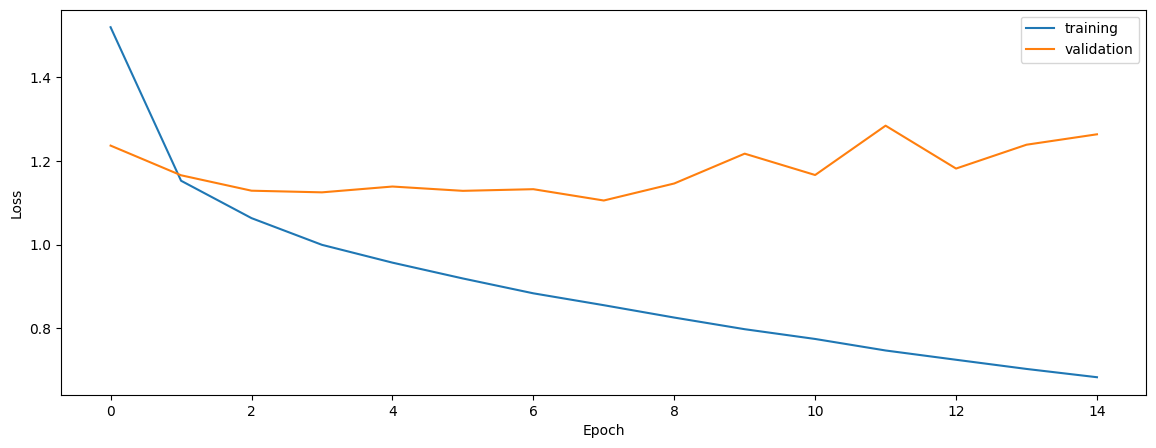

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6750152740068093
0.5719703495684234
0.5724713823457778


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.6039926990645677
0.5634547117039587
0.5166768465599232


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6031110307227203
0.5551765870832875
0.5158233844987682


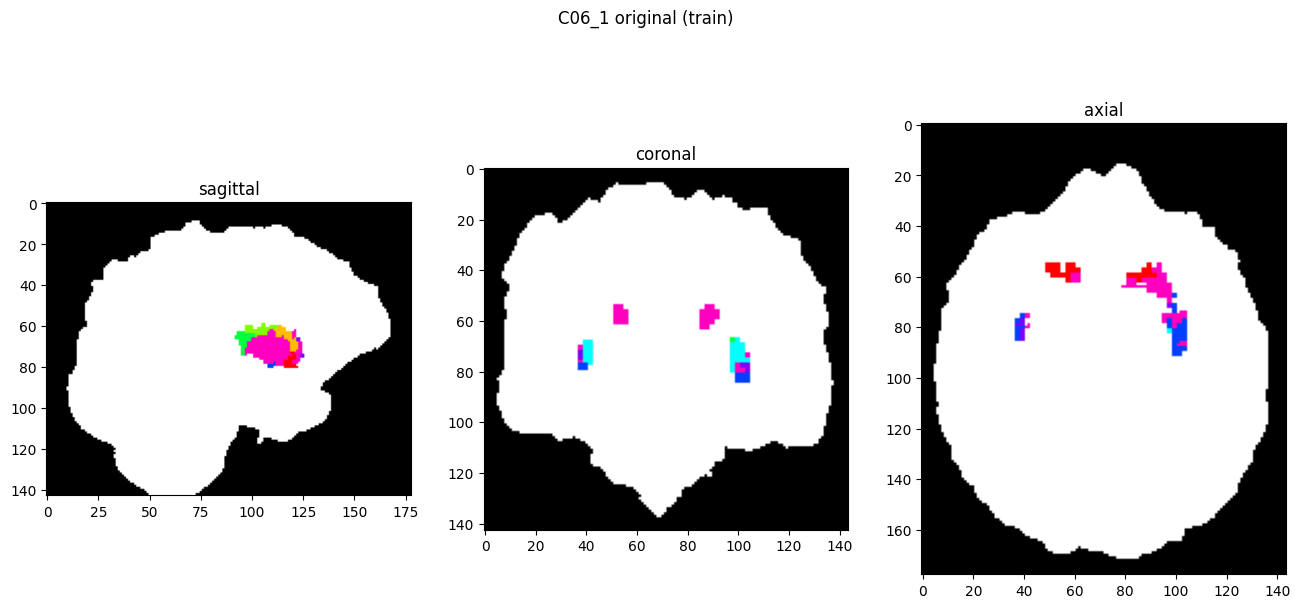

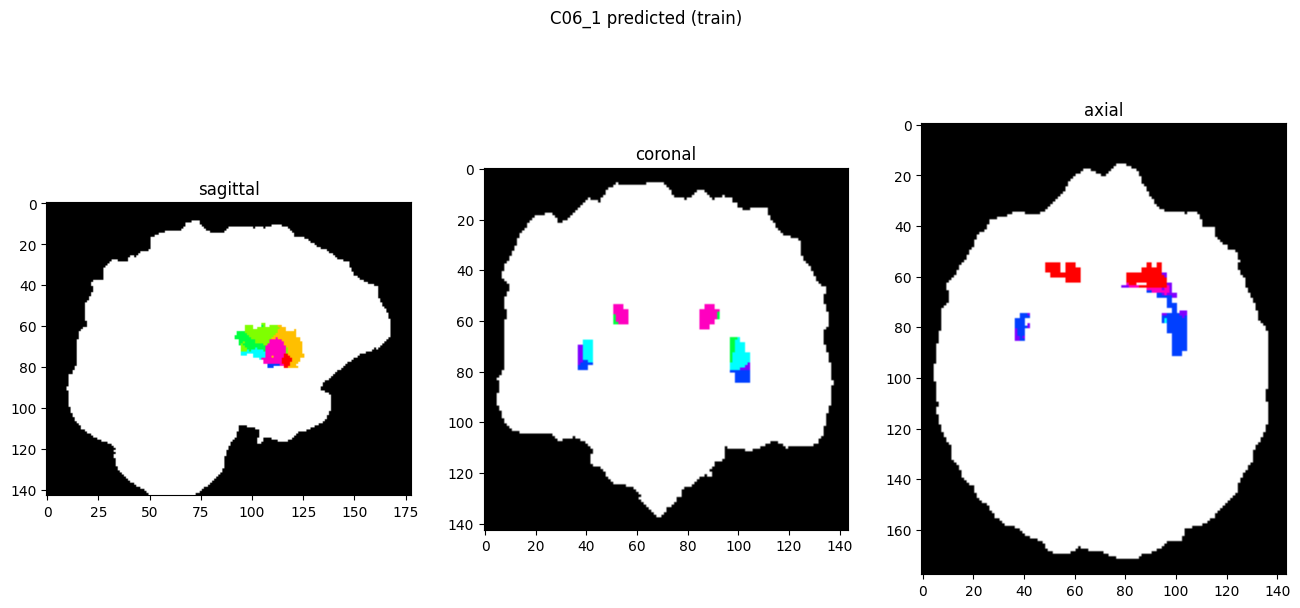

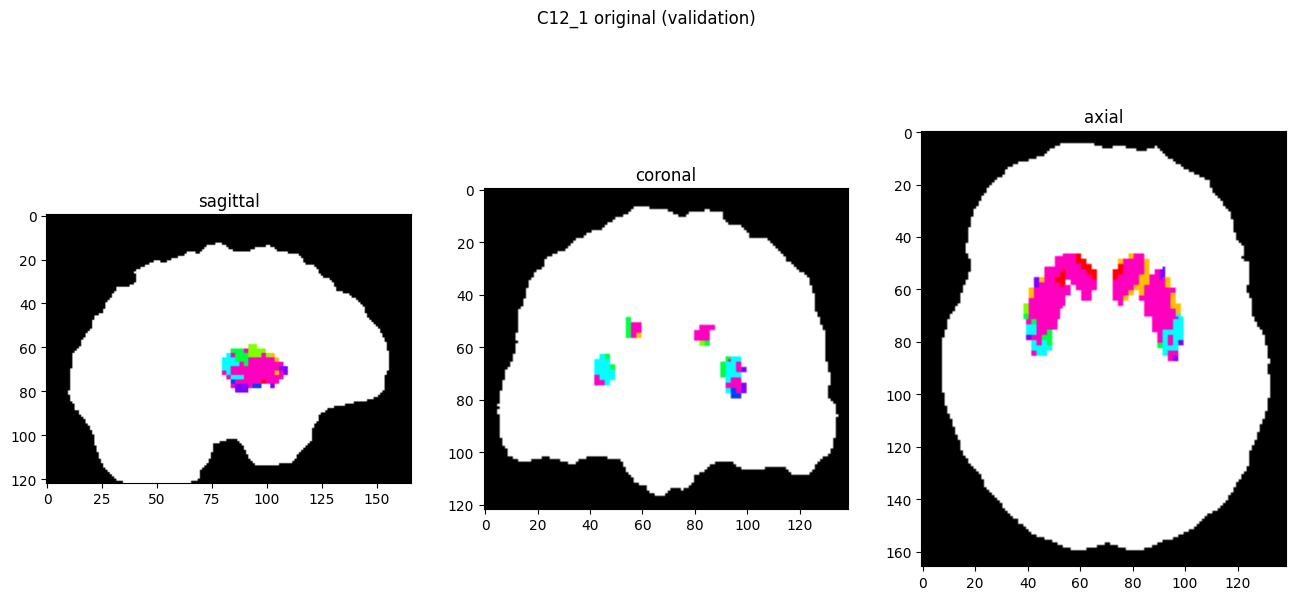

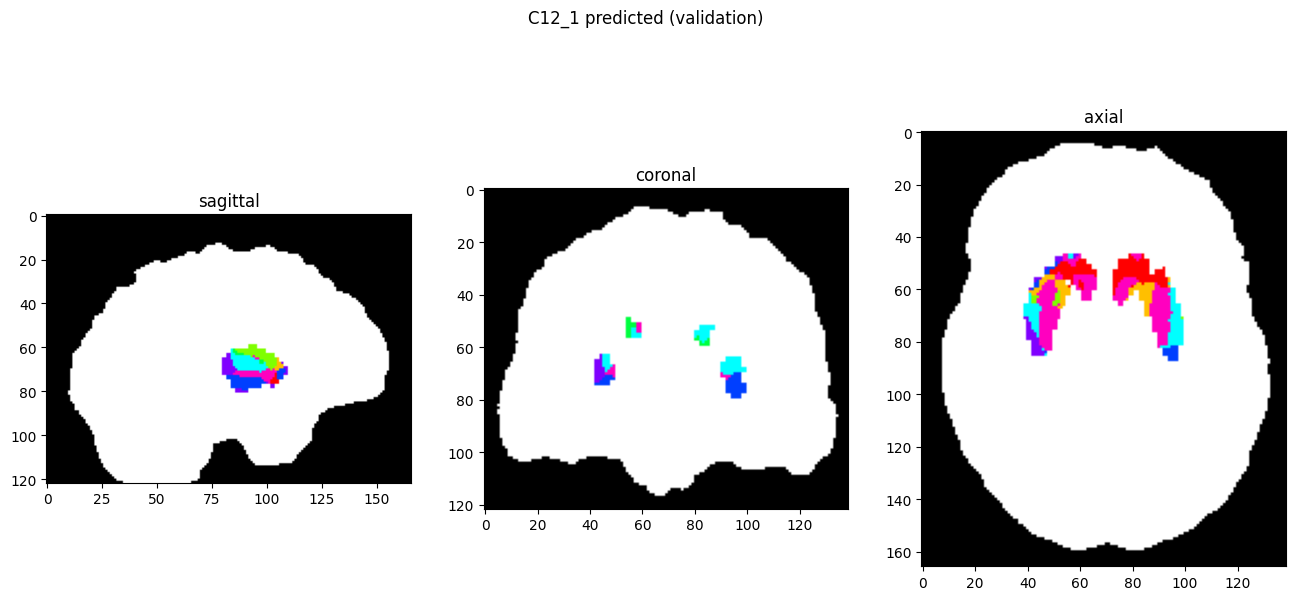

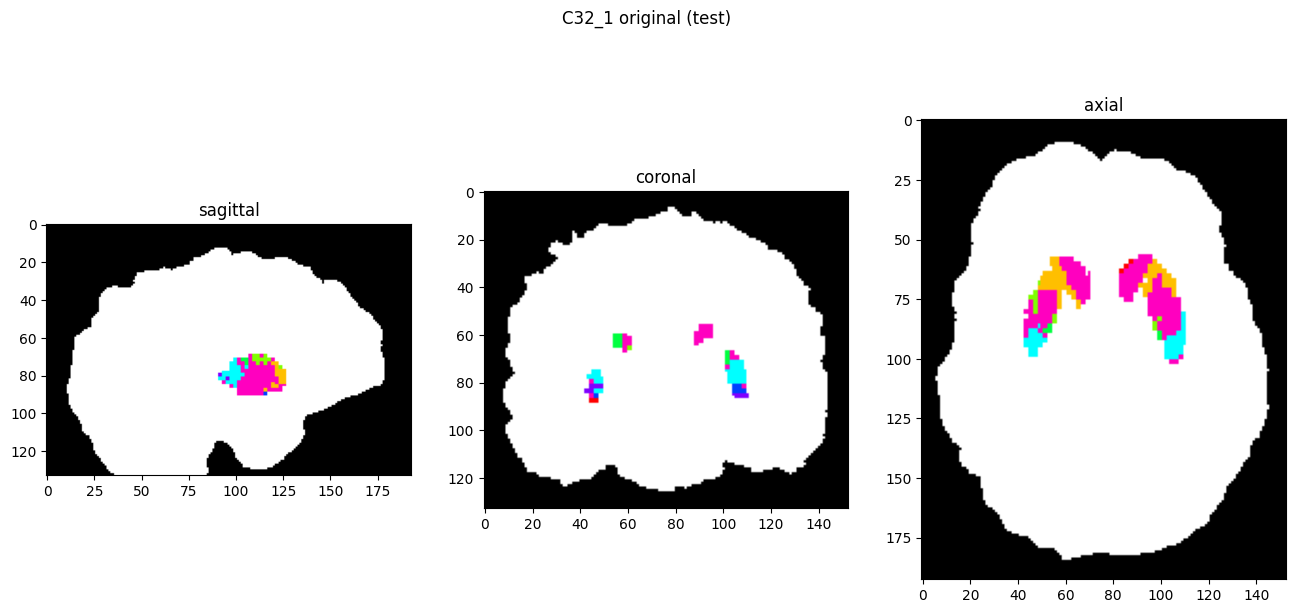

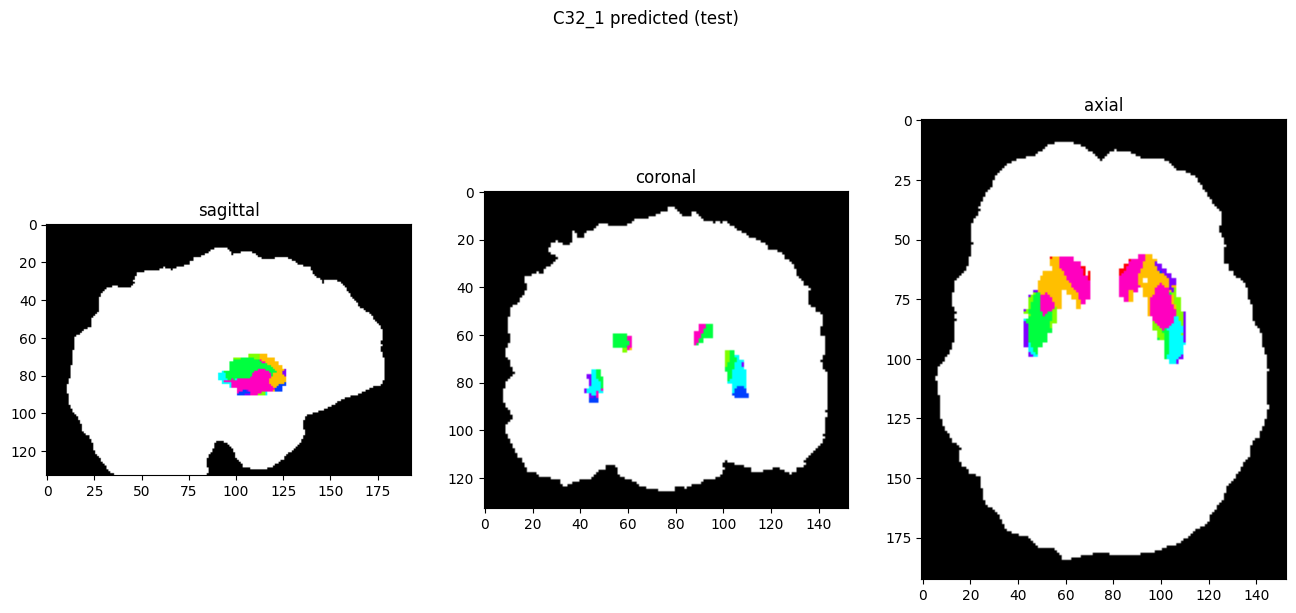

In [10]:
showResults(model, gen, threshold=0)